# Tools

In [33]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt

from collections import deque, Counter, namedtuple, OrderedDict
import numpy as np
import pandas as pd
from scipy.stats import rankdata, pearsonr, linregress, spearmanr
import scipy.stats as scs
from scipy.special import comb
import scipy as scpy
import statsmodels.api as sm
from statsmodels.formula.api import ols
from patsy.contrasts import Treatment
import statsmodels.formula.api as smf
import os
import warnings
from IPython.display import display, HTML
from itertools import combinations as combs
import itertools
import ipywidgets as wg

import loc_utils as lut
import vis_utils as vut
from standards import *

rx = RAWXix()
r = RAWix()

pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

gcolors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f']
colors = ['#43799d', '#cc5b46', '#ffbb00', '#71bc78']

glabels = {0: 'F', 1: 'S'} 
fullglabels = {0: 'Free', 1: 'Strategic'}
clabels = {0: 'i-', 1: 'i+'}
fullclabels = {0: 'uninformed', 1: 'informed'}

def gclabel(g, c):
    return '{}/{}'.format(glabels[g], clabels[c])

tlabels = OrderedDict({
        1: '1D',
        2: 'I1D',
        3: '2D',
        4: 'R'})

saveloc = '/Users/alexten/Projects/HFSP/fimg'
finloc = '/Users/alexten/Projects/HFSP/final'
draftloc = '/Users/alexten/Projects/HFSP/paper'
desktop = '/Users/alexten/Desktop/'
data_path = 'pipeline_data/s3/joint_data.pkl'

lss = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])


def save_it(fig, savedir, figname, save_as='svg', dpi=500, compress=False):
    s = savedir+'/{}.{}'.format(figname, save_as)
    fig.savefig(s, format=save_as, dpi=500)
    if compress:
        os.system('scour -i {} -o {}'.format(s, s.replace('img', 'img_compressed')))
    print('saved as {}'.format(figname))
    
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12)

In [25]:
def rolling_sum(a, n=4) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:]


def get_lps(df, **kwargs):
        arr = df.values
        mask = (arr != 0)
        arr = np.where(mask.any(axis=0), mask.argmax(axis=0), kwargs['invalid_val'])
        return pd.Series(arr, dtype=kwargs['dtype'])


def p_val(n, k, alpha):
    return comb(n,k)*(0.5**n)


def linez(d, fname='figure'):
        plt.figure(fname, figsize=[5,3])
        plt.subplot(111)

        for grp in [0, 1]:
            for cnd in [1,0]:
                mask = lut.get_mask(d, {1: grp, 2: cnd})
                N = mask.sum()
                plt.grid(True, zorder=0)
                hw = np.zeros_like(d[mask, 3]) + 1. / d[mask, 3].size
                vut.line_histogram(plt.gca(), 
                                   d[mask, 3], 
                                   bins=np.arange(-1,1.1,.25),
                                   lw=2,
                                   ls='-' if cnd else '--',
                                   label='{}/{} (N = {})'.format(glabels[grp], clabels[cnd], N),
                                   c=gcolors[grp])
                plt.legend()
                plt.xlim(-1.1,1.1)
                plt.ylim(0,.55)
                plt.yticks(np.arange(0,0.6,.1), 
                           np.around(np.arange(0,0.6,.1),1).astype(str),) 
                plt.xlabel("Correlation coefficient")
                plt.ylabel("Relative frequency")
                vut.despine(plt.gca(), 'top,right'.split(','))
        plt.tight_layout()

        
def barz(d, fname='figure'):
    plt.figure(fname, figsize=[7, 5])
    ii = 1
    for grp in [0, 1]:
        for cnd in [1, 0]:
            mask = lut.get_mask(d, {1: grp, 2: cnd})
            N = mask.sum()
            plt.subplot(2,2,ii)
            plt.grid(True, zorder=0)
            hw = np.zeros_like(d[mask, 3]) + 1. / d[mask, 3].size
            plt.hist(d[mask, 3], weights=hw, zorder=3,
                               bins=np.arange(-1,1.1,.25), fc=gcolors[0])
            plt.title('{} / {} (N = {})'.format(fullglabels[grp], fullclabels[cnd], N))
            plt.xlim(-1.1, 1.1)
            plt.ylim(0, .55)
            plt.yticks(np.arange(0, 0.6,.1), 
                       np.around(np.arange(0,0.6,.1),1).astype(str),) 
            plt.xlabel("Correlation coefficient")
            plt.ylabel("Relative frequency")
            vut.despine(plt.gca(), 'top,right'.split(','))
            ii+=1
    plt.tight_layout()

    
def randrank(x, seed=None):
    np.random.seed(seed)
    return rankdata(x + np.random.rand(*x.shape))


def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev


def dummies(a):
    z = np.zeros([a.shape[0], 4], dtype=int)
    i = np.arange(0, a.shape[0])
    z[i, a.astype(int)-1] = 1
    return z


def preplongdata(mpath, xpath, norm=False, save_csv='', pickle=''):
    mdata, xdata = lut.unpickle(mpath)['main'], lut.unpickle(xpath)
    nontest = lut.get_mask(mdata, {r.ix('stage'): 2}, '!=')
    mdata = mdata[nontest, :]
    sids, groups, conds, tasks = lut.get_unique(mdata, [r.ix('sid'), r.ix('group'), r.ix('cond'), r.ix('cat')])
    
    xcols = (['sid', 'grp', 'cnd'] +
         ['lrn_{}'.format(t) for t in tasks] +
         ['int_{}'.format(t) for t in tasks] +
         ['comp_{}'.format(t) for t in tasks] + 
         ['time_{}'.format(t) for t in tasks] +
         ['prog_{}'.format(t) for t in tasks] +
         ['rule_{}'.format(t) for t in tasks] +
         ['lrn2_{}'.format(t) for t in tasks])
    xix = xcols.index
    
    outdata = []
    order = np.array([1,2,3,4]).reshape(-1, 1)
    
    window = 15
    for sid in sids[:]:

        smask = lut.get_mask(mdata, {r.ix('sid'): sid})
        sxmask = lut.get_mask(xdata, {xix('sid'): sid})

        grp, cnd = xdata[sxmask, xix('grp')][0], xdata[sxmask, xix('cnd')][0]
        sid, grp, cnd = (np.zeros(4)+sid).tolist(), (np.zeros(4)+grp).tolist(), (np.zeros(4)+cnd).tolist()
        fid = mdata[smask, :][:, [r.ix('cat'), r.ix('fam')]]
        fid = [fid[fid[:, 0]==t, 1][0] for t in tasks]

        hits = mdata[smask, :][:, [r.ix('cat'), r.ix('cor')]]

        pc_grand = [np.mean(hits[hits[:, 0]==t, 1]) for t in tasks]
        
        pc1 = [np.mean(hits[hits[:, 0]==t, 1][:window]) for t in tasks]
        pc2 = [np.mean(hits[hits[:, 0]==t, 1][-window:]) for t in tasks]
        pc10 = [np.mean(hits[hits[:, 0]==t, 1][:10]) for t in tasks]
        pc615 = [np.mean(hits[hits[:, 0]==t, 1][6:15]) for t in tasks]
        dpc = np.array(pc2) - np.array(pc1)
        dpc[dpc < 0] = 0
        
        tasks, counts = np.unique(mdata[smask, r.ix('cat')], return_counts=True)
        freetime = (counts-15) / np.sum(mdata[smask, r.ix('stage')]==1)
        alltime = counts / np.sum(smask)
        
        switch = mdata[smask, :][60:, [r.ix('cat'),r.ix('switch')]]
        switches_to = np.array([np.logical_and(switch[:,0]==t, switch[:,1]).sum() for t in tasks])
        avstreak = (counts-15) / switches_to
        avstreak[np.isnan(avstreak)] = 0
        
        tord = mdata[smask, :][:60, r.ix('cat')]
        tord = np.array([tord[0], tord[15], tord[30], tord[45]])
        
        qblock = []
        for q in 'lrn,int,comp,time,prog,rule,lrn2'.split(','):
            qblock.append(xdata[sxmask, xix('{}_1'.format(q)):xix('{}_4'.format(q))+1].squeeze())   
        
        if norm:
            mean = np.stack(qblock, axis=1).mean()
            qblock += [q-mean for q in qblock]   
        
        dblock = [sid, grp, cnd, fid, tasks, tord,
                  pc_grand, pc1, pc2, dpc, pc10, pc615,
                  alltime, freetime, switches_to, avstreak]
        
        sidblock = np.stack(dblock + qblock, axis=1)
        outdata.append(sidblock)
    

    lcols = ('sid,grp,cnd,fam,tid,tord,pc_grand,pc_first,pc_last,dpc,pc05,pc1015,alltime,freetime,nblocks,avstreak,lrn,int,comp,time,prog,rule,lrn2'.split(',') + 
             (['n'+s for s in 'lrn,int,comp,time,prog,rule,lrn2'.split(',')]))
    dtypes = ('int,category,category,category,category,int,float,float,float,float,float,float,float,float,int,float,int,int,int,int,int,int,int'.split(',') + 
             (['float' for s in 'lrn,int,comp,time,prog,rule,lrn2'.split(',')]))

    outdata = OrderedDict(
        zip(lcols, 
            [pd.Series(d, dtype=dt) for d, dt in zip(np.concatenate(outdata, axis=0).T, dtypes)]
           )
    )
    outdata = pd.DataFrame(outdata, columns=lcols)
    display(outdata.head(16))
    outdata.replace(dict(grp={0.0: 'F', 1.0: 'S'}, 
                         cnd={0.0: 'i-', 1.0: 'i+'},
                         fam={1.0: 'Bear', 2.0: 'Bunny', 3.0: 'Green', 4.0: 'Squid'},
                         tid={1.0: '1_1D', 2.0: '2_I1D', 3.0: '3_2D', 4.0: '4_R'}), inplace=True)
    
    outdata = outdata.astype(dict(zip(lcols, dtypes)))
    display(outdata.head(16))
    if save_csv:
        print('Saving data to pipeline_data/longdata/{}'.format(save_csv))
        outdata.to_csv('pipeline_data/longdata/{}'.format(save_csv), index=False)
    
    if pickle:
        lut.dopickle('pipeline_data/longdata/{}'.format(pickle), outdata)
        

def prep_trials_data(path, window=15, alpha=.01, null=.5, save_as=False):
    mdata = lut.unpickle(path)['main']
    sids, groups, tasks = lut.get_unique(mdata, [r.ix('sid'), r.ix('group'),r.ix('cat')])

    nontest = freeplay = lut.get_mask(mdata, {r.ix('stage'): 2}, '!=')
    mdata = mdata[nontest, :]

    outdata = []
    cols = ('sid,grp,cnd,stage,trial,t0,t1,switch,cor,'
            'pc1,pc2,pc3,pc4,p1,p2,p3,p4,'
            'loc_pc1,loc_pc2,loc_pc3,loc_pc4,'
            'loc_p1,loc_p2,loc_p3,loc_p4,'
            'sc,loc_sc,alt_sc').split(',')
    ix = cols.index

    for grp in groups:
        gmask = lut.get_mask(mdata, {r.ix('group'): grp})
        gsids = lut.get_unique(mdata[gmask,:], r.ix('sid'))
        
        for sid in gsids:
            sdata = mdata[lut.get_mask(mdata, {r.ix('sid'): sid}), :]
            sid_data = np.full([sdata.shape[0], len(cols)], np.nan)
            
            # fill in task on next trial
            sid_data[:-1, ix('t1')] = sdata[:, r.ix('cat')][1:]
            sid_data[-1, ix('t1')] = np.nan
            
            # fill in group, sid, stage, etc
            sid_data[:,ix('sid')] = sdata[:, r.ix('sid')]
            sid_data[:,ix('grp')] = grp
            sid_data[:,ix('cnd')] = sdata[0, r.ix('cond')]
            sid_data[:,ix('stage')] = sdata[:, r.ix('stage')]
            sid_data[:,ix('cor')] = sdata[:, r.ix('cor')] 
            sid_data[60:-1,ix('switch')] = sdata[61:, r.ix('switch')]
            
            # fill in trial numbers
            sid_data[:, ix('trial')] = sdata[:, r.ix('trial')]
            
            # fill in task on current trial
            sid_data[:, ix('t0')] = sdata[:, r.ix('cat')]
            
            for ti, tsk in enumerate(tasks):
                tmask = lut.get_mask(sdata, {r.ix('cat'): tsk})
                
                # compute cumulative pc and pval
                trials_so_far = np.cumsum(tmask)
                container = np.full(sid_data.shape[0], np.nan)
                container[tmask] = sdata[tmask, r.ix('cor')]
                cor_so_far = pd.Series(container).cumsum().fillna(method='ffill').values
                notnan = ~np.isnan(cor_so_far)
                sid_data[:, ix('pc{}'.format(tsk))] = cor_so_far / trials_so_far
                sid_data[notnan, ix('p{}'.format(tsk))] = p_val(
                    trials_so_far[notnan], cor_so_far[notnan], null)
                
                # compute rolling pc and pval
                container = np.full(sid_data.shape[0], np.nan)
                subcontainer = np.full(tmask.sum(), np.nan)
                subcontainer[window-1:] = rolling_sum(sdata[tmask, r.ix('cor')], n=window)
                container[tmask] =  subcontainer 
                cor_window = pd.Series(container).fillna(method='ffill').values
                notnan = ~np.isnan(cor_window)
                sid_data[:, ix('loc_pc{}'.format(tsk))] = cor_window / window
                sid_data[notnan, ix('loc_p{}'.format(tsk))] = p_val(window, cor_window[notnan], null)
            
            # compute sc index (no choice data available for last trial, so look at the first T-1 trials)
            t1 = sid_data[:-1, ix('t1')].astype(int)-1
            t0 = sid_data[:-1, ix('t0')].astype(int)-1
            
            for _ in ['','loc_']:
                pcs = sid_data[:-1, ix(_+'pc1'):ix(_+'pc4')+1].copy()
                pvals = sid_data[:-1, ix(_+'p1'):ix(_+'p4')+1]

                actual_next_choice = np.zeros([sid_data.shape[0]-1, 4]).astype(bool)
                actual_next_choice[np.arange(t1.size), t1] = True

                choice_pc = pcs[actual_next_choice]
                with np.errstate(divide='ignore', invalid='ignore'):
                    learnt = np.logical_and(pvals < alpha, pcs > null)
                pcs[learnt] -= 1

                predicted_pc = sid_data[
                    np.arange(sid_data.shape[0]-1), 
                    ix(_+'pc1')+np.argmax(pcs, axis=1)] # argmax selects the maximum pc column

                sid_data[:-1, ix(_+'sc')] = predicted_pc - choice_pc

                all_four = np.all(learnt, axis=1)
                sid_data[:-1][all_four, ix(_+'sc')] = np.nan
            
            pcs = sid_data[:-1, ix('loc_pc1'):ix('loc_pc4')+1].copy()
            _max = pd.Series(pcs.max(axis=1)).rolling(pcs.shape[0], min_periods=1).max()
            _min = pd.Series(pcs.min(axis=1)).rolling(pcs.shape[0], min_periods=1).min()
            _actual_choice = np.zeros([sid_data.shape[0]-1, 4]).astype(bool)
            _actual_choice[np.arange(t0.size), t0] = True
            _pc = pcs[_actual_choice]
            alt_sc = 1 - (_pc-_min)/(_max-_min)
            sid_data[:-1, ix('alt_sc')] = alt_sc
                      
            outdata.append(sid_data)
            
    outdata = np.vstack(outdata)
    
    dtypes = ['Int64' for i in range(9)]+['float' for i in range(19)]
    outdata = OrderedDict(
        zip(cols, 
            [pd.Series(d, dtype=dt) for d, dt in zip(outdata.T, dtypes)]
           )
    )
    outdata = pd.DataFrame(outdata)

    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    display(outdata.loc[(outdata.sid==0) & (outdata.trial>60), 
                        'trial,t0,loc_pc1,loc_pc2,loc_pc3,loc_pc4,sc,loc_sc,alt_sc'.split(',')].head())
    
    if save_as:
        lut.dopickle(save_as, outdata)
        
        
def prep_ntm_data(path, crit=.8, save=False):
    # Set the columns to keep
    p_str, pc_str , sc_str= 'loc_p', 'loc_pc', 'loc_sc'
    tasks = [1,2,3]
    cols = ['grp', 'trial', 't0','sc','loc_sc','cor', 'switch']
    cols += [p_str+str(t) for t in tasks]+[pc_str+str(t) for t in tasks]
    
    # Load data, filter free play trials plus the last training trial
    df = lut.unpickle(path).set_index('sid')
    
    df.trial -= 61
    df = df.loc[(df.trial>=-1) & (df.trial<250), cols+['loc_pc4']]

    # Find who learned what in each group
    crit_pval = df.loc[:, p_str+'1':p_str+'3'] < .01
    crit_pc = df.loc[:, pc_str+'1':pc_str+'3'] >= crit
    crit_pval.columns, crit_pc.columns = tasks[:], tasks[:]
    learned = crit_pc
    
    # Find LP order and LP trials of each subject
    # ============================================
    
    # 1) get subthreshold trials (STTs) for each subject
    by_sid = learned.groupby('sid')
    
    # 2) based on STTs, find learning points (LPs) and NTM
    rename_dict = {0:'lp1', 1:'lp2', 2:'lp3'}
    lps = by_sid.apply(get_lps, invalid_val=250, dtype='int').rename(columns=rename_dict).reset_index()
    ntm = by_sid.any().sum(axis=1).to_frame(name='ntm').reset_index()
    
    # 3) based on LPs, find learning order
#     rename_dict = {'lp1':'lp1t', 'lp2':'lp2t', 'lp3':'lp3t'}
#     lpord = lps.rank(method='first', axis=1).rename(columns=rename_dict).astype(int)
    
    # Dummy code task played on each trial and create the final DF
    # =============================================================
    
    df = df.loc[df.trial>=0, :]
    
    rename_dict = dict(zip([1,2,3,4],'st1,st2,st3,st4'.split(',')))
    dumm = pd.get_dummies(df.t0).rename(columns=rename_dict)
    
    df = pd.concat([df, dumm], axis=1)
    df = df.reset_index().merge(ntm, on='sid')
    df = df.merge(lps, on='sid')
    
    display(df.head(10))
    
    if save:
        lut.dopickle(save, df) 
    


if 0: preplongdata(data_path, 'pipeline_data/s3/extra_data_good_form.pkl',  True,
                save_csv='long3.csv', pickle='long3.pkl')
    

# for window in [5,10,15]:
window=15
if 0: prep_trials_data(path='pipeline_data/s3/joint_data.pkl', window=window, 
                           save_as='pipeline_data/clear_data/trials_data_w{}.pkl'.format(window))

if 0: prep_ntm_data(path = 'pipeline_data/clear_data/trials_data_w{}.pkl'.format(window),
                      save = 'pipeline_data/clear_data/windows/ntm_data_freeplay_w{}.pkl'.format(window))
    
if 0: preplongdata(mpath='pipeline_data/s3/joint_data.pkl', 
                   xpath='pipeline_data/s3/extra_data_good_form.pkl', 
                   norm=True, save_csv='', pickle='long4.pkl')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in true_divide


,sid,grp,cnd,fam,tid,tord,pc_grand,pc_first,pc_last,dpc,pc05,pc1015,alltime,freetime,nblocks,avstreak,lrn,int,comp,time,prog,rule,lrn2,nlrn,nint,ncomp,ntime,nprog,nrule,nlrn2
0,0,0.0,0.0,3.0,1.0,3,0.933333,0.933333,0.933333,0.000000,0.9,1.000000,0.048387,0.000000,0,0.000000,3,2,1,1,1,10,1,-1.928571,-2.928571,-3.928571,-3.928571,-3.928571,5.071429,-3.928571
1,0,0.0,0.0,1.0,2.0,4,0.806452,0.733333,0.933333,0.200000,0.7,0.777778,0.100000,0.064000,1,16.000000,6,3,3,3,6,10,2,1.071429,-1.928571,-1.928571,-1.928571,1.071429,5.071429,-2.928571
2,0,0.0,0.0,2.0,3.0,2,0.818653,0.200000,1.000000,0.800000,0.3,0.111111,0.622581,0.712000,2,89.000000,8,8,7,8,9,8,3,3.071429,3.071429,2.071429,3.071429,4.071429,3.071429,-1.928571
3,0,0.0,0.0,4.0,4.0,1,0.535211,0.800000,0.266667,0.000000,0.7,0.777778,0.229032,0.224000,2,28.000000,6,4,9,4,4,2,6,1.071429,-0.928571,4.071429,-0.928571,-0.928571,-2.928571,1.071429
4,1,0.0,0.0,1.0,1.0,1,0.887640,0.666667,0.933333,0.266667,0.5,0.777778,0.286174,0.294821,3,24.666667,10,10,1,10,10,6,1,3.250000,3.250000,-5.750000,3.250000,3.250000,-0.750000,-5.750000
5,1,0.0,0.0,3.0,2.0,2,0.795455,0.733333,0.800000,0.066667,0.6,0.777778,0.141479,0.115538,2,14.500000,10,10,1,9,10,6,1,3.250000,3.250000,-5.750000,2.250000,3.250000,-0.750000,-5.750000
6,1,0.0,0.0,2.0,3.0,4,0.669643,0.733333,0.733333,0.000000,0.7,0.888889,0.360129,0.386454,3,32.333333,10,5,8,4,6,8,10,3.250000,-1.750000,1.250000,-2.750000,-0.750000,1.250000,3.250000
7,1,0.0,0.0,4.0,4.0,3,0.454545,0.666667,0.333333,0.000000,0.6,0.777778,0.212219,0.203187,2,25.500000,10,1,10,1,1,10,10,3.250000,-5.750000,3.250000,-5.750000,-5.750000,3.250000,3.250000
8,2,0.0,0.0,1.0,1.0,4,0.902256,0.666667,0.933333,0.266667,0.5,0.888889,0.427653,0.470120,1,118.000000,2,5,1,7,10,10,1,-3.464286,-0.464286,-4.464286,1.535714,4.535714,4.535714,-4.464286
9,2,0.0,0.0,2.0,2.0,1,0.479167,0.600000,0.400000,0.000000,0.7,0.444444,0.154341,0.131474,1,33.000000,8,5,9,4,3,3,8,2.535714,-0.464286,3.535714,-1.464286,-2.464286,-2.464286,2.535714


,sid,grp,cnd,fam,tid,tord,pc_grand,pc_first,pc_last,dpc,pc05,pc1015,alltime,freetime,nblocks,avstreak,lrn,int,comp,time,prog,rule,lrn2,nlrn,nint,ncomp,ntime,nprog,nrule,nlrn2
0,0,F,i-,Green,1_1D,3,0.933333,0.933333,0.933333,0.000000,0.9,1.000000,0.048387,0.000000,0,0.000000,3,2,1,1,1,10,1,-1.928571,-2.928571,-3.928571,-3.928571,-3.928571,5.071429,-3.928571
1,0,F,i-,Bear,2_I1D,4,0.806452,0.733333,0.933333,0.200000,0.7,0.777778,0.100000,0.064000,1,16.000000,6,3,3,3,6,10,2,1.071429,-1.928571,-1.928571,-1.928571,1.071429,5.071429,-2.928571
2,0,F,i-,Bunny,3_2D,2,0.818653,0.200000,1.000000,0.800000,0.3,0.111111,0.622581,0.712000,2,89.000000,8,8,7,8,9,8,3,3.071429,3.071429,2.071429,3.071429,4.071429,3.071429,-1.928571
3,0,F,i-,Squid,4_R,1,0.535211,0.800000,0.266667,0.000000,0.7,0.777778,0.229032,0.224000,2,28.000000,6,4,9,4,4,2,6,1.071429,-0.928571,4.071429,-0.928571,-0.928571,-2.928571,1.071429
4,1,F,i-,Bear,1_1D,1,0.887640,0.666667,0.933333,0.266667,0.5,0.777778,0.286174,0.294821,3,24.666667,10,10,1,10,10,6,1,3.250000,3.250000,-5.750000,3.250000,3.250000,-0.750000,-5.750000
5,1,F,i-,Green,2_I1D,2,0.795455,0.733333,0.800000,0.066667,0.6,0.777778,0.141479,0.115538,2,14.500000,10,10,1,9,10,6,1,3.250000,3.250000,-5.750000,2.250000,3.250000,-0.750000,-5.750000
6,1,F,i-,Bunny,3_2D,4,0.669643,0.733333,0.733333,0.000000,0.7,0.888889,0.360129,0.386454,3,32.333333,10,5,8,4,6,8,10,3.250000,-1.750000,1.250000,-2.750000,-0.750000,1.250000,3.250000
7,1,F,i-,Squid,4_R,3,0.454545,0.666667,0.333333,0.000000,0.6,0.777778,0.212219,0.203187,2,25.500000,10,1,10,1,1,10,10,3.250000,-5.750000,3.250000,-5.750000,-5.750000,3.250000,3.250000
8,2,F,i-,Bear,1_1D,4,0.902256,0.666667,0.933333,0.266667,0.5,0.888889,0.427653,0.470120,1,118.000000,2,5,1,7,10,10,1,-3.464286,-0.464286,-4.464286,1.535714,4.535714,4.535714,-4.464286
9,2,F,i-,Bunny,2_I1D,1,0.479167,0.600000,0.400000,0.000000,0.7,0.444444,0.154341,0.131474,1,33.000000,8,5,9,4,3,3,8,2.535714,-0.464286,3.535714,-1.464286,-2.464286,-2.464286,2.535714


File pipeline_data/longdata/long4.pkl exists. Overwrite? [y/n]
>>> y
Overwriting data to pipeline_data/longdata/long4.pkl
Done saving.


# Task description and sanity checks

### 1A: sanity check (plot)

Did performance vary with task difficulty (as intended), group, and condition (not intended)

In [ ]:
def f1a(path, figname, save):
    # -------------- Tweak these params to make LRN fig --------------
    X = 'pc'
    bins = np.arange(1,12) if X == 'lrn' else np.arange(0, 1.01 + 1/15, 1/15)

    xlim = [1, 11] if X == 'lrn' else [0, 1.1]
    ylim = [0, .5] if X == 'lrn' else [0, .3]
    xlabel = 'Learnability' if X == 'lrn' else 'Number of hits'
    legend = 1 if X == 'lrn' else 1
    suptitle = 'Relative frequencies of {} for each task \nsplit by group ans condition'.format(X.upper())
    # -------------- ================================== --------------
    
    locix = ['group', 'sid', 'cond', 'task', 'pc', 'lrn'].index

    data = lut.unpickle(path)
    tasks, groups, conds = lut.get_unique(data, [locix('task'), locix('group'), locix('cond')])
    
    plt.rc('lines', linewidth=2)

    fig = plt.figure(num='performance during training', figsize=[6,4])
    fig.subplots_adjust(right=.7)
    glabels = ['F' ,  'S']
    clabels = ['i-', 'i+']
    tlabels = ['1D', 'I1D', '2D', 'R']

    spix = 1
    for tsk in tasks:
        ax = fig.add_subplot(2,2,spix)
        ax.set_xlim(xlim[0], xlim[1])
        ax.set_ylim(ylim[0], ylim[1])
        for grp in groups:
            mask = lut.get_mask(data, {locix('group'): grp, locix('task'): tsk})
            vut.line_histogram(ax, data[mask, locix(X)], bins = bins, 
                               label='{}'.format(glabels[grp]), lw=2, c=gcolors[grp])

            if legend: ax.legend()
            ax.set_title('{}'.format(tlabels[tsk-1]))
            if tsk == 1 or tsk == 3: ax.set_ylabel('Relative frequency')
            if 1: # <------------------------------------------------ TURN ON/OFF TICKER ROTATION HERE
                ax.set_xticklabels([i for i in range(16)])
                if tsk>=3: ax.set_xlabel('Number of hits')
                    # ax.set_xticklabels(np.around(bins,2), rotation=90)
                    # ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))

                if spix == 4: ax.set_xlabel(xlabel)
        spix += 1
    fig.subplots_adjust(right=.75, hspace=.3, top=.95 if save else .9)
    fig.tight_layout()
    # fig.suptitle(suptitle  if not save_as else '')
    
    if save: 
        save_it(fig, finloc, figname, save_as='png')
        save_it(fig, finloc, figname, save_as='svg')


if 1:
    f1a('pipeline_data/pc_and_lrn/filtered.pkl', figname = 'f1a', save = True)

### 1A: sanity check (analaysis)

It appears that our manipulation of task difficulty produced the anticipated effect. A 3-way mixed ANOVA for examining the independent effects of group and condtion, as well as the within-subjects effect of task difficulty (`tid`) only revealed the main effect of the latter variable, and no interactions ($F(3,975) = 140.477, p<.001$):

```R
Call: summary(aov(pc_first ~ grp*cnd*tid + Error(sid), data=data))

Error: sid
           Df Sum Sq Mean Sq F value Pr(>F)
grp         1  0.065 0.06498   2.224  0.137
cnd         1  0.000 0.00003   0.001  0.973
grp:cnd     1  0.052 0.05197   1.779  0.183
Residuals 325  9.495 0.02922               

Error: Within
             Df Sum Sq Mean Sq F value Pr(>F)    
tid           3  9.754   3.251 140.477 <2e-16 ***
grp:tid       3  0.113   0.038   1.630  0.181    
cnd:tid       3  0.128   0.043   1.839  0.138    
grp:cnd:tid   3  0.037   0.012   0.540  0.655    
Residuals   975 22.566   0.023                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
```

To examine further, whether our experimental manipulations worked as intended, we need to have a closer look at other sources of within-subject variability in performance that coincided with task difficulty: monster type and order of presentation. Within each subject, each task difficulty was uniquely associated with one out of four monster types (Bear, Bunny, GreenMonster, and Squid). Although some parameters of variability, like the number of variable dimensions and the conditional predictablity of food preferences varied *across* monster types (each could be 1D, I1D, 2D, or R), specific monster features varied *within* monster types, which could result in varying difficulty among them. Moreover, there could be order effects on performance as well, for example increasing performance on later tasks due to increasing familiarity with the general procedure, increasing attention, etc. Note that if any of these potential random effects is significant, they are likely to interact with the experimental manipulation (e.g. an easy task should be even easier with an easy monster type, and easier still at the right time).

A similar mixed ANOVA was conducted, but this time the analysis included the random effects of monster type and task order (named `fam` and `tord`, respectively):

```R
Call: summary(aov(pc_first ~ grp*cnd*tid*fam*tord + Error(sid), data=data)) # Mixed 3-way ANOVA

Error: sid
                      Df Sum Sq Mean Sq F value Pr(>F)  
grp                    1  0.065 0.06498   2.294 0.1327  
cnd                    1  0.000 0.00003   0.001 0.9729  
grp:cnd                1  0.052 0.05197   1.835 0.1783  
tid:fam                9  0.569 0.06319   2.231 0.0249 *
tid:tord               9  0.459 0.05099   1.800 0.0758 .
fam:tord               9  0.137 0.01524   0.538 0.8439  
grp:tid:fam            9  0.165 0.01836   0.648 0.7536  
cnd:tid:fam            9  0.319 0.03545   1.251 0.2715  
grp:tid:tord           9  0.339 0.03764   1.329 0.2300  
cnd:tid:tord           9  0.109 0.01213   0.428 0.9174  
grp:fam:tord           9  0.299 0.03317   1.171 0.3203  
cnd:fam:tord           9  0.300 0.03329   1.175 0.3176  
tid:fam:tord          27  1.319 0.04885   1.725 0.0257 *
grp:cnd:tid:fam        9  0.133 0.01478   0.522 0.8561  
grp:cnd:tid:tord       9  0.164 0.01820   0.642 0.7586  
grp:cnd:fam:tord       9  0.404 0.04485   1.583 0.1287  
grp:tid:fam:tord      27  0.563 0.02087   0.737 0.8185  
cnd:tid:fam:tord      27  0.641 0.02373   0.838 0.6946  
grp:cnd:tid:fam:tord  24  0.403 0.01681   0.594 0.9295  
Residuals            112  3.172 0.02833                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: Within
                      Df Sum Sq Mean Sq F value  Pr(>F)    
tid                    3  9.754   3.251 167.310 < 2e-16 ***
fam                    3  1.578   0.526  27.065 < 2e-16 ***
tord                   3  0.172   0.057   2.955 0.03179 *  
grp:tid                3  0.135   0.045   2.322 0.07394 .  
cnd:tid                3  0.128   0.043   2.191 0.08775 .  
grp:fam                3  0.112   0.037   1.923 0.12433    
cnd:fam                3  0.115   0.038   1.971 0.11696    
tid:fam                9  1.132   0.126   6.472 6.8e-09 ***
grp:tord               3  0.145   0.048   2.495 0.05878 .  
cnd:tord               3  0.019   0.006   0.329 0.80434    
tid:tord               9  0.118   0.013   0.674 0.73295    
fam:tord               9  0.146   0.016   0.834 0.58467    
grp:cnd:tid            3  0.031   0.010   0.524 0.66587    
grp:cnd:fam            3  0.099   0.033   1.696 0.16655    
grp:tid:fam            9  0.455   0.051   2.603 0.00583 ** 
cnd:tid:fam            9  0.117   0.013   0.671 0.73583    
grp:cnd:tord           3  0.075   0.025   1.292 0.27605    
grp:tid:tord           9  0.365   0.041   2.086 0.02854 *  
cnd:tid:tord           9  0.239   0.027   1.365 0.20019    
grp:fam:tord           9  0.097   0.011   0.554 0.83471    
cnd:fam:tord           9  0.236   0.026   1.350 0.20749    
tid:fam:tord          27  0.744   0.028   1.417 0.07888 .  
grp:cnd:tid:fam        9  0.090   0.010   0.514 0.86536    
grp:cnd:tid:tord       9  0.160   0.018   0.917 0.50943    
grp:cnd:fam:tord       9  0.222   0.025   1.267 0.25098    
grp:tid:fam:tord      27  0.582   0.022   1.108 0.32179    
cnd:tid:fam:tord      27  0.676   0.025   1.289 0.14967    
grp:cnd:tid:fam:tord  24  0.515   0.021   1.105 0.33157    
Residuals            738 14.341   0.019                        
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
```

Similarly, to the last analysis, no main between-subjects effects were found. However, both random effects of monster type ($F(3,738) = 27.065, p < .001$) and task order ($F(3,738) = 2.995, p < .001 $) were significant. Several interaction seem interesting. I will dismiss the marginally significant interactions of `grp` and `cnd` with `tid`, since no main effects of the former two were found. One highly significant interaction was between `tid` and `fam` variables ($F(9,738) = 6.472, p < .001$). Another two significant interactions were (1) a three-way interaction between `grp`, `tid`, `fam` and (2) a three-way interaction between `grp`, `tid`, `fam`. In the following section, we will examine the nature of these effects more closely.

### 1B: Effects of monster type on PC

For whatever reason, the Bunny monster type was harder to learn, and more so in simpler tasks. The same was true, but to a lesser extent for the Green Monster type. Apparently, the simplest 1D task with Bunny monsters was harder than the I1D task with Bear and Squid monsters; and the I1D task was just as hard for Bunnies as 2D was for other monster types. This might have to do with the saliency of feature variability. In any case, this effect was not planned or anticipated, but it is real, so we can't ignore it.

For our purposes, this should not pose a problem if the data is well-balanced. Specifically, if across groups and conditions, the distribution of monster types across task difficulties is more or less uniform, then things like task difficulty and performance metrics should be relatively free from systematic effects of monster type. I am not sure how to quantify this degree of balance.

In [ ]:
def f1b(path, figname, save):
    mfc = np.array([(151,194,230),(236,91,140),(224,186,55),(224,154,80)])/255
    
    df = lut.unpickle(path) 
    df.replace(dict(tid={'1D': '1_1D', 'I1D': '2_I1D', '2D': '3_2D', 'R': '4_R'}), inplace=True)
    
    split1mean = df.groupby(['fam'])['pc_first'].mean()
    split1sem = df.groupby(['fam'])['pc_first'].sem()
    
    split2mean = df.groupby(['tid','fam'])['pc_first'].mean()
    split2sem = df.groupby(['tid','fam'])['pc_first'].sem()


    fig = plt.figure(num=figname, figsize=[8,4])
    
    ax1 = fig.add_subplot(121)
    ax1.grid(True, ls=':', zorder=0)
    ax1.set_ylabel('Mean performance (% correct)')
    ax1.set_xlabel('Monster type')
    ax1.set_ylim(.5, .7)
    vut.despine(ax1)
    for i in [0,1,2,3]: 
        ax1.bar(x = i+1, height = split1mean.values[i], 
                facecolor=mfc[i], label=split1mean.index[i], zorder=2)
    ax1.errorbar(x = [1,2,3,4], y = split1mean.values, yerr = split1sem.values,
                 linestyle='', color='k', zorder=3)
    ax1.set_xticks([1,2,3,4])
    ax1.xaxis.set_ticklabels(split1mean.index)
    
    
    
    ax2 = fig.add_subplot(122)
    ax2.grid(True, ls=':', zorder=0)
    ax2.set_ylabel('Mean performance (% correct)')
    ax2.set_xlabel('Task')
    vut.despine(ax2)
    for i, fam in enumerate(split2mean.index.levels[1]):
        ax2.errorbar(x = [1,2,3,4], y = split2mean[:, fam].values, yerr = split2sem[:, fam].values,
                     color=mfc[i], marker = 'o^vD'[i], ms=5, capsize=5, alpha=.7, label=fam)
#                  linestyle='', color='k', zorder=3)
#     ax1.set_ylim(.5, .7)
    ax2.set_xticks([1,2,3,4])
    ax2.xaxis.set_ticklabels(tlabels.values())
    ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    fig.tight_layout()
    
    if save: 
        save_it(fig, finloc, figname, save_as='png')
        save_it(fig, finloc, figname, save_as='svg')
        
    counts = df.groupby(['grp','cnd','tid','fam']).size()
    print(counts['F', 'i+', '1_1D'])
    for grp in counts.index.levels[0]:
        for cnd in counts.index.levels[1]:
            print(grp+', '+cnd)
            for tid in counts.index.levels[2]:
                s = counts[grp, cnd, tid].values/counts[grp, cnd, tid].values.sum()
                print('      {:6}: {}'.format(tid, np.around(s, 2)))
                
    counts = df.groupby(['grp','tid','fam']).size()
    for grp in counts.index.levels[0]:
            print(grp)
            for tid in counts.index.levels[1]:
                s = counts[grp, tid].values/counts[grp, tid].values.sum()
                print('      {:6}: {}'.format(tid, np.around(s, 2)))

if 1:
    f1b('pipeline_data/longdata/long.pkl', figname = 'f1b', save = False)

### 1C: Effects of task order on PC

Task order appears to have a much weaker effect, compared to either task difficulty or monster type. Overall, later presentation of a task seems to be benefitial for performance, but the effect diminishes with more time. There might be some interaction between task difficulty and task order. For instance, it seems that in 1D, it is very benefitial to not have as the very 1st task, but this does not hold for any other task. 

In [ ]:
def f1c(path, figname, save):
    mfc = np.array([(151,194,230),(236,91,140),(224,186,55),(224,154,80)])/255
    
    df = lut.unpickle(path) 
    df.replace(dict(tid={'1D': '1_1D', 'I1D': '2_I1D', '2D': '3_2D', 'R': '4_R'}), inplace=True)
    
    split1mean = df.groupby(['tord'])['pc_first'].mean()
    split1sem = df.groupby(['tord'])['pc_first'].sem()
    
    split2mean = df.groupby(['tord','tid'])['pc_first'].mean()
    split2sem = df.groupby(['tord','tid'])['pc_first'].sem()


    fig = plt.figure(num=figname, figsize=[8.5,4])
    
    ax1 = fig.add_subplot(121)
    ax1.grid(True, ls=':', zorder=0)
    ax1.set_ylabel('Mean performance (% correct)')
    ax1.set_xlabel('Task order')
    ax1.set_ylim(.5, .7)
    vut.despine(ax1)
    for i in [0,1,2,3]: 
        ax1.bar(x = i+1, height = split1mean.values[i], 
                facecolor=gcolors[0], label=split1mean.index[i], zorder=2)
    ax1.errorbar(x = [1,2,3,4], y = split1mean.values, yerr = split1sem.values,
                 linestyle='', color='k', zorder=3)
    ax1.set_xticks([1,2,3,4])
    ax1.xaxis.set_ticklabels(split1mean.index)
    
    
    ax2 = fig.add_subplot(122)
    ax2.grid(True, ls=':', zorder=0)
    ax2.set_ylabel('Mean performance (% correct)')
    ax2.set_xlabel('Task order')
    vut.despine(ax2)
    for i, tid in enumerate(split2mean.index.levels[1]):
        ax2.errorbar(x = [1,2,3,4], y = split2mean[:, tid].values, yerr = split2sem[:, tid].values,
                     color=colors[i], marker = 'o^vD'[i], ms=5, capsize=5, alpha=.7, label=tid.split('_')[1])
    ax2.set_xticks([1,2,3,4])
    ax2.xaxis.set_ticklabels([1,2,3,4])
    ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    fig.tight_layout()
    
    if save: 
        save_it(fig, finloc, figname, save_as='png')
        save_it(fig, finloc, figname, save_as='svg')


if 1:
    f1c('pipeline_data/longdata/long.pkl', figname = 'f1c', save = True)

### 1D: Weighted performance

In [ ]:
def f1d(path, good_order=True, figname='f1d', save_as=''):
    cols = ['loc_pc1','loc_pc2','loc_pc3']
    df = lut.unpickle(path)
    df = df.set_index(['grp','sid','trial']).loc[:, cols]
    
    weights = np.array([1/6,2/6,3/6])
#     weights = weights/weights
    
    pc_first = df.loc[(slice(None),slice(None), 0), :].rename(columns=dict(zip(cols,'1,2,3'.split(','))))
    pc_last = df.loc[(slice(None),slice(None), 249), :].rename(columns=dict(zip(cols,'1,2,3'.split(','))))
    
    display(pc_first.groupby('grp').mean().mean(axis=1))
    display(pc_last.groupby('grp').mean().mean(axis=1))
    
    w_pc_first = pc_first.apply(lambda row: row * weights, axis=1)
    w_pc_last = pc_last.apply(lambda row: row * weights, axis=1)
    
    pre = w_pc_first.sum(axis=1).reset_index('trial', drop=True)
    post = w_pc_last.sum(axis=1).reset_index('trial', drop=True)
    
    groups = pd.DataFrame({'pre': pre, 'post': post})    
    means = groups.groupby('grp').mean()
    sems = groups.groupby('grp').sem()
    
    pc_first = pd.melt(pc_first.reset_index(), 
                       id_vars=['grp','sid'], value_vars='1,2,3'.split(','), 
                       var_name='tid', value_name='score').set_index(['grp','tid'])
    pc_last = pd.melt(pc_last.reset_index(), 
                      id_vars=['grp','sid'], value_vars='1,2,3'.split(','), 
                      var_name='tid', value_name='score').set_index(['grp','tid'])
    
    tosave = pd.concat([pre, post], axis=1).rename(columns={0: 'pre', 1: 'post'}).reset_index()
    tosave.to_csv('R_docs/pre_post.csv')
    display(tosave.head())
    
    fig = plt.figure(figname, figsize=[9.5, 4])
    ax = vut.pretty(fig.add_subplot(121), 'y')
    ax.set_xticks([0, 1])
    ax.xaxis.set_ticklabels(['test 1', 'test 2'])
    ax.set_ylabel('Mean weighted score')
    ax.set_xlabel('Test time')
    for grp in [0,1]:
        ax.errorbar([0, 1], means.loc[grp, :], sems.loc[grp, :],
                    color=gcolors[grp], capsize=4, lw=2, marker='s' if grp else '^',
                    label=fullglabels[grp])
    ax.legend()
    
    gax = vut.pretty(fig.add_subplot(122), 'y')
    gax.set_xticks([0, 1, 2])
    gax.xaxis.set_ticklabels(['1D', 'I1D', '2D'])
    ['test 1', 'test 2']
    gax.set_ylim(.5, .9)
    gax.set_ylabel('Mean % correct')
    gax.set_xlabel('Task')
    for grp in [0,1]:
        test1 = pc_first.groupby(['grp','tid']).mean().loc[(grp, slice(None)), 'score'].values
        yerr1 = pc_first.groupby(['grp','tid']).sem().loc[(grp, slice(None)), 'score'].values
        gax.errorbar([0, 1, 2], test1, yerr1,
                color=gcolors[grp], capsize=4, lw=2, ls='--',
                label = glabels[grp]+': test 1')
        
        test2 = pc_last.groupby(['grp','tid']).mean().loc[(grp, slice(None)), 'score'].values
        yerr2 = pc_last.groupby(['grp','tid']).sem().loc[(grp, slice(None)), 'score'].values
        gax.errorbar([0, 1, 2], test2, yerr2,
            color=gcolors[grp], capsize=4, lw=2,
            label = glabels[grp]+': test 2')
    gax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    fig.tight_layout()
    
    if save_as:
        save_it(fig, finloc, figname, save_as=save_as, compress=False)

if 1:
    f1d('pipeline_data/clear_data/ntm_data_freeplay.pkl',
        good_order = True,
        figname='f1d', 
        save_as='')

### 1E: Hit dynamics during training

In [ ]:
def f1e(path, figname='f1e', save_as=''):
    
    tinds = np.arange(1,16)
    cols = ['grp','trial', 't0', 'cor', 'sid', 'loc_pc1', 'loc_pc2', 'loc_pc3', 'loc_pc4']
    df = lut.unpickle(path)
    df = df.loc[:, cols]
    anova_df = df.loc[df.trial == 60, :]
    
    df = df.loc[df.trial <= 60, :]
    df.loc[:, 'trial'] = np.tile(tinds, 4*df.sid.unique().shape[0])
    
    anova_df = pd.wide_to_long(anova_df, stubnames=['loc_pc'], i='sid', j='tid', suffix='\d+')
    anova_df = anova_df.sort_values(['sid','tid']).drop(columns=['trial', 'cor', 't0']).reset_index()
    anova_df.to_csv('/Users/alexten/Desktop/pc_trian.csv')
    
    display(anova_df.head(10))
    
    D = {0: {1: [], 2: [], 3: [], 4: []}, 1: {1: [], 2: [], 3: [], 4: []}}
    inds = np.arange(1,16)
    for sid, sdf in df.set_index('t0').groupby('sid'):
        for tid in [1, 2, 3, 4]:
            grp = sdf.head(1)['grp'].values[0]
            D[grp][tid].append(np.cumsum(sdf.loc[tid, 'cor'].values)/inds)
    
    fig = plt.figure(figname, figsize=[7,5])
    ax = vut.pretty(fig.add_subplot(111))
    ax.set_ylim(.45, .9)
    ax.set_xlim(1, 15.2)
    ax.set_xticks(tinds)
    ax.set_xticklabels(tinds.astype(str))
    ax.set_xlabel('Trial', fontsize=20)
    ax.set_ylabel('Mean moving hit rate', fontsize=20)
    
    for ti, tid in enumerate([1, 2, 3, 4]):
        for grp in [0, 1]:
            x = inds
            a = np.stack(D[grp][tid]).astype(float)
            y = a.mean(axis=0)
            err = np.std(a, axis=0) / np.sqrt(a.shape[0])
            err = scs.sem(a, axis=0)
            ax.plot(x, y, c=colors[ti], ls='--' if not grp else '-', lw=3)
            ax.fill_between(x, y+err, y-err, color=colors[ti], alpha=.3)
            if grp:
                ax.text(15.2, y[-1], tlabels[tid], color=colors[ti], fontsize=20, fontweight='bold', va='top')
    
    solid = mpl.lines.Line2D([0],[0], color='k', lw=3, label='S')
    dashed = mpl.lines.Line2D([0],[0], color='k', lw=3, label='F', ls='--')
    
    ax.legend(handles=[dashed, solid], bbox_to_anchor=[1.02, 1], loc='upper left', fontsize=16)
    ax.legend(handles=[dashed, solid], fontsize=16) 
#     ax.text(2,.86, 'Familiarization', fontsize=25, fontweight='bold', va='bottom')
    fig.tight_layout()
    if save_as:
        save_it(fig, desktop, figname, save_as=save_as, compress=False)

if 1:
    f1e('pipeline_data/clear_data/trials_data2.pkl',
        figname='f1e', 
        save_as='png')

### 1F: Mean hit dynamics during training

In [ ]:
def f1f(path, good_order=True, figname='f1f', save_as=''):
    tinds = np.arange(1,16)
    weights = np.array([1/6,2/6,3/6])
    
    cols = ['grp','sid','trial','t0','cor']
    df = lut.unpickle(path)
    df = df.loc[:, cols]
    df = df.loc[df.trial <= 60, :]
    N = df.groupby('grp')['sid'].nunique()
    
    df.loc[:, 'trial'] = np.tile(tinds, 4*df.sid.unique().shape[0])
    df = df.set_index(['grp','sid','trial','t0']).unstack('t0')
    df = df.groupby(['grp','trial']).sum(nan_policy='omit')
    df.columns = [1,2,3,4]
    df1 = df.loc[:, 1:3].sum(axis=1)
    df2 = df.loc[:, 1:3].apply(lambda row: row * weights, axis=1).sum(axis=1)
    
    fig = plt.figure(figname, figsize=[9,4])
    
    ax1 = vut.pretty(fig.add_subplot(121))
    ax1.set_ylim(.45, .75)
    ax1.set_xlim(1, 15.2)
    ax1.set_xticks(tinds)
    ax1.set_xticklabels(tinds.astype(str))
    ax1.set_xlabel('Training trial')
    ax1.set_ylabel('Mean % correct')
    
    ax2 = vut.pretty(fig.add_subplot(122))
    ax2.set_ylim(.45, .75)
    ax2.set_xlim(1, 15.2)
    ax2.set_xticks(tinds)
    ax2.set_xticklabels(tinds.astype(str))
    ax2.set_xlabel('Training trial')
    ax2.set_ylabel('Mean weighted % correct')

    for grp in [0, 1]:
        x = tinds
        y1 = df1.loc[(grp, slice(None))] /3 / N.loc[grp]
        y2 = df2.loc[(grp, slice(None))] / N.loc[grp]
        ax1.plot(x,y1, c=gcolors[grp])
        ax2.plot(x,y2, c=gcolors[grp])

    fig.tight_layout()
    if save_as:
        save_it(fig, finloc, figname, save_as=save_as, compress=False)

if 1:
    f1f('pipeline_data/clear_data/trials_data2.pkl',
        good_order = True,
        figname='f1f', 
        save_as='')

### 1G: Does luck predict learning?

In [ ]:
def f1g(path, good_order=True, figname='f1g', save_as=''):
    import researchpy as rp
    def get_luck(x):
        w = np.array([1,2])/3
        c1 = np.mean(x.values[:3, 1:3])
        c2 = np.mean(x.values[5:, 1:3])
        return pd.Series({'luck':c1, 'pc':c2})
    
    tinds = np.arange(1,16)
    cols = ['grp','t0','trial', 'cor','sid']
    df = lut.unpickle(path)
    df = df.loc[:, cols]
    df = df.loc[df.trial <= 60, :]
    df.loc[:, 'trial'] = np.tile(tinds, 4*df.sid.unique().shape[0])
#     df.set_index('trial', append=True, inplace=True)
    N = df.groupby('grp')['sid'].nunique()
    
    df = df.set_index(['grp','sid','trial','t0']).unstack('t0')
    df.columns = df.columns.droplevel(0)
    df.reset_index(inplace=True)
    df.drop('trial', axis=1, inplace=True)

    df = df.set_index(['grp','sid']).groupby(['grp','sid']).apply(get_luck).reset_index()
    
    summ = df.groupby('grp').agg({'luck': ['mean', 'std'], 'pc': ['mean', 'std']})
    summ.columns = summ.columns.map('_'.join).str.strip('_')
    display(summ.reset_index())

    model = ols('pc ~ C(grp)*luck', df).fit()
    display(model.summary())
    
    model = ols('pc ~ C(grp)', df).fit()
    display(sm.stats.anova_lm(model, type=3))
    
    model = ols('luck ~ C(grp)', df).fit()
    display(sm.stats.anova_lm(model, type=2))
    
#     df = df.join(luckdf, on=['sid','t0']).reset_index()
#     df = df.loc[df.trial > 3, :]
#     df = df.loc[df.t0 != 4, :]
    
#     pc_by_luck_and_sid = df.groupby(['grp','luck','t0','sid'])[['cor']].mean().unstack('t0')
#     sem = pc_by_luck_and_sid.groupby(['grp','luck','sid','t0'])[['cor']].sem().reset_index()
    
#     display(pc_by_luck_and_sid.head())
#     display(sem)
    
#     fig = plt.figure(figname, figsize=[4,4])
#     df.plot.scatter('luck', 'pc', c='grp')
#     Nluck = 4
#     ind = np.arange(Nluck)
#     width = .15
#     ax = vut.pretty(fig.add_subplot(111), 'y')
    
#     for grp in [0, 1]:
#         means = pc_by_luck.loc[(grp, slice(None)), :].groupby('luck').mean().values.squeeze()
#         sems = sem.loc[(grp, slice(None)), :].groupby('luck').mean().values.squeeze()
#         x = (ind + .05) if grp else (ind - .05)
#         ax.errorbar(x, means, yerr=sems, color=gcolors[grp], 
#                     zorder=2, lw=2, capsize=4, label=fullglabels[grp],
#                     marker = 's' if grp else 'o')       

#     ax.set_xticks(ind)
#     ax.set_xticklabels(ind.astype(str))
#     ax.set_xlabel('Number of guesses on the first 3 trials')
#     ax.set_ylabel('Mean % correct over\nremaining 12 trials')
#     ax.legend()
    
#     model = ols('cor ~ C(grp)*C(luck)', df).fit()

#     fig.tight_layout()
#     if save_as:
#         save_it(fig, finloc, figname, save_as=save_as, compress=False)

if 1:
    f1g('pipeline_data/clear_data/ntm_data.pkl',
        good_order = True,
        figname='f1g',
        save_as='')

### 1H: Cumulative distributions

In [ ]:
def f1h(path, good_order=True, figname='f1h', save_as=''):
    cols = ['loc_pc1','loc_pc2','loc_pc3','loc_pc4']
    df = lut.unpickle(path)
    df = df.set_index(['grp','sid','trial']).loc[:, cols]
    
    pc_first = df.loc[(slice(None),slice(None), 0), :].rename(columns=dict(zip(cols,'1,2,3,4'.split(',')))) * 15
    pc_last = df.loc[(slice(None),slice(None), 249), :].rename(columns=dict(zip(cols,'1,2,3,4'.split(',')))) * 15
    
    fig = plt.figure(figname, figsize=[5, 4])
    ax = vut.pretty(fig.add_subplot(111))
    for grp in [0, 1]:
        for tsk in [1,2,3,4]:
            x = pc_first.loc[(grp, slice(None), slice(None)), str(tsk)]
            hist, bin_edges = np.histogram(x, np.arange(0,16.1))
            print(hist, bin_edges)
    
            y = hist.cumsum()
            y = y/y[-1]

            ax.plot(bin_edges[:-1], y, color=colors[tsk-1],
                    ls = '--' if grp else '-', label=fullglabels[grp] + ': ' + tlabels[tsk])
            
    ax.set_ylabel('Cumulative relative frequency')
    ax.set_xlabel('Number of hits')
            
    ax.legend()
    fig.tight_layout()
    
    if save_as:
        save_it(fig, draftloc, figname, save_as=save_as, compress=False)

if 1:
    f1h('pipeline_data/clear_data/ntm_data_freeplay.pkl',
        good_order = True,
        figname='paper_f1c_train', 
        save_as='')

# Performance and learnability judgments

### Performance & Learnability

,sid,grp,cnd,fam,tid,tord,pc_grand,pc_first,pc_last,dpc,pc05,pc1015,alltime,freetime,nblocks,avstreak,lrn,int,comp,time,prog,rule,lrn2,nlrn,nint,ncomp,ntime,nprog,nrule,nlrn2
0,0,0,0_i-,Green,1_1D,3,0.933333,0.933333,0.933333,0.0,0.8,1.000000,0.048387,0.000,0,0.0,3,2,1,1,1,10,1,-1.928571,-2.928571,-3.928571,-3.928571,-3.928571,5.071429,-3.928571
1,0,0,0_i-,Bear,2_I1D,4,0.806452,0.733333,0.933333,0.2,0.6,0.666667,0.100000,0.064,1,16.0,6,3,3,3,6,10,2,1.071429,-1.928571,-1.928571,-1.928571,1.071429,5.071429,-2.928571
2,0,0,0_i-,Bunny,3_2D,2,0.818653,0.200000,1.000000,0.8,0.2,0.166667,0.622581,0.712,2,89.0,8,8,7,8,9,8,3,3.071429,3.071429,2.071429,3.071429,4.071429,3.071429,-1.928571
3,0,0,0_i-,Squid,4_R,1,0.535211,0.800000,0.266667,0.0,0.8,1.000000,0.229032,0.224,2,28.0,6,4,9,4,4,2,6,1.071429,-0.928571,4.071429,-0.928571,-0.928571,-2.928571,1.071429


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nlrn   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     38.66
Date:                Fri, 23 Aug 2019   Prob (F-statistic):           2.66e-61
Time:                        16:07:28   Log-Likelihood:                -3027.3
No. Observations:                1320   AIC:                             6075.
Df Residuals:                    1310   BIC:                             6126.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            0.2866      0.516      0.555      0.579      -0.726       1.299
C(grp)[T.1]                                          0.1823      0.315      0.579      0.563      -0.436       0.800
C(tid, Treatment(reference=3))[T.1_1D]              -2.1096      0.556     -3.793      0.000      -3.201      -1.019
C(tid, Treatment(reference=3))[T.2_I1D]             -2.5796      0.565     -4.566      0.000      -3.688      -1.471
C(tid, Treatment(reference=3))[T.3_2D]              -0.1075      0.626     -0.172      0.864      -1.336       1.121
pc_first                                             3.5801      1.018      3.518      0.000       1.584       5.576
pc_first:C(grp)[T.1]                                -0.5789      0.744     -0.778      0.436      -2.038       0.880
pc_first:C(tid, Treatment(reference=3))[T.1_1D]      2.5496      1.263      2.018      0.044       0.071       5.028
pc_first:C(tid, Treatment(reference=3))[T.2_I1D]     4.2460      1.196      3.552      0.000       1.901       6.591
pc_first:C(tid, Treatment(reference=3))[T.3_2D]     -0.2521      1.286     -0.196      0.845      -2.775       2.270
==============================================================================
Omnibus:                       43.902   Durbin-Watson:                   1.612
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.264
Skew:                          -0.454   Prob(JB):                     5.45e-11
Kurtosis:                       2.815   Cond. No.                         44.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nlrn   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     38.66
Date:                Fri, 23 Aug 2019   Prob (F-statistic):           2.66e-61
Time:                        16:07:28   Log-Likelihood:                -3027.3
No. Observations:                1320   AIC:                             6075.
Df Residuals:                    1310   BIC:                             6126.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            0.1791      0.432      0.415      0.678      -0.668       1.026
C(grp)[T.1]                                          0.1823      0.315      0.579      0.563      -0.436       0.800
C(tid, Treatment(reference=2))[T.1_1D]              -2.0021      0.475     -4.218      0.000      -2.933      -1.071
C(tid, Treatment(reference=2))[T.2_I1D]             -2.4721      0.484     -5.105      0.000      -3.422      -1.522
C(tid, Treatment(reference=2))[T.4_R]                0.1075      0.626      0.172      0.864      -1.121       1.336
pc_first                                             3.3280      0.965      3.448      0.001       1.434       5.222
pc_first:C(grp)[T.1]                                -0.5789      0.744     -0.778      0.436      -2.038       0.880
pc_first:C(tid, Treatment(reference=2))[T.1_1D]      2.8017      1.226      2.286      0.022       0.397       5.206
pc_first:C(tid, Treatment(reference=2))[T.2_I1D]     4.4981      1.154      3.899      0.000       2.235       6.762
pc_first:C(tid, Treatment(reference=2))[T.4_R]       0.2521      1.286      0.196      0.845      -2.270       2.775
==============================================================================
Omnibus:                       43.902   Durbin-Watson:                   1.612
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.264
Skew:                          -0.454   Prob(JB):                     5.45e-11
Kurtosis:                       2.815   Cond. No.                         41.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nlrn   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     38.66
Date:                Fri, 23 Aug 2019   Prob (F-statistic):           2.66e-61
Time:                        16:07:28   Log-Likelihood:                -3027.3
No. Observations:                1320   AIC:                             6075.
Df Residuals:                    1310   BIC:                             6126.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                          -2.2930      0.338     -6.788      0.000      -2.956      -1.630
C(grp)[T.1]                                         0.1823      0.315      0.579      0.563      -0.436       0.800
C(tid, Treatment(reference=1))[T.1_1D]              0.4700      0.390      1.205      0.228      -0.295       1.235
C(tid, Treatment(reference=1))[T.3_2D]              2.4721      0.484      5.105      0.000       1.522       3.422
C(tid, Treatment(reference=1))[T.4_R]               2.5796      0.565      4.566      0.000       1.471       3.688
pc_first                                            7.8261      0.851      9.194      0.000       6.156       9.496
pc_first:C(grp)[T.1]                               -0.5789      0.744     -0.778      0.436      -2.038       0.880
pc_first:C(tid, Treatment(reference=1))[T.1_1D]    -1.6964      1.130     -1.501      0.134      -3.914       0.521
pc_first:C(tid, Treatment(reference=1))[T.3_2D]    -4.4981      1.154     -3.899      0.000      -6.762      -2.235
pc_first:C(tid, Treatment(reference=1))[T.4_R]     -4.2460      1.196     -3.552      0.000      -6.591      -1.901
==============================================================================
Omnibus:                       43.902   Durbin-Watson:                   1.612
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.264
Skew:                          -0.454   Prob(JB):                     5.45e-11
Kurtosis:                       2.815   Cond. No.                         36.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nlrn   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     38.66
Date:                Fri, 23 Aug 2019   Prob (F-statistic):           2.66e-61
Time:                        16:07:28   Log-Likelihood:                -3027.3
No. Observations:                1320   AIC:                             6075.
Df Residuals:                    1310   BIC:                             6126.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           -1.8230      0.317     -5.753      0.000      -2.445      -1.201
C(grp)[T.1]                                          0.1823      0.315      0.579      0.563      -0.436       0.800
C(tid, Treatment(reference=0))[T.2_I1D]             -0.4700      0.390     -1.205      0.228      -1.235       0.295
C(tid, Treatment(reference=0))[T.3_2D]               2.0021      0.475      4.218      0.000       1.071       2.933
C(tid, Treatment(reference=0))[T.4_R]                2.1096      0.556      3.793      0.000       1.019       3.201
pc_first                                             6.1297      0.945      6.487      0.000       4.276       7.984
pc_first:C(grp)[T.1]                                -0.5789      0.744     -0.778      0.436      -2.038       0.880
pc_first:C(tid, Treatment(reference=0))[T.2_I1D]     1.6964      1.130      1.501      0.134      -0.521       3.914
pc_first:C(tid, Treatment(reference=0))[T.3_2D]     -2.8017      1.226     -2.286      0.022      -5.206      -0.397
pc_first:C(tid, Treatment(reference=0))[T.4_R]      -2.5496      1.263     -2.018      0.044      -5.028      -0.071
==============================================================================
Omnibus:                       43.902   Durbin-Watson:                   1.612
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.264
Skew:                          -0.454   Prob(JB):                     5.45e-11
Kurtosis:                       2.815   Cond. No.                         39.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>


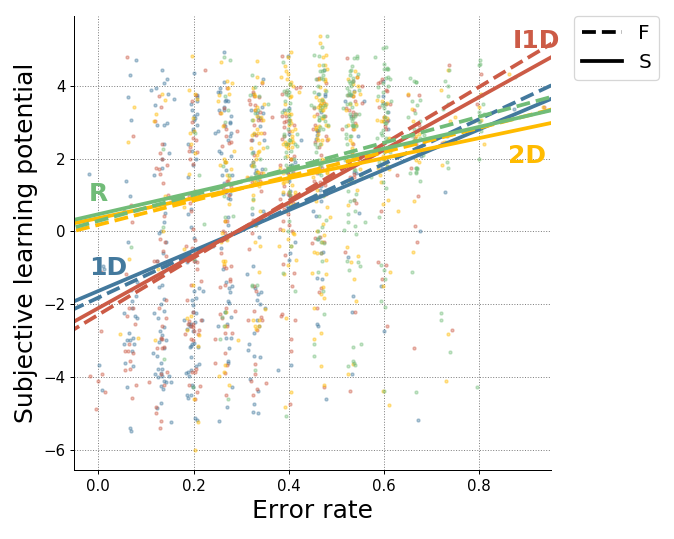

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [53]:
def f2(path, cov, item, norm=False, clip_dpc=True, figname='f2', summary=True, save=False):
    keys = 'lrn,int,comp,time,prog,rule,lrn2'.split(',')
    full = 'learning potential,interest,complexity,subjective time,progress,rule,learning potential'.split(',')
    imap = dict(zip(keys,full))
    
    df = lut.unpickle(path) 
    df.replace(dict(tid={'1D': 1, 'I1D': 2, '2D': 3, 'R': 4}), inplace=True)
    df.replace(dict(grp={'F': 0, 'S': 1}), inplace=True)
    df.replace(dict(cnd={'i-': '0_i-', 'i+': '1_i+'}), inplace=True)
    display(df.head(4))
    df.pc_first = 1 - df.pc_first
    n = 'n' if norm else ''
    df.loc[:, 'dpc'] = np.abs(df.pc1015 - df.pc05)
    df.loc[:, 'pc_first'] = df.loc[:, 'pc_first']
    if clip_dpc: df.loc[df.dpc<0, 'dpc'] = 0
    for tref in [3,2,1,0]:
        f = '{}{} ~ (pc_first) * (C(grp) + C(tid, Treatment(reference={})))'.format(n,item,tref)
        results = ols(f, data=df).fit()
        if summary: 
            display(results.summary())
            if save: 
                with open(finloc+'/'+figname+'_{}_model.txt'.format(item), 'w') as tf:
                    tf.write(results.summary().as_text())
    
    params = results.params
    fig = plt.figure(figname+'_{}-{}'.format(cov,item), figsize=[7.5,6])
    
    ax = vut.pretty(fig.add_subplot(111))
    ax.set_xlabel('Error rate' if cov=='pc' else '{}hange in % correct'.format('Positive c' if clip_dpc else 'C'), 
               fontsize=20)
    ax.set_ylabel('Subjective {}'.format(imap[item]), fontsize=20)
    for ti, tid in enumerate(df.tid.unique()):
        dtsk = df[df.tid==tid]
        meanpc = dtsk.pc_first.mean()
        meandpc = dtsk.dpc.mean()
        meangrp = (dtsk.grp == 'S').sum()/(dtsk.grp == 'S').size
        meancnd = (dtsk.cnd == '1_i+').sum()/(dtsk.cnd == '1_i+').size
        xlims = [-2, 2]
        
        for grp in [0, 1]:
            yhat = results.predict(pd.DataFrame({'pc_first': xlims,
#                                                  'dpc': [meandpc, meandpc],
                                                 'grp': [grp, grp],
                                                 'tid': [tid, tid]}))
            ax.plot(xlims, yhat.values, c=colors[ti], lw=3, label='{} / {}'.format(glabels[grp],tlabels[ti+1]),
                    ls='--' if not grp else '-')

        x = rand_jitter(dtsk.pc_first if cov=='pc' else dtsk.dpc)
        y = dtsk['{}{}'.format(n, item)] if norm else  dtsk['{}{}'.format(n, item)]
        ax.scatter(x = x, y = y, c = colors[ti], alpha=.4, 
                   s=6, zorder=2, label=None)
        
    x = df.pc_first if cov=='pc' else df.dpc
    y = df['{}{}'.format(n, item)] if norm else  df['{}{}'.format(n, item)]
    ax.set_xlim(-.05,.95)
    ax.set_ylim(vut.pad_lims(y))
    
    ax.text(-.02, .7, 'R', color=colors[3], fontsize=20, fontweight='bold', va='bottom')
    ax.text(.86, 2.4, '2D', color=colors[2], fontsize=20, fontweight='bold', va='top')
    ax.text(.87, 5.55, 'I1D', color=colors[1], fontsize=20, fontweight='bold', va='top')
    ax.text(-.02, -.69, '1D', color=colors[0], fontsize=20, fontweight='bold', va='top')
    
    solid = mpl.lines.Line2D([0],[0], color='k', lw=3, label='S')
    dashed = mpl.lines.Line2D([0],[0], color='k', lw=3, label='F', ls='--')
    ax.legend(handles=[dashed, solid], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=16)
    
    fig.tight_layout()
    
    if save: 
        save_it(fig, desktop, figname+'_{}-{}'.format(cov,item), save_as='png')
#         save_it(fig, finloc, figname+'_{}-{}'.format(cov,item), save_as='svg')

    
if 1:
    f2('pipeline_data/longdata/long3.pkl', 'pc',  'lrn', norm=True, clip_dpc=True, summary = True, save = False)
#     f2('pipeline_data/longdata/long3.pkl', 'dpc', 'lrn', norm=True, clip_dpc=True, summary = False, save = False)

### F2b: Split by NTM

In [ ]:
def f2b(path, cov, item, norm=False, clip_dpc=True, figname='f2b', summary=True, save=False):
    keys = 'lrn,int,comp,time,prog,rule,lrn2'.split(',')
    full = 'learning potential,interest,complexity,subjective time,progress,rule,learning potential'.split(',')
    imap = dict(zip(keys,full))
    
    df = lut.unpickle(path) 
    df.replace(dict(tid={'1_1D': 1, '2_I1D': 2, '3_2D': 3, '4_R': 4}), inplace=True)
    df.replace(dict(grp={'F': 0, 'S': 1}), inplace=True)
    df.replace(dict(cnd={'i-': '0_i-', 'i+': '1_i+'}), inplace=True)
    
    ntmdf = lut.unpickle('pipeline_data/clear_data/ntm_data_freeplay.pkl')[['sid','ntm']]
    df = df.merge(ntmdf, on='sid').drop_duplicates()
    del ntmdf
    df = df.loc[df.ntm >= 1, :]
    display(df.head(10))
    n = 'n' if norm else ''
    df.loc[:, 'dpc'] = df.pc05 - df.pc1015
    df.loc[:, 'pc_first'] = 1 - df.loc[:, 'pc_first']
    df.loc[:, 'pc_last'] = 1 - df.loc[:, 'pc_last']
    
    fig = plt.figure(figname, figsize=[9.5,2.7])
    
    predictors = ['Intercept','pc_first','tid','ntm']
    for tid in [1,2,3,4]:
        f = '{}{} ~ pc_first * C(ntm)'.format(n,item)
        results = ols(f, data=df.loc[df.tid==tid]).fit()
        display(results.summary())
        
        ax = vut.pretty(fig.add_subplot(1,4,tid))
        ax.set_ylim(-5, 11)
        ax.set_xlim(-.02, 1.02)
#         for grp in [0,1]:
        for ntm in [1,2,3]:
            yhat = results.predict(
                pd.DataFrame(
                    [[1,-2,tid,ntm],
                     [1,2,tid,ntm]], 
                 columns=predictors)
            )
            ax.plot([-2, 2], yhat.values, c=gcolors[0], 
                    lw=3, ls=[':','--','-'][ntm-1])
    
    fig.tight_layout()
    
    if save: 
        save_it(fig, desktop, figname+'_{}-{}'.format(cov,item), save_as='')

    
if 1:
    f2b('pipeline_data/longdata/long3.pkl', 'pc',  'lrn', norm=True, save = False)

## Hit rate across time

In [ ]:
def f3_0_2(path, figname, save_to, save_as=None, compress=False, show_raw=True, s=5, m='flat'):
    cols = 'sid,grp,trial,t0,cor'.split(',')
    df = lut.unpickle(path)[cols].set_index(['grp','trial'])
    display(df.head())

    mean_pc = df.groupby(['grp','trial'])[['cor']].mean()

    fig = plt.figure(figname, figsize=[6,5.5])
    ax = vut.pretty(fig.add_subplot(111)) 
    
    for grp in [0, 1]:
        x = mean_pc.loc[(grp, slice(None)), :].values.squeeze()
        ax.plot(vut.smooth(x, s, m), color=gcolors[grp], label=fullglabels[grp], lw=4)
        if show_raw:
            ax.plot(x, color=colors[grp], alpha=.5, lw=1)
            
        
    ax.set_xlabel('Trial', fontsize=20)
    ax.set_ylabel('Proportion correct', fontsize=20)
    
    ax.legend(fontsize=20)
    ax.set_ylim(.55,.85)
    ax.set_xlim(0,250)
    fig.tight_layout()
    if save_as:
        save_it(fig, save_to, figname, save_as=save_as, compress=False)

        
if 1:
    f3_0_2('pipeline_data/clear_data/ntm_data_freeplay.pkl',
            'f3b', save_to=desktop, save_as='png', 
            show_raw=True, s=15, m='flat')

### Hit rate across time by task

In [ ]:
def f3_0_3(path, figname, save_to, save_as=None, compress=False, show_raw=True, s=5, m='flat', lim=25):
    cols = 'sid,grp,trial,t0,cor,st1,st2,st3,st4,loc_pc1,loc_pc2,loc_pc3,loc_pc4,ntm'.split(',')
    df = lut.unpickle(path)[cols]
    df = df.loc[df.ntm==3, :]
    display(df.head())
    
    fig = plt.figure(figname, figsize=[7,5])
    
    ax = vut.pretty(fig.add_subplot(111))
    rdata = {'sid': [], 'grp': [], 'tid': [], 'pc1': []}
    for tid in [1,2,3,4]:
        
        for grp in [0, 1]:
            data = df.loc[(df.grp==grp) & (df.t0==tid)]
            nbs = data.sid.unique().size
            
            a = np.zeros([nbs, 250])
            b = np.full([nbs, 250], np.nan)
            for i, (_, sdf) in enumerate(data.groupby('sid')):
                nbt = sdf.shape[0]
                a[i, :nbt] = 1
                cor = sdf.cor.values
                b[i, :nbt] = np.cumsum(cor) / np.arange(1, nbt+1)
                rdata['sid'].append(sdf.sid.values[0])
                rdata['grp'].append(grp)
                rdata['tid'].append(tid)
                rdata['pc1'].append(np.nanmean(b[i, :25]))
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                a = np.mean(a, axis=0)
                err = scs.sem(b, axis=0, nan_policy='omit')
                b = np.nanmean(b, axis=0)
#                 ax.plot(a, ls='--', color=gcolors[grp], label='% selection, {}'.format(fullglabels[grp]))
                ax.plot(b[:lim], color=colors[tid-1], label='{} / {}'.format(glabels[grp], tlabels[tid]),
                        ls = '--' if not grp else '-', lw=3)
                ax.fill_between(np.arange(250)[:lim], (b+err)[:lim], (b-err)[:lim], 
                                color=colors[tid-1], alpha=.3)
            if grp:
                ax.text(25.2, b[lim], tlabels[tid], color=colors[tid-1], fontsize=20, fontweight='bold', va='top')

        ax.set_xlabel('Number of trials on task', fontsize=20)
        ax.set_ylabel('Mean moving hit rate', fontsize=20)
        ax.set_ylim(.45,.9)
        ax.set_xlim(0, 27)
    solid = mpl.lines.Line2D([0],[0], color='k', lw=3, label='S')
    dashed = mpl.lines.Line2D([0],[0], color='k', lw=3, label='F', ls='--')
#     ax.legend(handles=[dashed, solid], fontsize=16, bbox_to_anchor=[1.02, 1], loc='upper left')
    ax.legend(handles=[dashed, solid], fontsize=16)
#     ax.text(2,.86, 'Free play', fontsize=25, fontweight='bold', va='bottom')
    fig.tight_layout()
    rdata = pd.DataFrame(rdata).sort_values(by='sid')
    rdata.to_csv('pipeline_data/clear_data/long_ntm_data_freeplay.csv')
    if save_as:
        save_it(fig, save_to, figname, save_as=save_as, compress=False)

        
if 1:
    f3_0_3('pipeline_data/clear_data/ntm_data_freeplay.pkl',
            'f3c', save_to=desktop, save_as='png', 
            show_raw=False, s=15, m='flat', lim=26)

# Task choices

### Overall

In [ ]:
def f4(path, good_order=True, figname='f1h', save_as=''):
    cols = ['st1','st2','st3','st4']
    df = lut.unpickle(path)
    df = df.set_index(['grp','sid','trial']).loc[:, cols]
    props = df.groupby(['grp']).mean()
    
    display(props)
       
    fig = plt.figure(figname, figsize=[6, 5.5])
    ax = vut.pretty(fig.add_subplot(111), 'y')
    for grp in [0, 1]:
        x = [1,2,3,4]
        y = props.loc[grp, :]
        ax.plot(x, y, color=gcolors[grp], label=fullglabels[grp], lw=6)
        
    xTickMarks = [tlabels[tsk] for tsk in [1,2,3,4]]
    ax.set_xticks([1,2,3,4])
    xtickNames = ax.set_xticklabels(xTickMarks)
    
    ax.set_ylabel('Proportion of trials', fontsize=20)
    ax.set_xlabel('Task', fontsize=20)
    ax.set_ylim(0.1, 0.4)
            
    ax.legend(fontsize=20)
    fig.tight_layout()
    
    if save_as:
        save_it(fig, desktop, figname, save_as=save_as, compress=False)

if 1:
    f4('pipeline_data/clear_data/ntm_data_freeplay.pkl',
        good_order = True,
        figname='f2a', 
        save_as='png')

### Across time (split by group)

In [ ]:
def f4_0_1(path, figname, save_to, save_as=None, compress=False):
    mdata = lut.unpickle(path)['main']

    sids, groups, conds, tasks = lut.get_unique(mdata, [r.ix('sid'), 
                                                        r.ix('group'),
                                                        r.ix('cond'),
                                                        r.ix('cat')])

    freeplay = lut.get_mask(mdata, {r.ix('stage'): 1})
    mdata = mdata[freeplay, :]
    mdata[:, r.ix('trial')] -= 60
    first250 = lut.get_mask(mdata, {r.ix('trial'): 250}, '<=')
    mdata = mdata[first250, :]
    
    
   
    for grp in groups:
        fig = plt.figure(figname+str(grp), figsize=[6,5])
        gmask = lut.get_mask(mdata, {r.ix('group'): grp})
        gsids = lut.get_unique(mdata[gmask, :], r.ix('sid'))
        
        ax = vut.pretty(fig.add_subplot(111))
#         txt = ax.text(.05, .95, fullglabels[grp], ha='left', va='top', 
#                         transform = ax.transAxes)
#         txt.set_fontsize(12)
        psels = []
        for i, tsk in enumerate(tasks):
            tmask = np.array([mdata[gmask, r.ix('cat')] == tsk]).reshape([gsids.size, -1])
            psel = np.sum(tmask, axis=0) / gsids.size
            psels.append(psel)
            ax.plot(psel, c=colors[i], label=tlabels[tsk], lw=3)
            
            ax.set_xlim(1,250)
            ax.set_ylim(.08,.5)

            ax.set_ylabel('Selection proportion', fontsize=20)
            ax.legend(bbox_to_anchor=(0,1,1,0.2), loc='lower left', mode='expand', ncol=4, fontsize=15)
            ax.grid(True)
            ax.set_xlabel('Trial', fontsize=20)
        fig.tight_layout()

        if save_as:
            save_it(fig, save_to, figname+str(grp), save_as=save_as, compress=False)

if 1:
    f4_0_1(path = 'pipeline_data/s3/joint_data.pkl',
         figname = 'paper_f3_a', 
         save_to=desktop, 
         save_as='png')

### Across time (split by NTM)

In [ ]:
def f4_0_3(path, figname, save_to, save_as=None, compress=False):
    cols = 'sid,grp,ntm,trial,t0,st1,st2,st3,st4'.split(',')
    df = lut.unpickle(path)[cols].set_index(['grp','ntm', 'trial'])
    display(df.head())
    fig = plt.figure(figname, figsize=[9,8])
    gs = mpl.gridspec.GridSpec(4,3)
   
    for grp in [0,1]:
        a = df.loc[(grp, slice(None), slice(None)), 'st1':'st4'].groupby('trial').mean()
        ax = vut.pretty(fig.add_subplot(gs[0, grp]))
        ax.set_ylim(0, 0.6)
        ax.set_xlim(0, 250)
        txt = ax.text(.05, .95, fullglabels[grp], ha='left', va='top', 
                        transform = ax.transAxes)
        if not grp: ax.set_ylabel('% task selection')
        for tsk in [1,2,3,4]:
                ax.plot(a.loc[:, 'st{}'.format(tsk)], color=colors[tsk-1])
        
        for ntm in [1,2,3]:
            a = df.loc[(grp, ntm, slice(None)), 'st1':'st4'].groupby('trial').mean()
            
            ax = vut.pretty(fig.add_subplot(gs[ntm, grp]))
            ax.set_ylim(0, 0.6)
            ax.set_xlim(0, 250)
            txt = ax.text(.05, .95, '{}-NTM-{}'.format(glabels[grp], ntm), ha='left', va='top', 
                        transform = ax.transAxes)
            if not grp: ax.set_ylabel('% task selection')
            lines = []
            for tsk in [1,2,3,4]:
                line, = ax.plot(a.loc[:, 'st{}'.format(tsk)], color=colors[tsk-1])
                lines.append(line)
            if ntm==3: ax.set_xlabel('Trial number')
            
            
            if grp:
                a = df.loc[(slice(None), ntm, slice(None)), 'st1':'st4'].groupby('trial').mean()
                ax = vut.pretty(fig.add_subplot(gs[ntm, 2]))
                ax.set_ylim(0, 0.6)
                ax.set_xlim(0, 250)
                txt = ax.text(.05, .95, 'NTM-{}'.format(ntm), ha='left', va='top', 
                        transform = ax.transAxes)
                if ntm==3: ax.set_xlabel('Trial number')
                for tsk in [1,2,3,4]:
                        ax.plot(a.loc[:, 'st{}'.format(tsk)], color=colors[tsk-1])
                
    ax = fig.add_subplot(gs[0, 2])
    plt.axis('off')
    ax.legend(lines, list(tlabels.values()), bbox_to_anchor=[0,0], loc='lower left')
        
    fig.tight_layout()
    
    if save_as:
        save_it(fig, save_to, figname, save_as=save_as, compress=False)


if 1:
    f4_0_3(path = 'pipeline_data/clear_data/ntm_data_freeplay.pkl',
         figname = 'f403', 
         save_to=finloc, 
         save_as='png')

### LP-aligned

In [ ]:
def f_3_0_4_prep(path, alpha=12):
    # Create empty data dict
    data = {'cur': {}, 'rand': {}, 'other': {}, 'sc': {}}
    for k, v in data.items():
        for grp in (0, 1):
            v[grp] = {}
            for ntm in (1, 2, 3):
                v[grp][ntm] = {}
                for lp in range(1, ntm+1):
                    v[grp][ntm][lp] = []

    # Load data
    df = lut.unpickle(path).set_index(['sid'])
    df = df.loc[df.trial<=310, :]
    choices = pd.get_dummies(df.t0)
    prog = wg.IntProgress(value=0, min=0, max=df.index.unique().shape[0], step=1, bar_style='warning')
    display(df.head())
    display(prog)
    
    # Fill data dict with lp-aligned vectors
    nanbox = np.full(250, np.nan)
    crit1, crit2 = alpha/15, lut.p_val(15, alpha, .5)
    for i, sdf in df.groupby('sid'):
        prog.value = prog.value + 1
        if i>=0:
#             display(sdf.head(15))
            # Group
            grp = sdf.head(1).loc[:, 'grp'].values[0]
            
            # LPs and NTM
            crit_pc = sdf.loc[:, 'loc_pc1':'loc_pc3'] > crit1
            crit_pval = sdf.loc[:, 'loc_p1':'loc_p3'] <= crit2
            learned = crit_pc.values & crit_pval.values
            
            lps = np.argmax(learned, axis=0)
            ntm = lps.astype(bool).sum()
            if not ntm: continue
            
            lps[lps==0] = 310
            lps -= 60
            lps[lps<0] = 0
            
            for lp, (tid, t) in enumerate(zip(np.argsort(lps)[:ntm]+1, np.sort(lps)[:ntm]), 1):
                sdata = nanbox.copy()
                sdata[:250-t] = choices.loc[i, tid].values[60+t:]
                data['cur'][grp][ntm][lp].append(sdata)
                
                sdata = nanbox.copy()
                sdata[:250-t] = choices.loc[i, 4].values[60+t:]
                data['rand'][grp][ntm][lp].append(sdata)
                
                others = [1,2,3,4]; others.pop(tid)
                
                other1 = nanbox.copy()
                other1[:250-t] = choices.loc[i, others[0]].values[60+t:]
                other2 = nanbox.copy()
                other2[:250-t] = choices.loc[i, others[1]].values[60+t:]
                sdata = other1 + other2
                data['other'][grp][ntm][lp].append(sdata)
                
                sdata = nanbox.copy()
                sdata[:250-t] = sdf.loc[i, 'alt_sc'].values[60+t:]
                data['sc'][grp][ntm][lp].append(sdata)
    
    for k in data.keys():
        for ntm in (1, 2, 3):
            for lp in range(1, ntm+1):
                for grp in (0, 1):
                    data[k][grp][ntm][lp] = np.stack(data[k][grp][ntm][lp], axis=0)
    
    prog.bar_style='success'        
    return data


def f_3_0_4_visualize(data, window=5, smooth=False, truncate=250, figname='f4_0_4', save_as=''):
    fig = plt.figure(figname, figsize=[18, 8]) # Full size = 18 x 8 
    ntm_pos = {1:0,2:1,3:3}
    ylabels = {
        'cur': '% selected\ncurrent task',
        'rand': '% selected\nR task',
        'other': '% selected\nother tasks',
        'sc': 'Mean\nSC',
    }
    
    # Arrange subolots layout, labels, dividers etc.
    subplots = {}
    gs = mpl.gridspec.GridSpec(4, 6)
    keys = ['cur', 'rand', 'other', 'sc']
    
    for i, k in enumerate(keys):
        subplots[k] = {}
        for ntm in (1, 2, 3):
            if not i:
                if ntm == 1: hax = fig.add_subplot(gs[0:, 0])
                elif ntm == 2: hax = fig.add_subplot(gs[0:, 1:3])
                elif ntm == 3: hax = fig.add_subplot(gs[0:, 3:])
                hax.set_title('{}\nmastered'.format(['1 task','2 tasks','3 tasks'][ntm-1]), 
                              fontsize=20, pad=20)
                hax.set_xticks([])
                hax.set_yticks([])
                hax.spines['right'].set_visible(False)
                hax.spines['top'].set_visible(False)
                hax.spines['bottom'].set_visible(False)
                hax.spines['left'].set_visible(False)  
            
            subplots[k][ntm] = {}
            for lp in range(1, ntm+1):
                ax = vut.pretty(fig.add_subplot(gs[i, ntm_pos[ntm] + lp-1]))
                ax.set_ylim(0, 1)
                ax.set_xlim(0, truncate)
                
                # change major ticks
                ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(25))
                ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(.5))

                # change minor ticks
                ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
                ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(.25))

                # turn grid on for both major and minor ticks and style minor slightly differently.
                ax.grid(which='major', color='gray', linestyle=':', lw=1.2, zorder=0)
                ax.grid(axis='y',which='minor', color='gray', linestyle=':', alpha=.5, zorder=0)
                ax.minorticks_on()
                
                subplots[k][ntm][lp] = ax
                if ntm >1:
                    ax.tick_params(labelleft=False)
                if (ntm == lp) and ntm !=3 and k=='sc':
                    trans = mpl.transforms.blended_transform_factory(ax.transAxes, fig.transFigure)
                    line = mpl.lines.Line2D([1.1, 1.1], [.12, .9], color='#303030', 
                                            lw=4, transform=trans, solid_capstyle='round')
                    fig.lines.append(line)
            
            # Labels, legends
            if ntm==1: ax.set_ylabel(ylabels[k], fontsize=15)
            if lp == ntm and ntm==3 and k=='cur':
                blue = mpl.lines.Line2D([0],[0], color=gcolors[0], lw=3, label='F')
                red = mpl.lines.Line2D([0],[0], color=gcolors[1], lw=3, label='S')
                ax.legend(handles=[blue, red], bbox_to_anchor=(1.05, 1), loc=2, 
                          borderaxespad=0., fontsize=16)
                
    
    # Plot data
    prog = wg.IntProgress(value=0, min=0, max=4*6*2, step=1, bar_style='warning')
    display(prog)
    for row, k in enumerate(keys):
        for ntm in (1, 2, 3):
            for lp in range(1, ntm+1):
                for grp in (0, 1):
                    smoothed = pd.DataFrame(data[k][grp][ntm][lp]).T.rolling(15, min_periods=1).mean().T.values[:, :truncate]
                    x = np.arange(smoothed.shape[1])
                    y = np.nanmean(smoothed, axis=0)
                    yerr = scs.sem(smoothed, axis=0, nan_policy='omit')
                    subplots[k][ntm][lp].plot(x, y, color=gcolors[grp], zorder=4)
                    subplots[k][ntm][lp].fill_between(x, y+yerr, y-yerr, color=gcolors[grp], alpha=.4, zorder=4)
                    
                    prog.value += 1
    
    hax = fig.add_subplot(111, frameon=False)
    hax.set_xticks([])
    hax.set_yticks([])
    hax.spines['right'].set_visible(False)
    hax.spines['top'].set_visible(False)
    hax.spines['bottom'].set_visible(False)
    hax.spines['left'].set_visible(False)
    hax.set_xlabel('Trials', fontsize=14)
    hax.xaxis.set_label_coords(.5, -0.1)
    
    prog.bar_style='success'
    fig.tight_layout()
    if save_as:
        sd = desktop+'/{}.{}'.format(figname, save_as)
        fig.savefig(sd, format=save_as, dpi=200)


if 1:
#     d = f_3_0_4_prep('pipeline_data/clear_data/trials_data_w15.pkl', alpha = 12)
    f_3_0_4_visualize(d, window=5, truncate=100, save_as='png')

## Visualizing one subject

,grp,cnd,stage,trial,t0,t1,switch,cor,pc1,pc2,pc3,pc4,p1,p2,p3,p4,loc_pc1,loc_pc2,loc_pc3,loc_pc4,loc_p1,loc_p2,loc_p3,loc_p4,sc,loc_sc,alt_sc
sid,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,1,3,3,NaN,0,NaN,NaN,0.00,NaN,NaN,NaN,0.50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0,0,0,2,3,3,NaN,0,NaN,NaN,0.00,NaN,NaN,NaN,0.25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0,0,0,3,3,3,NaN,0,NaN,NaN,0.00,NaN,NaN,NaN,0.12500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0,0,0,4,3,3,NaN,1,NaN,NaN,0.25,NaN,NaN,NaN,0.25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0,0,0,5,3,3,NaN,0,NaN,NaN,0.20,NaN,NaN,NaN,0.15625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>


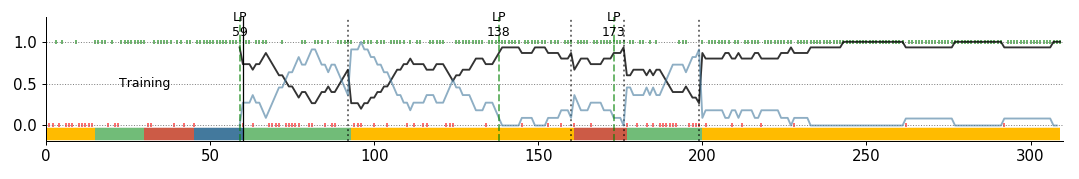

NTM = 3


<IPython.core.display.Javascript object>


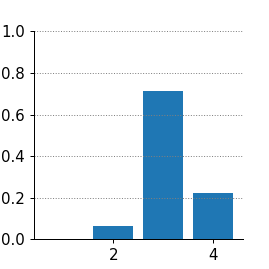

[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [23]:
def f4_1(path, sid=1, figname='one_subj', save_as=''):
    def get_lps(df, **kwargs):
        arr = df.values
        mask = (arr != 0)
        arr = np.where(mask.any(axis=0), mask.argmax(axis=0), kwargs['invalid_val'])
        return pd.Series(arr, dtype=kwargs['dtype'])
    
#     # Set the columns to keep
#     p_str, pc_str , sc_str= 'loc_p', 'loc_pc', 'alt_sc'
#     tasks = [1,2,3]
#     cols = ['grp', 'trial', 't0','sc','loc_sc','alt_sc','cor']
#     cols += [p_str+str(t) for t in tasks]+[pc_str+str(t) for t in tasks]
    
    # Load data, filter free play trials plus the last training trial
    df = lut.unpickle(path).set_index(['sid'])
    df = df.loc[sid, :]
    display(df.head())
    
    fig = plt.figure(figname, figsize=[12,2])
    ax = vut.pretty(fig.add_subplot(111), 'y')
    ax.set_ylim(-.18, 1.3)
    ax.set_xlim(0,310)
    ax.set_label('Trial number')
    inds = np.arange(df.shape[0])
    
    # Task choices
    tskv = df.loc[:, 't0'].values-1
    ypos = np.zeros_like(tskv)
    cmap = mpl.colors.ListedColormap(colors)
    norm = mpl.colors.BoundaryNorm(range(5), cmap.N)
    points = np.array([inds, ypos-.1]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc_act = mpl.collections.LineCollection(segments, cmap=cmap, norm=norm, linewidth=10)
    lc_act.set_array(tskv)
    ax.add_collection(lc_act)

    # Hits and misses
    hits = df.loc[:, 'cor'].values
    misses = (~hits.astype(bool)).astype(int)
    ax.scatter(inds[hits.astype(bool)], hits[hits.astype(bool)], color='green', marker='|', alpha=.6, s=8)
    ax.scatter(inds[misses.astype(bool)], hits[misses.astype(bool)], color='red', marker='|', alpha=.6, s=8)

    # Switches
    switches = df.loc[:, 'switch'].values.astype(bool)
    switches[:60] = False
    switches[-1] = False
    switch_trials = inds[switches]
    for t in switch_trials:
        ax.axvline(t, ls=':', color='k', alpha=.6)
        
    # Performance & Self-challenge
    pcs = df.loc[:, 'loc_pc1':'loc_pc4'].values
    sc = df.loc[:, 'alt_sc'].values
    mask = pd.get_dummies(tskv).values.astype(bool)
    ax.plot(pcs[mask], color='k', alpha=.8)
    ax.plot(sc, color=colors[0], alpha=.6)
    
    # Learning points
    tasks = [1,2,3]
    crit_pval = df.loc[:, 'loc_p1':'loc_p3'] <= lut.p_val(15, 12, .5)
    crit_pc = df.loc[:, 'loc_pc1':'loc_pc3'] > 12/15
    crit_pval.columns, crit_pc.columns = tasks[:], tasks[:]
    learned = crit_pc & crit_pval
    rename_dict = {0:'lp1', 1:'lp2', 2:'lp3'}
    lps = get_lps(learned, invalid_val=np.nan, dtype='int')
    lps = lps[~np.isnan(lps)]
    for lp in lps:
        ax.axvline(lp, color='green', ls='--', alpha=.6)
        
    # Labels
    ax.text(30, .5, 'Training', ha='center', va='center')
    for i, lp in enumerate(sorted(lps.values.tolist())):
        ax.text(lp, 1.2, 'LP\n{}'.format(int(lp)), ha='center', va='center')
    ax.axvline(60, c='k', lw=1)
    
    # Print NTM
    print('NTM = {}'.format(learned.values.any(axis=0).sum()))
    
    fig.tight_layout()
    if save_as:
        sd = desktop+'/{}.{}'.format(figname, save_as)
        fig.savefig(sd, format=save_as, dpi=200)

    fig = plt.figure('add', figsize=[3,3])
    ax = vut.pretty(fig.add_subplot(111), 'y')
    tskv = (df.loc[:, 't0'].values).astype(int)[61:]
    print(tskv)
    a = np.zeros([tskv.size, 4])
    a[np.arange(tskv.size), (tskv-1).astype(int)] = 1
    ax.set_ylim(0, 1)
    ax.bar([1,2,3,4], a.mean(axis=0))
    
if 1:
    alpha = 100
    alphastr = str(alpha)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        f4_1('pipeline_data/clear_data/trials_data2.pkl',
            sid=0,
            figname='one_subj', 
            save_as='')

# Post-play questions

### 4A: Descriptive analyses (split by group and condition)

In [ ]:
def f4a(path, items, norm=False, figname='4a', save=False):
    keys = 'lrn,int,comp,time,prog,rule,lrn2'.split(',')
    if norm:
        items = ['n'+s for s in items]
        keys = ['n'+k for k in keys]
    full = 'learning potential,interest,complexity,subjective time,progress,rule,learning potential'.split(',')
    imap = dict(zip(keys,full))
    
    df = lut.unpickle(path) 
    df.replace(dict(tid={'1D': '1_1D', 'I1D': '2_I1D', '2D': '3_2D', 'R': '4_R'}), inplace=True)
    
    for item in items:
        gmean = df.groupby(['grp'])[item].mean()
        gsem = df.groupby(['grp'])[item].sem()

        cmean = df.groupby(['cnd'])[item].mean()
        csem = df.groupby(['cnd'])[item].sem()

        tmean = df.groupby(['tid'])[item].mean()
        tsem = df.groupby(['tid'])[item].sem()

        split3mean = df.groupby(['grp','cnd','tid'])[item].mean()
        split3sem = df.groupby(['grp','cnd','tid'])[item].sem()

        fignameitem = figname + '_{}'.format(item)
        fignameitem += '_norm' if norm else ''
        fig = plt.figure(num=fignameitem, figsize=[8,8])

        width = .9
        lmin = min(min(gmean+gsem), min(cmean+csem))
        lmax = max(max(gmean+gsem), max(cmean+csem))
        smax = max(gsem*2)

        plt.subplot(221)
        plt.ylim(lmin-3*smax, lmax+3*smax)
        plt.grid(linestyle=':', zorder=0, axis='y')
        plt.xticks([1,2,4,5], ['F','S','i-','i+'])
        plt.xlabel('Group / Condition')
        plt.ylabel('Mean rating of\n{}'.format(imap[item]))
        vut.despine(plt.gca())
        
        print(gmean)
        plt.bar([1, 2], gmean, width=width, fc=gcolors[0], zorder=2)
        plt.errorbar([1, 2], gmean, yerr=gsem, c='k', zorder=3, ls='', capsize=6)

        plt.bar([4, 5], cmean, width=width, fc=gcolors[0], zorder=2)
        plt.errorbar([4, 5], cmean, yerr=csem, c='k', zorder=3, ls='', capsize=6)


        plt.subplot(222)
        plt.grid(linestyle=':', zorder=0, axis='y')
        plt.xticks([1,2,3,4], tlabels.values())
        vut.despine(plt.gca())
        plt.xlabel('Task')
        plt.ylabel('Mean rating of\n{}'.format(imap[item]))
        plt.errorbar([1,2,3,4], tmean, yerr=tsem, capsize=5)

        plt.subplot(212)
        plt.grid(linestyle=':', zorder=0, axis='y')
        plt.xticks([1,2,3,4], tlabels.values())
        vut.despine(plt.gca())
        plt.xlabel('Task')
        plt.ylabel('Mean rating of\n{}'.format(imap[item]))

        js = .02
        jit = np.array([-2*js, -js, 0, js])
        xpos = np.array([1,2,3,4])
        for gi, grp in enumerate(split3mean.index.levels[0]):
            for ci, cnd in enumerate(split3mean.index.levels[1]):
                plt.errorbar(
                    x = xpos+jit[gi + 1*ci], 
                    y = split3mean[grp,cnd].values, 
                    yerr = split3sem[grp,cnd].values, 
                    capsize=5, label='{} / {}'.format(fullglabels[gi], fullclabels[ci]),
                    c = gcolors[gi], ls = '-' if ci else '--')
        plt.legend()#(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        fig.tight_layout()

        if save: 
            save_it(fig, finloc, fignameitem, save_as='png')
            save_it(fig, finloc, fignameitem, save_as='svg')


if 1:
    items = 'lrn,int,comp,time,prog,rule,lrn2'.split(',')
    items = ['lrn']
    f4a('pipeline_data/longdata/long2.pkl', items=items, norm=True, figname = 'f4a', save = False) 

### 4B: Progress / Learnability 2 and PC, dPC

In [ ]:
def f4b(path, cov, item, norm=False, clip_dpc=True, figname='f4b', summary=True, save=False):
    keys = 'lrn,int,comp,time,prog,rule,lrn2'.split(',')
    full = 'learning potential,interest,complexity,subjective time,progress,rule,learning potential'.split(',')
    imap = dict(zip(keys,full))
    
    df = lut.unpickle(path) 
    df.replace(dict(tid={'1D': '1_1D', 'I1D': '2_I1D', '2D': '3_2D', 'R': '4_R'}), inplace=True)
    df.replace(dict(cnd={'i-': '0_i-', 'i+': '1_i+'}), inplace=True)
    
    n = 'n' if norm else ''
    if not clip_dpc: df.loc[:, 'dpc'] = df.pc_last - df.pc_first
    f = ('{}{} ~ (pc_grand + dpc) * (C(grp) + C(cnd) + C(tid))'.format(n,item))
    results = ols(f, data=df).fit()
    if summary: 
        print(results.summary())
        if save: 
            with open(finloc+'/'+figname+'_{}_model.txt'.format(item), 'w') as tf:
                tf.write(results.summary().as_text())
    
    params = results.params
    fig = plt.figure(figname+'_{}-{}'.format(cov,item), figsize=[8,5])
    
    plt.subplot(111)
    plt.grid(ls=':', zorder=0)
    plt.xlabel('% correct' if cov=='pc' else '{}hange in % correct'.format('Positive c' if clip_dpc else 'C'))
    plt.ylabel('Subjective {}'.format(imap[item]))
    vut.despine(plt.gca())
    for ti, tid in enumerate(df.tid.unique()):
        dtsk = df[df.tid==tid]
        meanpc = dtsk.pc_grand.mean()
        meandpc = dtsk.dpc.mean()
        meangrp = (dtsk.grp == 'S').sum()/(dtsk.grp == 'S').size
        meancnd = (dtsk.cnd == '1_i+').sum()/(dtsk.cnd == '1_i+').size

        intercept = (params['Intercept'] + 
                     params['C(grp)[T.S]']*meangrp + 
                     params['C(cnd)[T.1_i+]']*meancnd +
                     (params['C(tid)[T.{}]'.format(tid)] if bool(ti) else 0))
        y = []
        xlims = [-2,2]
        for x in xlims:
            pcvar = (params['pc_grand']*x + 
                     params['pc_grand:C(grp)[T.S]']*meangrp*x + 
                     params['pc_grand:C(cnd)[T.1_i+]']*meancnd*x +
                     (params['pc_grand:C(tid)[T.{}]'.format(tid)]*x if bool(ti) else 0))
            dpcvar = (params['dpc']*x +
                     params['dpc:C(grp)[T.S]']*meangrp*x + 
                     params['dpc:C(cnd)[T.1_i+]']*meancnd*x +
                     (params['dpc:C(tid)[T.{}]'.format(tid)]*x if bool(ti) else 0))
            pcmarg = (params['pc_grand']*meanpc + 
                     params['pc_grand:C(grp)[T.S]']*meangrp*meanpc + 
                     params['pc_grand:C(cnd)[T.1_i+]']*meancnd*meanpc +
                     (params['pc_grand:C(tid)[T.{}]'.format(tid)]*meanpc if bool(ti) else 0))
            dpcmarg = (params['dpc']*meandpc +
                     params['dpc:C(grp)[T.S]']*meangrp*meandpc + 
                     params['dpc:C(cnd)[T.1_i+]']*meancnd*meandpc +
                     (params['dpc:C(tid)[T.{}]'.format(tid)]*meandpc if bool(ti) else 0))
            lincomb = (pcvar + dpcmarg if cov == 'pc' else (dpcvar + pcmarg))
            y.append(intercept + lincomb)

        plt.plot(xlims, y, c=colors[ti], alpha=.7)

        x = dtsk.pc_grand if cov=='pc' else rand_jitter(dtsk.dpc)
        y = dtsk['{}{}'.format(n, item)] if norm else  dtsk['{}{}'.format(n, item)]
        plt.scatter(x = x, y = y,
                    c = colors[ti], alpha=.5, s=6,
                    label = tlabels[ti+1], zorder=2,)
        
    x = df.pc_grand if cov=='pc' else rand_jitter(df.dpc)
    y = df['{}{}'.format(n, item)] if norm else  df['{}{}'.format(n, item)]
    plt.xlim(vut.pad_lims(x))
    plt.ylim(vut.pad_lims(y))

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    fig.tight_layout()
    
    if save: 
        save_it(fig, finloc, figname+'_{}-{}'.format(cov,item), save_as='png')
        save_it(fig, finloc, figname+'_{}-{}'.format(cov,item), save_as='svg')

    
if 1:
    save = False
    f4b('pipeline_data/longdata/long2.pkl', 'pc',  'prog', norm=True, summary = True, save = save)
    f4b('pipeline_data/longdata/long2.pkl', 'dpc', 'prog', norm=True, summary = False, save = save)

    f4b('pipeline_data/longdata/long2.pkl', 'pc',  'lrn2', norm=True, summary = True, save = save)
    f4b('pipeline_data/longdata/long2.pkl', 'dpc', 'lrn2', norm=True, summary = False, save = save)

### 4C: Interest as a function of time spent

In [ ]:
def f4c(path, item, norm=False, clip_dpc=True, figname='f4c', summary=True, save=False):
    df = lut.unpickle(path)
    df.set_index('sid', inplace=True)

    df.replace(dict(tid={'1D': '1_1D', 'I1D': '2_I1D', '2D': '3_2D', 'R': '4_R'}), inplace=True)
    df.replace(dict(cnd={'i-': '0_i-', 'i+': '1_i+'}), inplace=True)
    
    n = 'n' if norm else ''
    if not clip_dpc: df.loc[:, 'dpc'] = df.pc_last - df.pc_first
    f = '{}int ~ (pc_grand + dpc + nlrn + nrule + ntime) * (C(grp) + C(tid))'.format(n)
    results = ols(f, data=df).fit()
    
    if summary: 
        print(results.summary())
        if save: 
            with open(finloc+'/'+figname+'model.txt', 'w') as tf:
                tf.write(results.summary().as_text())
    
    params = results.params
    fig = plt.figure(figname, figsize=[7,7])
    
    nint_hat = []
    tasks = df.tid.unique()
    varnames = 'Intercept,pc_grand,dpc,nlrn,nrule,ntime,grp,tid'.split(',')
    df['Intercept'] = 1
    df['nint_hat'] = results.predict(df.loc[:, varnames])
    df['resid'] = df['nint'] - df['nint_hat']

    newvar = 'nprog'
    for gi, grp in enumerate('FS'):
        for ti, tid in enumerate(df.tid.unique()):
            dtsk = df[(df.grp==grp) & (df.tid==tid)]
            r, p = pearsonr(dtsk[newvar], dtsk['resid'])
            print('{}, {}: r = {}, p = {}'.format(grp, tid, round(r,3), round(p,4)))

    for gi, grp in enumerate('FS'):
        # Scatterplots
        plt.subplot2grid((2, 2), (1, gi))
        plt.grid(ls=':', zorder=0)
        plt.xlabel('Residual variation')
        plt.ylabel(newvar)
        vut.despine(plt.gca())

        dtsk = df[(df.grp==grp)]
        x = dtsk['resid']
        y = dtsk[newvar]
        r, p = pearsonr(x, y)
        plt.scatter(x = x, y = y,
                    c = gcolors[gi], alpha=.7, s=8,
                    label = glabels[gi], zorder=2,)            


        plt.title('\n r = {}, p = {}'.format(round(r,3), round(p,3)))
        plt.xlim([-8,8])
        plt.ylim(-7,7)
        
        # Histograms
        plt.subplot2grid((2, 2), (0, gi))
        plt.grid(ls=':', zorder=0)
        plt.xlabel('Residual variation')
        plt.ylabel('Frequency')
        vut.despine(plt.gca())

        r, p = pearsonr(x, y)
        plt.hist(x, bins=60, color = gcolors[gi], zorder=2)
        plt.xlim([-8,8])
        plt.ylim([0,32])
        plt.title(fullglabels[gi])
            
    fig.tight_layout()
    
    if save: 
        save_it(fig, finloc, figname+'_'+newvar, save_as='png')
        save_it(fig, finloc, figname+'_'+newvar, save_as='svg')

    
if 1:
    f4c('pipeline_data/longdata/long2.pkl', 'int', norm=True, summary = False, save = False)

### 4D: Descriptive analyses (split by group and NTM)

In [ ]:
def f4d(path, ntm_path, items, norm=False, figname='4d', save=False):
    keys = 'lrn,int,comp,time,prog,rule,lrn2'.split(',')
    if norm:
        items = ['n'+s for s in items]
        keys = ['n'+k for k in keys]
    full = 'learning potential,interest,complexity,subjective time,progress,rule,learning potential'.split(',')
    imap = dict(zip(keys,full))
    
    df = lut.unpickle(path).set_index('sid')
    df.replace(dict(tid={'1D': '1_1D', 'I1D': '2_I1D', '2D': '3_2D', 'R': '4_R'}), inplace=True)
    
    ntmdf = lut.unpickle(ntm_path).set_index('sid').loc[:, ('lp1','lp2','lp3','ntm')].drop_duplicates()
    lpord = ntmdf.loc[:, 'lp1':'lp3'].rank(axis=1, method='first').astype(int)
    good_ord = pd.Series((lpord.iloc[:, 0]==1) & (lpord.iloc[:, 1]==2) & (lpord.iloc[:, 2]==3)).rename('good_ord')
    ntmdf = ntmdf.join(good_ord)
    
    df = df.merge(ntmdf.reset_index(), on='sid')
    df = df.loc[df.ntm > 0]
    df = df.loc[df.good_ord == True]
#     df.to_csv('pipeline_data/clear_data/long_ntm_data.csv')
    for item in items:
        gmean = df.groupby(['grp'])[item].mean()
        gsem = df.groupby(['grp'])[item].sem()

        cmean = df.groupby(['ntm'])[item].mean(); print(cmean)
        csem = df.groupby(['ntm'])[item].sem()

        tmean = df.groupby(['tid'])[item].mean()
        tsem = df.groupby(['tid'])[item].sem()

        split3mean = df.groupby(['grp','ntm','tid'])[item].mean()
        split3sem = df.groupby(['grp','ntm','tid'])[item].sem()

        fignameitem = figname + '_{}'.format(item)
        fignameitem += '_norm' if norm else ''
        fig = plt.figure(num=fignameitem, figsize=[9.5,8])

        width = .9
        lmin = min(min(gmean+gsem), min(cmean+csem))
        lmax = max(max(gmean+gsem), max(cmean+csem))
        smax = max(gsem*2)

        plt.subplot(221)
        plt.ylim(lmin-3*smax, lmax+3*smax)
        plt.grid(linestyle=':', zorder=0, axis='y')
        plt.xticks([1,2,4,5,6], ['F','S','1','2','3'])
        plt.xlabel('Group / NTM')
        plt.ylabel('Mean rating of\n{}'.format(imap[item]))
        vut.despine(plt.gca())
        
        print(gmean)
        plt.bar([1, 2], gmean, width=width, fc=gcolors[0], zorder=2)
        plt.errorbar([1, 2], gmean, yerr=gsem, c='k', zorder=3, ls='', capsize=6)

        plt.bar([4, 5, 6], cmean, width=width, fc=gcolors[0], zorder=2)
        plt.errorbar([4, 5, 6], cmean, yerr=csem, c='k', zorder=3, ls='', capsize=6)


        plt.subplot(222)
        plt.grid(linestyle=':', zorder=0, axis='y')
        plt.xticks([1,2,3,4], tlabels.values())
        vut.despine(plt.gca())
        plt.xlabel('Task')
        plt.ylabel('Mean rating of\n{}'.format(imap[item]))
        plt.errorbar([1,2,3,4], tmean, yerr=tsem, capsize=5)

        plt.subplot(212)
        plt.grid(linestyle=':', zorder=0, axis='y')
        plt.xticks([1,2,3,4], tlabels.values())
        vut.despine(plt.gca())
        plt.xlabel('Task')
        plt.ylabel('Mean rating of\n{}'.format(imap[item]))

        js = .02
        jit = np.array([-2*js, -js, 0, js])
        xpos = np.array([1,2,3,4])
        ii = 0
        for gi, grp in enumerate(split3mean.index.levels[0]):
            for ci, cnd in enumerate(split3mean.index.levels[1]):
                plt.errorbar(
                    x = xpos+js*ii, 
                    y = split3mean[grp, cnd].values, 
                    yerr = split3sem[grp,cnd].values, 
                    lw=1.5, alpha=.8,
                    capsize=5, label='{} / NTM-{}'.format(fullglabels[gi], cnd),
                    c = gcolors[gi], ls =[(0,(1, 2)),(0,(3, 2)),(0,())][ci])
#                 plt.plot(xpos, split3mean[grp, cnd].values, 
#                          lw=2, label='{} / NTM-{}'.format(fullglabels[gi], cnd),
#                          c = gcolors[gi], ls =[(0,(1, 2)),(0,(3, 2)),(0,())][ci])
#                 plt.fill_between(x = xpos, 
#                                  y1 = split3mean[grp,cnd].values + split3sem[grp,cnd].values, 
#                                  y2 = split3mean[grp,cnd].values - split3sem[grp,cnd].values, 
#                                  alpha=.2, color=colors[gi])
                ii += 1
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        fig.tight_layout()

        if save: 
            save_it(fig, finloc, fignameitem, save_as='png')
            save_it(fig, finloc, fignameitem, save_as='svg')


if 1:
    items = 'lrn,int,comp,time,prog,rule,lrn2'.split(',')
#     items = ['int']
    f4d('pipeline_data/longdata/long2.pkl',
        'pipeline_data/clear_data/ntm_data_freeplay.pkl',
        items=items, norm=True, figname = 'f4d', save = False) 

### 4E: Interest and rule correlations

In [ ]:
def f4e(path, xpath, alpha=.01, window=4, smooth=False, zoom=False, figname='f7a', save_as=''):
    # Load data
    df = lut.unpickle(path).set_index('sid')
    cols = ['grp','ntm']
    df = df.groupby('sid')[cols].tail(1)
    
    xdf = lut.unpickle(xpath)[['sid','tid','nint','nrule']]
    xdf = xdf.replace({'1_1D': 1, '2_I1D': 2, '3_2D': 3, '4_R': 4}) 
    xdf = xdf.set_index(['sid'])
    xdf = xdf.join(df).set_index(['grp', 'ntm', 'tid']).sort_index()
    
    display(xdf.head())
    
    print('Correlations between INT and RULE on R task:\n')
    x = xdf.loc[:, 'nint']
    y = xdf.loc[:, 'nrule']
    r, p = pearsonr(x,y)
    print('Overall: r = {:.2f}, p = {:.4f} {}'.format(r, p, '*'if p < .05 else ''))
    print()
    for grp in [0, 1]:
        x = xdf.loc[(grp, 3, 4), 'nint']
        y = xdf.loc[(grp, 3, 4), 'nrule']
        r, p = pearsonr(x,y)
        print('Group {}, NTM 3, r = {:.2f}, p = {:.4f} {}'.format(
                glabels[grp], r, p, '*'if p < .05 else ''))
#     print()    
#     for ntm in [1, 2, 3]:
#         x = xdf.loc[(slice(None), ntm, 4), 'nint']
#         y = xdf.loc[(slice(None), ntm, 4), 'nrule']
#         r, p = pearsonr(x,y)
#         print('All groups, NTM {}, r = {:.2f}, p = {:.4f} {}'.format(
#             ntm, r, p, '*'if p < .05 else ''))
#     print()
#     for grp in [0, 1]:
#         for ntm in [1, 2, 3]:
#             x = xdf.loc[(grp, ntm, 4), 'nint']
#             y = xdf.loc[(grp, ntm, 4), 'nrule']
#             r, p = pearsonr(x,y)
#             print('Group {}, NTM {}, r = {:.2f}, p = {:.4f} {}'.format(
#                 glabels[grp], ntm, r, p, '*'if p < .05 else ''))


if 1:
    f4e('pipeline_data/clear_data/ntm_data_freeplay.pkl',
        'pipeline_data/longdata/long2.pkl',
        alpha = 1/100,
        smooth = False, 
        figname='f4e', 
        save_as='')

### 4F: % R select and INT (or RULE) correlations

In [ ]:
def get_R_sel(sdf):
    ntm = sdf.ntm.values[0]
    grp = sdf.grp.values[0]
    if ntm < 3:
        rsel = None
    else: 
        rsel = sdf.st4.values[sdf.lp3.values[0]:].mean()
    return pd.Series(
        data = [rsel, grp, ntm], index=['rsel', 'grp', 'ntm']
    )

    
def f4f(path, xpath, alpha=.01, window=4, smooth=False, zoom=False, figname='f7a', save_as=''):
    varz = ['nint','nrule','ncomp']
    
    # Load data
    df = lut.unpickle(path).set_index('sid')
    cols = ['grp','ntm', 'trial', 'lp3', 'st4']
#     display(df.head())
    df = df.groupby('sid')[cols].apply(get_R_sel)
    
    xdf = lut.unpickle(xpath)[['sid','tid']+varz]
    xdf = xdf.replace({'1_1D': 1, '2_I1D': 2, '3_2D': 3, '4_R': 4}) 
    xdf = xdf.loc[xdf.tid==4, :].drop(columns='tid').set_index('sid')
    xdf = xdf.join(df, on='sid')
    xdf.loc[:, 'grp'] = xdf.grp.astype(int)
    xdf.loc[:, 'ntm'] = xdf.ntm.astype(int)
    display(xdf.head())
    
    xdf = xdf.dropna().set_index(['grp','ntm'])
    
    for var in varz:
#         fig = plt.figure(figname+'_'+var)
#         ax = vut.pretty(fig.add_subplot(111))
        print('> Correlations between {} and R selection after LP3:\n'.format(var.upper()))
        x = xdf.loc[:, 'rsel']
        y = xdf.loc[:, var]
        r, p = pearsonr(x,y)
        print('Overall: r = {:.2f}, p = {:.4f} {}'.format(r, p, '*'if p < .05 else ''))
        print()
        for grp in [0, 1]:
            x = xdf.loc[(grp, slice(None)), 'rsel']
            y = xdf.loc[(grp, slice(None)), var]
#             ax.scatter(x,y, color=gcolors[grp], alpha=0.5)
            r, p = pearsonr(x,y)
            print('Group {} (only NTM3), r = {:.2f}, p = {:.4f} {}'.format(
                    glabels[grp], r, p, '*'if p < .05 else ''))
        print()


if 1:
    f4f('pipeline_data/clear_data/ntm_data_freeplay.pkl',
        'pipeline_data/longdata/long2.pkl',
        alpha = 1/100,
        smooth = False, 
        figname='f4e', 
        save_as='')

### 4G: What predicts reported interest?

In [ ]:
def f4g(path, xpath, figname='f4g', save_as=''):
    rawquestions = ['int','prog','lrn', 'time', 'rule', 'comp']
    questions = ['nint','nprog','nlrn', 'ntime', 'nrule', 'ncomp']
    cols1 = ['sid', 'grp', 'ntm']
    cols2 = ['loc_pc1', 'loc_pc2', 'loc_pc3', 'loc_pc4']
    cols3 = ['st1', 'st2', 'st3', 'st4']
    
    # Load data
    _df = lut.unpickle(path).loc[:, cols1+cols2+cols3]
    display(_df.head())
    rename_dict = {'loc_pc1': 1, 'loc_pc2': 2, 'loc_pc3': 3, 'loc_pc4': 4}
    pre = _df.groupby('sid').head(1).drop(columns=cols3).rename(columns=rename_dict).melt(
        id_vars=['sid','grp','ntm'], var_name='tid', value_name='pre').set_index(['sid','tid'])
    post = _df.groupby('sid').tail(1).drop(columns=cols3).rename(columns=rename_dict).melt(
        id_vars=['sid','grp','ntm'], var_name='tid', value_name='post').set_index(['sid','tid'])
    
    rename_dict = {'st1': 1, 'st2': 2, 'st3': 3, 'st4': 4}
    tot = (_df.groupby('sid').sum().drop(columns=cols2).rename(columns=rename_dict).drop(columns=['grp','ntm']) + 15)/310
    tot = tot.reset_index().melt(id_vars='sid', var_name='tid', value_name='tot').set_index(['sid','tid'])
    
    df = pd.concat([pre, post.drop(columns=['grp','ntm']), tot], axis=1).sort_index()
    
    xdf = lut.unpickle(xpath)[['sid','tid']+questions]
    xdf = xdf.replace({'1_1D': 1, '2_I1D': 2, '3_2D': 3, '4_R': 4}).set_index(['sid','tid'])
    rdf = lut.unpickle(xpath)[['sid','tid']+rawquestions]
    rdf = rdf.replace({'1_1D': 1, '2_I1D': 2, '3_2D': 3, '4_R': 4}).set_index(['sid','tid'])
    df = xdf.join(df)
    df = df.join(rdf).reset_index()
    df.loc[:, 'grp'] = df.grp.astype(int)
    df.loc[:, 'ntm'] = df.ntm.astype(int)
    df['dpc'] = df.post - df.pre
    df.loc[df.dpc < 0, 'dpc'] = 0
    df = df.loc[df.ntm != 0, :]
#     df = df.loc[df.int > 8, :]
    
    display(df.head())
    
    def update_mcompdata(data, form, aic):
        form = form.replace('nint ~ ', '')
        if form == '1': form = 'NULL'
        data['form'].append(form)
        data['aic'].append(aic)
        
    def fit(f, d, out):
        update_mcompdata(out, f, ols(f, data=df).fit().aic)
    
    mcompdata = {'form':[], 'aic': []}
    f = 'nint ~ 1'
    fit(f, df, mcompdata)
    
    varlist = ['tot', 'post', 'nlrn', 'nprog', 'nrule', 'ncomp']
    for withgrp in [0, 1]:
        for withntm in [0, 1]:
            for i in range(1,len(varlist)+1):
                for c in combs(varlist, i):
                    f = 'nint ~ ' + '(' + ' + '.join(c) + ')'
                    if withgrp & withntm:
                        f += ' * (C(grp) + C(ntm))'
                    else:
                        f += ' * C(grp)' if withgrp else ''
                        f += ' * C(ntm)' if withntm else ''
                    fit(f, df, mcompdata)
    
    f = 'nint ~ (ntime + post + dpc + nlrn + nprog + nrule + ncomp) * (C(grp) + C(ntm))'

    
    mcompdata = pd.DataFrame(mcompdata).sort_values('aic', ascending=True)
    mcompdata.loc[:, 'aic'] = mcompdata.aic - mcompdata.loc[0, 'aic']
    display(mcompdata.head(5))
    
    lm = ols('nint ~ (tot + nprog + nrule + ncomp) * C(grp)', data=df).fit()
    display(lm.summary())
    
    lm = ols('nint ~ (tot + nprog + ncomp) * C(grp)', data=df).fit()
    display(lm.summary())
    
    lm = ols('nint ~ (tot + nprog + nrule) * C(grp)', data=df).fit()
    display(lm.summary())
    
    lm = ols('nrule ~ ncomp * C(grp) * C(ntm)', data=df).fit()
    display(lm.summary())
    
    fig = plt.figure(figname)
    for grp in [0, 1]:
        x = df.loc[df.grp == grp, 'nrule']
        y = df.loc[df.grp == grp, 'ncomp']
        plt.subplot(121+grp)
        plt.scatter(x, y, color=gcolors[grp], alpha=.5)
    plt.ylim(-1,5)
    

if 1:
    f4g('pipeline_data/clear_data/ntm_data_freeplay.pkl',
        'pipeline_data/longdata/long2.pkl',
        figname='f4g', 
        save_as='')

### 4H: What predicts time spent on tasks?

In [ ]:
def f4h(path, xpath, figname='f4h', save_as=''):
    rawquestions = ['int','prog','lrn', 'comp', 'rule']
    questions = ['nint','nprog','nlrn', 'ncomp', 'nrule']
    cols1 = ['sid', 'grp', 'ntm']
    cols2 = ['loc_pc1', 'loc_pc2', 'loc_pc3', 'loc_pc4']
    cols3 = ['st1', 'st2', 'st3', 'st4']
    
    # Load data
    _df = lut.unpickle(path).loc[:, cols1+cols2+cols3]
    display(_df.head())
    rename_dict = {'loc_pc1': 1, 'loc_pc2': 2, 'loc_pc3': 3, 'loc_pc4': 4}
    pre = _df.groupby('sid').head(1).drop(columns=cols3).rename(columns=rename_dict).melt(
        id_vars=['sid','grp','ntm'], var_name='tid', value_name='pre').set_index(['sid','tid'])
    post = _df.groupby('sid').tail(1).drop(columns=cols3).rename(columns=rename_dict).melt(
        id_vars=['sid','grp','ntm'], var_name='tid', value_name='post').set_index(['sid','tid'])
    
    rename_dict = {'st1': 1, 'st2': 2, 'st3': 3, 'st4': 4}
    tot = (_df.groupby('sid').sum().drop(columns=cols2).rename(columns=rename_dict).drop(columns=['grp','ntm']))/250
    tot = tot.reset_index().melt(id_vars='sid', var_name='tid', value_name='tot').set_index(['sid','tid'])
    
    df = pd.concat([pre, post.drop(columns=['grp','ntm']), tot], axis=1).sort_index()
    
    xdf = lut.unpickle(xpath)[['sid','tid']+questions]
    xdf = xdf.replace({'1_1D': 1, '2_I1D': 2, '3_2D': 3, '4_R': 4}).set_index(['sid','tid'])
    rdf = lut.unpickle(xpath)[['sid','tid']+rawquestions]
    rdf = rdf.replace({'1_1D': 1, '2_I1D': 2, '3_2D': 3, '4_R': 4}).set_index(['sid','tid'])
    df = xdf.join(df)
    df = df.join(rdf).reset_index()
    df.loc[:, 'grp'] = df.grp.astype(int)
    df.loc[:, 'ntm'] = df.ntm.astype(int)
    df['dpc'] = df.post - df.pre
    df.loc[df.dpc < 0, 'dpc'] = 0
    df = df.loc[df.ntm > 0, :]
#     df = df.loc[df.int > 8, :]
    
#     display(df.head())
    
#     def update_mcompdata(data, form, aic):
#         form = form.replace('tot ~ ', '')
#         if form == '1': form = 'NULL'
#         data['form'].append(form)
#         data['aic'].append(aic)
        
#     def fit(f, d, out):
#         update_mcompdata(out, f, ols(f, data=df).fit().aic)
    
#     mcompdata = {'form':[], 'aic': []}
#     f = 'tot ~ 1'
#     fit(f, df, mcompdata)
    
#     varlist = ['pre', 'nint', 'nlrn', 'ncomp']
#     for withgrp in [0, 1]:
#         for withntm in [0, 1]:
#             for i in range(1,len(varlist)+1):
#                 for c in combs(varlist, i):
#                     f = 'tot ~ ' + '(' + ' + '.join(c) + ')'
#                     if withgrp & withntm:
#                         f += ' * (C(grp) + C(ntm))'
#                     else:
#                         f += ' * C(grp)' if withgrp else ''
#                         f += ' * C(ntm)' if withntm else ''
#                     fit(f, df, mcompdata)
    
#     mcompdata = pd.DataFrame(mcompdata).sort_values('aic', ascending=True)
#     mcompdata['relative_aic'] = mcompdata.aic - mcompdata.loc[0, 'aic']
#     mcompdata['delta'] = mcompdata.aic - mcompdata.aic.min()
#     mcompdata['weight'] = np.exp(-.5*mcompdata.delta) / (np.exp(-.5*mcompdata.delta)).sum()

#     display(mcompdata.head(20))
    
#     lm = ols('tot ~ '+mcompdata.iloc[0,0], data=df).fit()
#     display(lm.summary())
    
    lm = ols('tot ~ (nint + nlrn + ncomp) * (C(grp) + C(ntm))', data=df).fit()
    display(lm.summary())
    
    df = df.set_index(['grp','ntm'])
    display(df.head())
    
    fig = plt.figure(figname, figsize=[8,8])
    gs = mpl.gridspec.GridSpec(3,3)

    for i, var in enumerate(['nint','nlrn','ncomp']):
        for ntm in [1,2,3]:
            ax = vut.pretty(fig.add_subplot(gs[i, ntm-1]))
            ax.set_xlim(-7,7)
            ax.set_ylim(-.05,0.9)
            ax.set_ylabel('Time on task')
            ax.set_xlabel(var.upper()[1:])
            ax.text(0, .9, 'NTM-'+str(ntm), ha='center', va='top')
            for grp in [0, 1]:
                x = df.loc[(grp, ntm), var]
                y = df.loc[(grp, ntm), 'tot']
                ax.scatter(x, y, color=gcolors[grp], alpha=.3, s=5)
                
                x = np.array([-7,7])
                pdict = {
                    'nint': np.full(2, df.loc[(grp, ntm), 'nint'].mean()),
                    'nlrn': np.full(2, df.loc[(grp, ntm), 'nint'].mean()),
                    'ncomp': np.full(2, df.loc[(grp, ntm), 'nint'].mean()),
                    'grp': np.full(2, grp),
                    'ntm': np.full(2, ntm)}
                pdict[var] = x
                y = lm.predict(pdict)
                ax.plot(x, y, color=gcolors[grp])
    
    fig.tight_layout()
    if save_as:
        sd = finloc+'/{}.{}'.format(figname, save_as)
        fig.savefig(sd, format=save_as, dpi=200)

    

if 1:
    f4h('pipeline_data/clear_data/ntm_data_freeplay.pkl',
        'pipeline_data/longdata/long2.pkl',
        figname='f4h', 
        save_as='png')

# Individual variation

### 5B: Who learns better? Comparing distributions of sub- and super-threshold subjects in each group and task
Sub-threshold subjects are considered "learners" since they can reliably produce correct responses. The criterion for a leanrner is p_val < threshold AND pc > .5

In [ ]:
def f5b_(path, alpha, figname, save_to, save_as):
    data = lut.unpickle(path)
    cols = 'sid,grp,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc,switch'.split(',')
    ix = cols.index    
    
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    tasks = [1,2,3,4]
    
    first250 = lut.get_mask(data, {ix('trial'): 310}, '<=')
    data = data[first250, :]
    data[:, ix('trial')] -= 60
       
    fig = plt.figure(figname, figsize=[5,5])    
    ax = fig.add_subplot(1,1,1)
    
    freqs = []
    sizes = []
    for grp in groups:
        gmask = lut.get_mask(data, {ix('grp'): grp})
        gsids = lut.get_unique(data[gmask,:], ix('sid'))
        sizes.append(gsids.size)
        counter = np.zeros(len(tasks))
        for sid in gsids:
            mask = lut.get_mask(data, {ix('sid'): sid})
            pvals = data[mask, ix('p1'):ix('p4')+1]
            pcs = data[mask, ix('pc1'):ix('pc4')+1]
            learnt = np.any(np.logical_and(pvals < alpha, pcs > 0.5), axis=0)
            counter[np.nonzero(learnt)] += 1
        fracs = counter / gsids.size
        ax.plot(fracs, color=gcolors[grp], label='{} (N = {})'.format(fullglabels[grp], gsids.size), zorder=3, lw=2.5,
                marker='s' if grp else 'o')
        freqs.append(counter)

    ax.legend()
    vut.despine(ax, 'right,top'.split(','))
    ax.grid(True, axis='y', zorder=0)
    ax.set_ylabel('Proportion of Ss with p-value < {}'.format(alpha))
    ax.set_xlabel('Task')
    xTickMarks = [tlabels[tsk] for tsk in tasks]
    ax.set_xticks(np.arange(len(tasks)))
    xtickNames = ax.set_xticklabels(xTickMarks)
    ax.set_ylim(0,1)
    fig.tight_layout()
    
    print(freqs)
    print('Group sizes [F, S]:', sizes)
    for tsk in tasks:
        print('Task {}:'.format(['1D','I1D','2D','R'][tsk-1]))
        subt0, subt1 = int(freqs[0][tsk-1]), int(freqs[1][tsk-1])
        supt0, supt1 = sizes[0]-subt0, sizes[1]-subt1
        print([subt0, supt0])
        print([subt1, supt1])
        chi, p = scs.chisquare(f_obs=[subt0, supt0], f_exp=[subt1, supt1])
        print('Chi-square = {}, p = {}\n'.format(chi, p))
    
    if save_as:
        save_it(fig, save_to, figname, save_as=save_as, compress=False)          

        
def f5b(path, alpha, figname, save_to, save_as):
    df = lut.unpickle(path).set_index('sid', drop=False)

    cols = 'sid,grp,loc_p1,loc_p2,loc_p3,loc_p4,loc_pc1,loc_pc2,loc_pc3,loc_pc4'
    df = df.loc[df.stage==1, cols.split(',')]
    df = df.iloc[:-1, :]
    sids, groups = df.sid.unique(), df.grp.unique()
    tasks = [1,2,3,4]
    
    fig = plt.figure(figname, figsize=[5,4])    
    ax = vut.pretty(fig.add_subplot(1,1,1), 'y')
    
    sizes, freqs = [], []
    for grp in groups:
        gdf = df.loc[df.grp==grp]
        N = gdf.sid.unique().shape[0]
        
        
        crit_pval, crit_pc = gdf.loc[:, 'loc_p1':'loc_p4'] < alpha, gdf.loc[:, 'loc_pc1':'loc_pc4'] > 12/15
        crit_pval.columns, crit_pc.columns = tasks[:], tasks[:]
        learnt = crit_pc
        
        any_lps = learnt.groupby(learnt.index).any()
        num_any_lps = any_lps.sum(axis=0).values
        label = '{} (N = {})'.format(fullglabels[grp], N)
        ax.plot(num_any_lps/N, color=gcolors[grp], label=glabels[grp], zorder=3, lw=2.5,
                marker='s' if grp else 'o')        
        
        sizes.append(N)
        freqs.append(num_any_lps)

    ax.legend(fontsize=16)
    ax.set_ylabel('% learners'.format(alpha), fontsize=20)
    ax.set_xlabel('Task', fontsize=20)
    xTickMarks = [tlabels[tsk] for tsk in tasks]
    ax.set_xticks(np.arange(len(tasks)))
    xtickNames = ax.set_xticklabels(xTickMarks, fontsize=16)
    ax.set_ylim(0,1)
    fig.tight_layout()
    
    print(freqs)
    print('Group sizes [F, S]:', sizes)
    for tsk in tasks:
        print('Task {}:'.format(['1D','I1D','2D','R'][tsk-1]))
        subt0, subt1 = int(freqs[0][tsk-1]), int(freqs[1][tsk-1])
        supt0, supt1 = sizes[0]-subt0, sizes[1]-subt1
        print([subt0, supt0])
        print([subt1, supt1])
        chi, p = scs.chisquare(f_obs=[subt0, supt0], f_exp=[subt1, supt1])
        print('Chi-square = {}, p = {}\n'.format(chi, p))
    
    if save_as:
        save_it(fig, save_to, figname, save_as=save_as, compress=False)
        
        
if 1:
#     f5b_('pipeline_data/scdata/joint_data5.pkl', alpha=.01,
#           figname='f5b_', save_to=finloc, save_as='')
    
    f5b('pipeline_data/clear_data/trials_data.pkl', alpha=.01,
          figname='paper_f2b1', save_to=desktop, save_as='png')

### *5C: Who learns better? Comparing average p-value between groups pairwise within tasks

In [ ]:
def f5c(path, alpha, figname, save_to, save_as):
    df = lut.unpickle(path).set_index('sid', drop=False)
    tasks = [1,2,3,4]
    p_str, pc_str = 'loc_p', 'loc_pc'
    cols = ['sid','grp']+[p_str+str(t) for t in tasks]+[pc_str+str(t) for t in tasks]
    df = df.loc[df.trial==250, cols]
    df = df.iloc[:-1, :]
    
    by_subject = df.groupby(df.index).mean()
    by_group = by_subject.groupby('grp')
    
    group_mean = by_group.mean()
    group_sem = by_group.sem()
       
    fig = plt.figure(figname, figsize=[5,4])    
    
#     for vi, var in enumerate([p_str, pc_str]):
    vi, var = 1, pc_str
    ax = vut.pretty(fig.add_subplot(111), 'y')
    for grp in [0, 1]:
        ydata = group_mean.loc[grp, var+'1':var+'4']
        yerrdata = group_sem.loc[grp, var+'1':var+'4']

        ax.errorbar(
            x = np.array(tasks)+(0.05 if grp else -0.05),
            y = ydata,
            yerr = yerrdata,
            color = gcolors[grp], 
            label = glabels[grp], 
            zorder = 3, 
            capsize = 6,
            lw = 2,
            marker = 's' if grp else 'o')

    ax.legend(fontsize=16)
#     ax.legend(bbox_to_anchor=(0,1,1,0.2), loc='lower left', mode='expand', ncol=2, fontsize=14)
#     ax.set_ylabel('Average {}'.format('p-value' if not vi else '% correct'), fontsize=20)
    ax.set_ylabel('Mean final % correct', fontsize=20)

    ax.set_xlabel('Task', fontsize=20)
    xTickMarks = [tlabels[tsk] for tsk in tasks]
    ax.set_xticks(tasks)
    xtickNames = ax.set_xticklabels(xTickMarks, fontsize=16)
    
    print('p-values:: Mann-Whitney U-tests (Bonferroni-corrected alpha-level = {}):'.format(.01/4))
    for tsk in tasks:
        pvals0 = by_subject.loc[by_subject.grp==0, p_str+str(tsk)]
        pvals1 = by_subject.loc[by_subject.grp==1, p_str+str(tsk)]
        U, p = scs.mannwhitneyu(pvals0, pvals1)
        print('{}: U = {}, p = {}'.format(tlabels[tsk], round(U,3), round(p,4)) + (' *' if p < .01/4 else ''))

    print('% correct:: Student t-tests (Bonferroni-corrected alpha-level = {}):'.format(.01/4))
    for tsk in tasks:
        pcs0 = by_subject.loc[by_subject.grp==0, pc_str+str(tsk)]
        pcs1 = by_subject.loc[by_subject.grp==1, pc_str+str(tsk)]
        t, p = scs.ttest_ind(pcs0, pcs1)
        print('{}: t = {}, p = {}'.format(tlabels[tsk], round(t,3), round(p,4)) + (' *' if p < .01/4 else ''))

    fig.tight_layout()
    if save_as:
        save_it(fig, save_to, figname, save_as=save_as, compress=False)

if 1:
    f5c('pipeline_data/clear_data/trials_data.pkl', alpha=.01,
          figname='paper_f2b3', save_to=desktop, save_as='png')

### *5D: Who learns faster? Comparing time of first learning point between groups pairwise within tasks

In [ ]:
def f5d(path, alpha, omit_nans, figname, save_to, save_as):
    p_str, pc_str = 'loc_p', 'loc_pc'
    
    def get_lps(df, **kwargs):
        arr = df.values
        mask = (arr != 0)
        arr = np.where(mask.any(axis=0), mask.argmax(axis=0), kwargs['invalid_val'])
        return pd.Series(arr, dtype='Int64')
    
    df = lut.unpickle(path).set_index(['grp','sid'])
    tasks = [1,2,3,4]
    
    cols = [p_str+str(t) for t in tasks]+[pc_str+str(t) for t in tasks]
    df = df.loc[df.stage==1, cols]
    df = df.iloc[:-1, :]
    
    crit_pval = df.loc[:, p_str+'1':p_str+'4'] < alpha
    crit_pc = df.loc[:, pc_str+'1':pc_str+'4'] > 12/15
            
    crit_pval.columns, crit_pc.columns = tasks[:], tasks[:]
    learnt = crit_pc
    
    by_subject = learnt.groupby(['grp','sid']).apply(get_lps, invalid_val=np.nan if omit_nans else 250)
    by_group = by_subject.groupby('grp')
    
    gcenters = by_group.mean()
    gsems = by_group.sem()
    
    fig = plt.figure(figname, figsize=[5,4])    
    ax = vut.pretty(fig.add_subplot(111), 'y')
    
    inds = np.arange(len(tasks))
    for grp in [0, 1]:
        ax.errorbar(inds+.03 if grp else inds-.03, 
                    gcenters.loc[grp], yerr=gsems.loc[grp], 
                    color=gcolors[grp], label=glabels[grp], zorder=3, 
                    lw=1.5, marker='s' if grp else 'o', capsize=4)
        
    ax.legend(loc='upper left', fontsize=16)
    ax.set_ylabel('Mean LP trial'.format(alpha), fontsize=20)
    ax.set_xlabel('Task', fontsize=20)
    xTickMarks = [tlabels[tsk] for tsk in tasks]
    ax.set_xticks(inds)
    xtickNames = ax.set_xticklabels(xTickMarks, fontsize=16)
    
    
    
    print('Mann-Whitney U-tests (Bonferroni-corrected alpha-level = {0:.4f}):'.format(0.01/3))
    for tsk in [0,1,2,3]:
        d0 = by_group.get_group(0).loc[:,tsk].values
        d1 = by_group.get_group(1).loc[:,tsk].values
        U, p = scs.mannwhitneyu(d0[~np.isnan(d0)], d1[~np.isnan(d1)])
        print('{} (N1 = {}, N2 = {}): U = {}, p = {}'.format(
            tlabels[tsk+1],
            (~np.isnan(d0)).sum(), 
            (~np.isnan(d1)).sum(),                                       
            round(U,3), 
            round(p,4)))
        
    fig.tight_layout()
    if save_as:
        save_it(fig, save_to, figname, save_as=save_as, compress=False)
    
    
if 1:
    f5d('pipeline_data/clear_data/trials_data.pkl', alpha=.01, omit_nans=False,
          figname='paper_f2b2', save_to=desktop, save_as='png')

### *5E: Who learns faster? Marginalizing the effect of threshold value

In [ ]:
def f5e(path, omit_nans, figname, save_to, save_as):
    def first_nonzero(arr, axis, invalid_val=-1):
        mask = arr!=0
        return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)
    
    data = lut.unpickle(path)
    cols = 'sid,grp,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc,switch'.split(',')
    ix = cols.index
    
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    tasks = [1,2,3,4]
    inds = np.arange(len(tasks))
    
    first250 = lut.get_mask(data, {ix('trial'): 310}, '<=')
    data = data[first250, :]
    data[:, ix('trial')] -= 60
       
    fig = plt.figure(figname, figsize=[5,5])    
#     logspace = np.logspace(-1,-3,num=15, base=10)
    space = [p_val(15, i, .5) for i in range(10, 16)]
    glist = []
    plt.subplot(111)
#     plt.gca().set_xscale('log')
    plt.grid(True, ls='--', zorder=0, axis='y')
    plt.xlabel('Learning point threshold')
    plt.ylabel('Mean learning point')
    vut.despine(plt.gca())
    for grp in groups:
        
        alist = []
        asems = []
        for alpha in space:
            gmask = lut.get_mask(data, {ix('grp'): grp})
            gsids = lut.get_unique(data[gmask,:], ix('sid'))

            first_lps = []
            for sid in gsids:
                mask = lut.get_mask(data, {ix('sid'): sid})
                pvals = data[mask, ix('p1'):ix('p4')+1]
                pcs = data[mask, ix('pc1'):ix('pc4')+1]
                first_lp = first_nonzero(np.logical_and(pvals < alpha, pcs > 0.5),
                                         axis=0, invalid_val=-1).astype(float)
                first_lp[first_lp < 0] = np.nan if omit_nans else 250
                first_lps.append(first_lp)

            first_lps = np.vstack(first_lps)
            means = np.nanmean(first_lps, axis=0)
            alist.append(means)
            asems.append(scs.sem(first_lps, nan_policy='omit'))

        for li, (l, s) in enumerate(zip(np.stack(alist).T,np.stack(asems).T)):
            plt.errorbar(x=np.arange(10,16), y=l, yerr=s, c=colors[li], ls='--' if grp else '-', capsize=4, zorder=3,
                        label='{} {}'.format(fullglabels[grp], tlabels[li+1]))
    
    plt.legend(bbox_to_anchor=(0.02, 1, 1., .1), loc='upper left',
           ncol=2, mode="expand", borderaxespad=0.)
    
    plt.ylim(0,310)
    
    fig.tight_layout()
    if save_as:
        save_it(fig, draftloc, figname, save_as=save_as, compress=False)

if 1:
    f5e('pipeline_data/scdata/joint_data5.pkl', omit_nans=False,
          figname='paper_fsupp1', save_to=finloc, save_as='png')

In [ ]:
def f5f_prep(path, alpha, save_path=False):
    data = lut.unpickle(path)
    cols = 'sid,grp,cnd,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc,tid'.split(',')
    ix = cols.index
    
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    data[:, ix('trial')] -= 60
    
    first250 = lut.get_mask(data, {ix('trial'): 250}, '<')
    data = data[first250, :]
    
    # Find who learned what (consider learnable tasks only)
    plotdata = []
    for grp in groups:
        gmask = lut.get_mask(data, {ix('grp'): grp})
        gsids = lut.get_unique(data[gmask,:], ix('sid'))

        for sid in gsids:
            mask = lut.get_mask(data, {ix('sid'): sid})
            pvals = data[mask, ix('p1'):ix('p4')]
            pcs = data[mask, ix('pc1'):ix('pc4')]
            learnt = np.any(np.logical_and(pvals < alpha, pcs > 0.5), axis=0)
            htl = (np.max(np.nonzero(learnt)[0])+1) if np.any(learnt) else 0
            plotdata.append([grp, sid, htl])
    plotdata = np.stack(plotdata)
    if save_path:
        lut.dopickle(save_path, plotdata)

        
def f5f_suppl(path, alpha, figname='f5f', save_as=''):
    path = path.split('.')[0] + str(alpha).split('.')[-1] + '.pkl'
    sdata = lut.unpickle(path)
    
    groups = [0, 1]
    tasks = [1,2,3,4]
    
    fig = plt.figure(figname, figsize=[5,4])
    ax = plt.subplot(111)
    vut.despine(ax)
    ax.grid(True, c='gray', ls=':', axis='y')
    for grp in groups:
        mask = lut.get_mask(sdata, {0: grp})
        tids, counts = np.unique(sdata[mask, 2], return_counts=True)
        ax.plot(counts/mask.sum(), c=gcolors[grp],
                marker='s' if grp else 'o', label=fullglabels[grp],
                lw=2)
    
    ax.set_ylabel('Relative frequency')
    ax.set_xlabel('Hardest task mastered')
    
    xTickMarks = [['None', '1D', 'I1D', '2D'][tsk-1] for tsk in tasks]
    ax.set_xticks([0,1,2,3])
    xtickNames = ax.set_xticklabels(xTickMarks)
    ax.legend()
    
    fig.tight_layout()
    if save_as:
        save_it(fig, savedir=finloc, figname=figname, save_as=save_as, compress=False)    


def f5f(main_path, sec_path, alpha, smooth=False, figname='f5f', save_as=''):
    cols = 'sid,grp,cnd,stage,trial,t0,htl,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc,tid'.split(',')
    ix = cols.index
    
    sec_path = sec_path.split('.')[0] + str(alpha).split('.')[-1] + '.pkl'
    mdata, sdata = lut.unpickle(main_path), lut.unpickle(sec_path)
    sids, groups = lut.get_unique(mdata, [ix('sid'), ix('grp')])
    htls = lut.get_unique(sdata, -1)
    
    mdata[:, ix('trial')] -= 60
    first250 = lut.get_mask(mdata, {ix('trial'): 250}, '<')
    mdata = mdata[first250, :]
    
    for (sid,  htl) in sdata[:,1:]:
        smask = mdata[:, ix('sid')]==sid
        mdata[smask, ix('htl')] = htl
        
    fig = plt.figure(figname, figsize=[9.5,10])
    
    htllabels = ['None', '1D', 'I1D', '2D']
    for grp in groups:
        for htl in htls:
            ax = plt.subplot2grid((4,2),(htl, grp))

            mask = lut.get_mask(mdata, {ix('grp'): grp, ix('htl'): htl})
            yd = pd.get_dummies(mdata[mask, ix('tid')]).values.reshape([-1,250,4])
            props = np.mean(yd, axis=0)
            for ti, dat in enumerate(props.T):
                plt.plot(dat, c=colors[ti], label=tlabels[ti+1])
            
            ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            ax.set_title('{} / {} (N = {})'.format(fullglabels[grp], htllabels[htl], int(mask.sum()/250)))
            vut.despine(ax)
            ax.grid(True, c='gray', zorder=0, ls=':')
            ax.set_ylabel('Proportion of task selection')
            ax.set_xlabel('Trial number')
            ax.set_ylim(-.02, .8)
            
    fig.tight_layout()
    if save_as:
        save_it(fig, savedir=finloc, figname=figname, save_as=save_as, compress=False)
        
if 1:
#     for a in np.arange(1,11,1):
#         f5f_prep(path='pipeline_data/scdata/joint_data6.pkl', 
#                  alpha = a/100,
#                  save_path='pipeline_data/scdata/f5f_data{}.pkl'.format(str(a/100).split('.')[-1]))

#     f5f_suppl(path = 'pipeline_data/scdata/f5f_data.pkl', 
#               alpha = .01, figname = 'f5f_suppl', save_as = 'png')
    
    f5f(main_path = 'pipeline_data/scdata/joint_data6.pkl',
        sec_path = 'pipeline_data/scdata/f5f_data.pkl', 
        alpha = .01, smooth = 5,
        figname = 'f5f', save_as = '')

### 5G: How did good and bad "learners" perform on each task?

In [ ]:
def f5g1(main_path, sec_path, alpha, smooth=False, figname='f5g', save_as=''):
    cols = 'sid,grp,cnd,stage,trial,t0,htl,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc,tid'.split(',')
    ix = cols.index
    
    sec_path = sec_path.split('.')[0] + str(alpha).split('.')[-1] + '.pkl'
    mdata, sdata = lut.unpickle(main_path), lut.unpickle(sec_path)
    sids, groups = lut.get_unique(mdata, [ix('sid'), ix('grp')])
    htls = lut.get_unique(sdata, -1)
    
    mdata[:, ix('trial')] -= 60
    first250 = lut.get_mask(mdata, {ix('trial'): 250}, '<')
    mdata = mdata[first250, :]
    
    for (sid,  htl) in sdata[:,1:]:
        smask = mdata[:, ix('sid')]==sid
        mdata[smask, ix('htl')] = htl
        
    fig = plt.figure(figname, figsize=[9.5,10])
    
    htllabels = ['None', '1D', 'I1D', '2D']
    for grp in groups:
        for htl in htls:
            ax = plt.subplot2grid((4,2),(htl, grp))
            mask = lut.get_mask(mdata, {ix('grp'): grp, ix('htl'): htl})
            yd = mdata[mask, ix('pc1'):ix('pc4')+1].reshape([-1,250,4])
            means = np.mean(yd, axis=0)
            for ti, dat in enumerate(means.T):
                plt.plot(dat, c=colors[ti], label=tlabels[ti+1])
            
            ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            ax.set_title('{} / {} (N = {})'.format(fullglabels[grp], htllabels[htl], int(mask.sum()/250)))
            vut.despine(ax)
            ax.grid(True, c='gray', zorder=0, ls=':')
            ax.set_ylabel('% correct on task')
            ax.set_xlabel('Trial number')
            ax.set_ylim(.4, 1.02)
            
    fig.tight_layout()
    if save_as:
        save_it(fig, savedir=finloc, figname=figname, save_as=save_as, compress=False)
        

def f5g2(main_path, sec_path, alpha, include_R=False, smooth=False, figname='f5fg', save_as=''):
    cols = 'sid,grp,cnd,stage,trial,t0,htl,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc,tid'.split(',')
    ix = cols.index
    lcolors = colors[:]
    lcolors.insert(0, 'grey')
    
    sec_path = sec_path.split('.')[0] + str(alpha).split('.')[-1] + '.pkl'
    mdata, sdata = lut.unpickle(main_path), lut.unpickle(sec_path)
    sids, groups = lut.get_unique(mdata, [ix('sid'), ix('grp')])
    htls = lut.get_unique(sdata, -1)
    
    mdata[:, ix('trial')] -= 60
    first250 = lut.get_mask(mdata, {ix('trial'): 250}, '<')
    mdata = mdata[first250, :]
    
    for (sid,  htl) in sdata[:,1:]:
        smask = mdata[:, ix('sid')]==sid
        mdata[smask, ix('htl')] = htl
        
    fig = plt.figure(figname, figsize=[9,6])
    
    htllabels = ['None', '1D', 'I1D', '2D']
    ax = plt.subplot(111)

    for grp in groups:
        for htl in htls:
            mask = lut.get_mask(mdata, {ix('grp'): grp, ix('htl'): htl})
            indmeans = mdata[mask, ix('pc1'):ix('pc4')+include_R].mean(axis=1)
            gmean = indmeans.reshape([-1,250]).mean(axis=0)
            gsem = scs.sem(indmeans.reshape([-1,250]), axis=0)
            ax.plot(np.arange(1,gmean.size+1), gmean,
                    color=lcolors[htl], label='{} (N={})'.format(htllabels[htl], int(mask.sum()/250)), 
                    lw=2, alpha=1, zorder=3, ls='--' if grp else '-')
            ax.fill_between(np.arange(1,gmean.size+1), gmean-gsem, gmean+gsem, alpha=.2,
                           color=lcolors[htl])
            
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    vut.despine(ax)
    ax.grid(True, c='gray', zorder=0, ls=':')
    ax.set_ylabel('Mean % correct')
    ax.set_xlabel('Trial number')
    ax.set_ylim(.5, .8)
    ax.set_xlim(0, 251)
            
    fig.tight_layout()
    if save_as:
        save_it(fig, savedir=finloc, figname=figname, save_as=save_as, compress=False)
        
        
if 1:  
    f5g1(main_path = 'pipeline_data/scdata/joint_data6.pkl',
        sec_path = 'pipeline_data/scdata/f5f_data.pkl', 
        alpha = .01, smooth = 5,
        figname = 'f5g1', save_as = '')
    
    f5g2(main_path = 'pipeline_data/scdata/joint_data6.pkl',
        sec_path = 'pipeline_data/scdata/f5f_data.pkl', 
        alpha = .01, smooth = 5,
        figname = 'f5g2', save_as = '')

### 5H: Did better learners challenge themselves differently?

In [ ]:
def f5h1(path, alpha, figname, save_as, smooth=False):
    data = lut.unpickle(path)
    cols = 'sid,grp,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc'.split(',')
    ix = cols.index
    
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    data[:, ix('trial')] -= 60
    
    first250 = lut.get_mask(data, {ix('trial'): 250}, '<')
    data = data[first250, :]
    
       
    fig = plt.figure(figname, figsize=[9,7])

    for grp in groups:
        ax = fig.add_subplot(2,1,1+grp)
        ax.axhline(0, color='r', zorder=2)
        gmask = lut.get_mask(data, {ix('grp'): grp})
        gsids = lut.get_unique(data[gmask,:], ix('sid'))

        sc_scores = []
        all_scores = []
        N = 0
        for sid in gsids:
            mask = lut.get_mask(data, {ix('sid'): sid})
            pvals = data[mask, ix('p1'):ix('sc')]
            pcs = data[mask, ix('pc1'):ix('p1')]
            learnt = np.any(np.logical_and(pvals < alpha, pcs > 0.5), axis=0)

            if not np.any(learnt):
                sc_scores.append(data[mask, ix('sc')])
                N += 1
            all_scores.append(data[mask, ix('sc')])
        
        if sc_scores:            
            sc_scores = np.vstack(sc_scores)
            if smooth:
                mean = vut.smooth(np.nanmean(sc_scores, axis=0), smooth, 'flat')
                sem = vut.smooth(scs.sem(sc_scores, nan_policy='omit'), smooth, 'flat')              
            else:
                mean = np.nanmean(sc_scores, axis=0)
                sem = scs.sem(sc_scores, nan_policy='omit')

            ax.plot(np.arange(0,mean.size), mean,
                    color='gray', label='None (N={})'.format(N), 
                    lw=2, alpha=1, zorder=3)
            ax.fill_between(np.arange(0,mean.size), mean-sem, mean+sem, alpha=.2,
                           color='gray')
        
        for ti, tsk in enumerate([1,2,3]):
            sc_scores = []
            N = 0
            for sid in gsids:
                mask = lut.get_mask(data, {ix('sid'): sid})
                pvals = data[mask, ix('p1'):ix('p4')]
                pcs = data[mask, ix('pc1'):ix('pc4')]
                learnt = np.any(np.logical_and(pvals < alpha, pcs > 0.5), axis=0)
                learnt_inds, = np.nonzero(learnt)
                
                if learnt_inds.size and np.max(learnt_inds)+1 == tsk:
                    sc_scores.append(data[mask, ix('sc')])
                    N += 1
                
            sc_scores = np.vstack(sc_scores)
            
            if smooth:
                mean = vut.smooth(np.nanmean(sc_scores, axis=0), smooth, 'flat')
                sem = vut.smooth(scs.sem(sc_scores, nan_policy='omit'), smooth, 'flat')              
            else:
                mean = np.nanmean(sc_scores, axis=0)
                sem = scs.sem(sc_scores, nan_policy='omit')

            ax.plot(np.arange(0,mean.size), mean,
                    color=colors[ti], label='{} (N={})'.format(tlabels[tsk], N), 
                    lw=2, alpha=1, zorder=3)
            ax.fill_between(np.arange(0,mean.size), mean-sem, mean+sem, alpha=.2,
                           color=colors[ti])
        
        all_scores = np.vstack(all_scores)    
        if smooth:
            mean = vut.smooth(np.nanmean(all_scores, axis=0), smooth, 'flat')       
        else:
            mean = np.nanmean(all_scores, axis=0)
        ax.plot(np.arange(0,mean.size), mean,
                    color='k', label='Mean (N={})'.format(gsids.size), 
                    lw=1.5, alpha=1, zorder=3, ls='--')
            
            
        ax.set_ylim(-.25,.35)
        ax.set_xlim(0,250)
        ax.grid(True, zorder=0)
        if not grp:
            plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            labelbottom=False) # labels along the bottom edge are off
        else:
            ax.set_xlabel('Trial number')

        ax.set_ylabel('Self-challenge'.format(glabels[grp]))
        ax.legend(bbox_to_anchor=(1.04,1), loc='upper left')
        ax.text(.95,.95,'{}'.format(fullglabels[grp]), ha='right', va='top',
                transform=ax.transAxes, fontsize=12)
        
    fig.tight_layout()
    if save_as:
        save_it(fig, savedir=finloc, figname=figname, save_as=save_as, compress=False)


def f5h(main_path, sec_path, alpha, include_R=False, smooth=False, figname='f5h', save_as=''):
    cols = 'sid,grp,cnd,stage,trial,t0,htl,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc,tid'.split(',')
    ix = cols.index
    lcolors = colors[:]
    lcolors.insert(0, 'grey')
    
    sec_path = sec_path.split('.')[0] + str(alpha).split('.')[-1] + '.pkl'
    mdata, sdata = lut.unpickle(main_path), lut.unpickle(sec_path)
    sids, groups = lut.get_unique(mdata, [ix('sid'), ix('grp')])
    htls = lut.get_unique(sdata, -1)
    
    mdata[:, ix('trial')] -= 60
    first250 = lut.get_mask(mdata, {ix('trial'): 250}, '<')
    mdata = mdata[first250, :]
    
    for (sid,  htl) in sdata[:,1:]:
        smask = mdata[:, ix('sid')]==sid
        mdata[smask, ix('htl')] = htl
        
    fig = plt.figure(figname, figsize=[9,6])
    
    htllabels = ['None', '1D', 'I1D', '2D']

    for grp in groups:
        ax = plt.subplot(211+grp)

        for htl in htls:
            mask = lut.get_mask(mdata, {ix('grp'): grp, ix('htl'): htl})
            indmeans = mdata[mask, ix('sc')]
            gmean = np.nanmean(indmeans.reshape([-1,250]), axis=0)
            gsem = scs.sem(indmeans.reshape([-1,250]), axis=0, nan_policy='omit')
            ax.plot(np.arange(1,gmean.size+1), gmean,
                    color=lcolors[htl], label='{} (N={})'.format(htllabels[htl], int(mask.sum()/250)), 
                    lw=2, alpha=1, zorder=3)
            ax.fill_between(np.arange(1,gmean.size+1), gmean-gsem, gmean+gsem, alpha=.2,
                           color=lcolors[htl])
            
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        vut.despine(ax)
        ax.grid(True, c='gray', zorder=0, ls=':')
        ax.set_ylabel('SC')
        ax.set_xlabel('Trial number')
        ax.set_ylim(-.25, .3)
        ax.set_xlim(0, 251)
        ax.axhline(0, c='k', zorder=5, lw=1)
            
    fig.tight_layout()
    if save_as:
        save_it(fig, savedir=finloc, figname=figname, save_as=save_as, compress=False)
        

if 1:
    f5h(main_path = 'pipeline_data/scdata/joint_data6.pkl',
        sec_path = 'pipeline_data/scdata/f5f_data.pkl', 
        alpha = .01, smooth = 5,
        figname = 'f5h', save_as = '')

### 5J: Did subjects learn in the order of difficulty?

In [ ]:
def f5j(path, alpha, figname, save_as=''):
    p_str, pc_str = 'loc_p', 'loc_pc'
    
    def get_lps(df, **kwargs):
        arr = df.values
        mask = (arr != 0)
        arr = np.where(mask.any(axis=0), mask.argmax(axis=0), kwargs['invalid_val'])
        return pd.Series(arr, dtype='Int64')
    
    def get_lpords(row):
        ntm = (row.to_numpy()!=251).sum()
        if not ntm:
            return 'none'
        
        tasks = np.array(list('123'))
        ind = np.argsort(row).values.tolist()
        return '-'.join(tasks[ind][:ntm])

   
    df = lut.unpickle(path).set_index(['grp','sid'])
    tasks = [1,2,3]
    
    cols = [p_str+str(t) for t in tasks]+[pc_str+str(t) for t in tasks]
    df = df.loc[df.stage==1, cols]
    df = df.iloc[:-1, :]
    
    # Find who learned what in each group
    crit_pval = df.loc[:, p_str+'1':p_str+'3'] < alpha
    crit_pc = df.loc[:, pc_str+'1':pc_str+'3'] > .5
    crit_pval.columns, crit_pc.columns = tasks[:], tasks[:]
    
    learned = crit_pval & crit_pc
    by_sid = learned.groupby(['grp','sid'])
    lps = by_sid.apply(get_lps, invalid_val=251)
    
    lpord = lps.apply(get_lpords, axis=1)
    df = by_sid.any().sum(axis=1).to_frame('ntm')
    df['cat'] = lpord
    df.reset_index(level=0, inplace=True)
    df['count'] = 1
    
    
    # Initial grouping (basically a sorted version of df)
    grouped_df = df.groupby(["grp","ntm","cat"]).agg({'count': 'sum'}).reset_index()
    
    # Get the sum of values for each NTM within each GROUP, 
    # append "_sum" to it's column name, and change it into a dataframe (.reset_index)
    grouped_sums = df.groupby(["grp","ntm"]).agg({'count': 'sum'}).add_suffix('_grp:ntm').reset_index()

    # Merge the two dataframes
    grouped_df = pd.merge(grouped_df, grouped_sums) 
    
    # Divide the two columns
    grouped_df["proportion"] = grouped_df["count"] / grouped_df["count_grp:ntm"]
    
    fig = plt.figure(figname, figsize=[7,10])
    width = .35
    
    for ntm in [1,2,3]:
        ax = plt.subplot(3,1,ntm)
        for grp in [1, 0]:
            gdata = grouped_df.loc[(grouped_df.grp==grp) & (grouped_df.ntm==ntm)]
            lpgroups = gdata.cat.unique()
            inds = np.arange(1, len(lpgroups)+1)
            
            ax.bar(inds+grp*width, gdata.proportion, width, 
                   color=gcolors[grp], zorder=2, 
                   label=fullglabels[grp]+' (N = {})'.format(gdata['count'].sum()))
    
        ax.set_xticks([tick + width/2 for tick in inds])
        ax.set_xticklabels(lpgroups)
        vut.despine(ax)
        ax.grid(True, c='gray', zorder=0, ls=':')
        ax.set_ylabel('Relative frequency')
        ax.set_xlabel('Order')
        ax.set_title('{} mastered'.format(['One task','Two tasks','Three tasks'][ntm-1]))
        ax.legend()

    fig.tight_layout()
    if save_as:
        save_it(fig, savedir=finloc, figname=figname, save_as=save_as, compress=False)
    
if 1:
    f5j(path = 'pipeline_data/clear_data/trials_data.pkl',
        alpha = .01,
        figname='f5g_new',
        save_as = 'png')

### 5K: Did subjects learn in the order of difficutly? Comparing the orderliness between groups

In [ ]:
def f5k(path, alpha):
    data = lut.unpickle(path)
    cols = 'sid,grp,cnd,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc,tid'.split(',')
    ix = cols.index
    
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    data[:, ix('trial')] -= 60
    
    first250 = lut.get_mask(data, {ix('trial'): 250}, '<')
    data = data[first250, :]
    
    # Find who learned what (consider learnable tasks only)
    plotdata = []
    for grp in groups:
        gmask = lut.get_mask(data, {ix('grp'): grp})
        gsids = lut.get_unique(data[gmask,:], ix('sid'))
        
        for sid in gsids:
            mask = lut.get_mask(data, {ix('sid'): sid})
            pvals = data[mask, ix('p1'):ix('p4')]
            pcs = data[mask, ix('pc1'):ix('pc4')]
            
            lptrials = np.logical_and(pvals < alpha, pcs > 0.5)
            pad = np.array([[False,False,False]])
            lps = np.argmax(np.concatenate([pad, lptrials], axis=0), axis=0)
#             if not np.any(lps): continue
            lps_plus = lps.copy()
            lps_plus[lps_plus==0] = 251
            ntm = np.sum(lps>0)
            lpord = rankdata(lps_plus, method='max')
            lpord[lps_plus==251] = 4.1
            dist = np.linalg.norm(np.array([1,2,3])-lpord)
            plotdata.append([sid, grp, ntm, dist]+lpord.tolist())
    
    df = pd.DataFrame.from_records(
        data = plotdata,
        columns = 'sid,grp,ntm,dist,lp1,lp2,lp3'.split(',')
    )
    
    print(df.head(10))
    print(df.groupby(['grp','ntm']).agg({'dist': 'mean'}))
    
    lm = ols('dist ~ C(grp) * C(ntm)', data=df).fit()
    print(lm.summary())
    print(sm.stats.anova_lm(lm, typ=2))

    print(scs.kruskal(rankdata(df.loc[df.grp==0].dist), rankdata(df.loc[df.grp==1].dist)))


if 1:
    f5k(path = 'pipeline_data/scdata/joint_data6.pkl',
        alpha = .01)

In [ ]:
a = np.array([
    [1,2,3],
    [1,3,2],
    [2,1,3],
    [2,3,1],
    [3,1,2],
    [3,2,1],
    [1,2,4],
    [1,4,2],
    [2,1,4],
    [2,4,1],
    [4,1,2],
    [4,2,1],
    [1,4,4],
    [4,1,4],
    [4,4,1],
    [4,4,4]], dtype=float)
a[a==4] = 4.1

dist = []
for v in a:
    dist.append(np.linalg.norm(np.array([1,2,3])-v))
ranked_dist = rankdata(dist, 'min')

for v, d, r in zip(a, dist, ranked_dist):
    print('dist({}) = {:.2f}, rank = {:}'.format(v, d, r))

### 5L: What did subjects do after a learning point

In [ ]:
def f5l_prep(path, alpha, save_path=''):
    data = lut.unpickle(path)
    cols = 'sid,grp,cnd,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc,tid'.split(',')
    ix = cols.index
    
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    data[:, ix('trial')] -= 60
    
    first250 = lut.get_mask(data, {ix('trial'): 250}, '<')
    data = data[first250, :]
            
    # Find who learned what (consider learnable tasks only)
    df = []
    for grp in groups:
        gmask = lut.get_mask(data, {ix('grp'): grp})
        gsids = lut.get_unique(data[gmask,:], ix('sid'))
        
        for sid in gsids:
            mask = lut.get_mask(data, {ix('sid'): sid})
            pvals = data[mask, ix('p1'):ix('p4')]
            pcs = data[mask, ix('pc1'):ix('pc4')]
            
            lptrials = np.logical_and(pvals < alpha, pcs > 0.5)
            pad = np.array([[False,False,False]])
            lps = np.argmax(np.concatenate([pad, lptrials], axis=0), axis=0)
            if not np.any(lps): continue
            lps_plus = lps.copy()
            lps_plus[lps_plus==0] = 251
            ntm = np.sum(lps>0)
            lpord = np.array([1,2,3])[np.argsort(lps_plus)]
            
            sblock = data[mask, ix('trial')]
            trials = dummies(data[mask, ix('tid')])
            empty = np.zeros_like(sblock).reshape([-1,1])

            df.append(
                np.concatenate([
                    empty + sid,
                    empty + grp,
                    sblock.reshape([-1,1])-1,
                    trials,
                    empty + ntm,
                    np.tile(lpord, [1, empty.shape[0]]).reshape([-1,3]),
                    np.tile(lps_plus-1, [1, empty.shape[0]]).reshape([-1,3])
                ], axis=1)[1:,:]
            )

    df = pd.DataFrame(data = np.concatenate(df, axis=0),
                      columns = 'sid,grp,trial,st1,st2,st3,st4,ntm,lp1t,lp2t,lp3t,lp1,lp2,lp3'.split(','),
                      dtype=int)
    df_ = df.loc[:, ['grp','sid','lp1','lp2','lp3']].groupby(['grp','sid']).all()
    print(1-df_.groupby(['grp']).mean())
    
    if save_path:
        lut.dopickle(save_path, df)
    
    
def f5l(path, zoom=False, figname='f5l', save_as=''):
    df = lut.unpickle(path)
    good_ord = (df.lp1t==1) & (df.lp2t==2) & (df.lp3t==3)
    df = df.loc[good_ord]
    
    fig = plt.figure(figname, figsize=[9.5,13])
    
    for grp in [0, 1]:
        ii = 0
        for ntm in [1, 2, 3]:
            for real in range(1, ntm+1):
                data = df.loc[(df.grp==grp) & (df.ntm==ntm)]
                
                lps = data['lp{}'.format(real)]
                M, SE = lps.mean(), lps.sem()
                
                N = len(data.sid.unique())
                min_lp = data['lp{}'.format(real)].min()
                max_trials = 250
                
                container = np.full([N, max_trials*2, 4], np.nan)
                for i, sid in enumerate(data.sid.unique()):
                    sid_data = data.loc[data.sid==sid]
                    
                    # Realign pre-LP data
                    mask = (sid_data.trial - sid_data['lp{}'.format(real)]) < 0
                    size = mask.sum()
                    a, z = max_trials-size, max_trials
                    container[i, a:z, :] = sid_data.loc[:, 'st1':'st4'].values[mask, :]
                    
                    # Realign post-LP data
                    mask = (sid_data.trial - sid_data['lp{}'.format(real)]) >= 0
                    size = mask.sum()
                    a, z = max_trials, max_trials+size
                    container[i, a:z, :] = sid_data.loc[:, 'st1':'st4'].values[mask, :]
                
                ax = plt.subplot2grid((6, 2), (ii, grp))
                vut.despine(plt.gca())
                ax.grid(True, c='gray', zorder=2, ls=':')
                ax.set_ylabel('Proportion of task selection')
                ax.set_xlabel('Trial around LP {}'.format(real))
                ax.set_title('{} mastered\nN = {} | M = {:.2f} | SE = {:.3f}'.format(
                    ['One task','Two tasks','Three tasks'][ntm-1], 
                    N, M, SE))
                ax.set_ylim(-0.05, 1.05)
                ax.set_xlim(-250,250)
                if zoom:
                    ax.set_xlim(zoom) if isinstance(zoom, list) else ax.set_xlim(-zoom, zoom)
                    
                
                notnans = ~np.isnan(container)
                props = np.sum(notnans, axis=0)[:,0] / N
                plt.fill_between(np.arange(props.shape[0])-250, props, np.zeros_like(props), 
                                           color='#a0a0a0', alpha=.4, zorder=0)
                
                for ti, tdata in enumerate(np.nanmean(container, axis = 0).T):
                    x = np.arange(tdata.size) - 249
                    ax.plot(x, tdata, 
                             color=colors[ti], 
                             label=tlabels[ti + 1], 
                             zorder = 5)
                    
                ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                ii+=1

    
    fig.tight_layout()
    if save_as:
        s = figname+['', '_zoomed'][bool(zoom)]
        save_it(plt.gcf(), savedir=finloc, figname=s, save_as=save_as, compress=False)    

        
def f5lb(path, window, zoom=False, figname='f5l', save_as=''):
    df = lut.unpickle(path)
    good_ord = (df.lp1t==1) & (df.lp2t==2) & (df.lp3t==3)
    df = df.loc[good_ord]
    
    fig = plt.figure(figname, figsize=[9.5,13])
    
    for grp in [0, 1]:
        ii = 0
        for ntm in [1, 2, 3]:
            for real in range(1, ntm+1):
                data = df.loc[(df.grp==grp) & (df.ntm==ntm)]
                
                lps = data['lp{}'.format(real)]
                M, SE = lps.mean(), lps.sem()
                
                N = len(data.sid.unique())
                min_lp = data['lp{}'.format(real)].min()
                max_trials = 250
                
                container = np.full([N, max_trials*2, 4], np.nan)
                for i, sid in enumerate(data.sid.unique()):
                    sid_data = data.loc[data.sid==sid]
                    smooth = sid_data.loc[:, 'st1':'st4'].rolling(
                        window=window, center=True, min_periods=1).mean()
                    
                    
                    # Realign pre-LP data
                    mask = (sid_data.trial - sid_data['lp{}'.format(real)]) < 0
                    size = mask.sum()
                    a, z = max_trials-size, max_trials
                    container[i, a:z, :] = sid_data.loc[:, 'st1':'st4'].values[mask, :]
                    
                    # Realign post-LP data
                    mask = (sid_data.trial - sid_data['lp{}'.format(real)]) >= 0
                    size = mask.sum()
                    a, z = max_trials, max_trials+size
                    container[i, a:z, :] = sid_data.loc[:, 'st1':'st4'].values[mask, :]
                    
                    # if sid==1: print(pd.DataFrame(container[i, :, :]))
                    container[i, :, :] = pd.DataFrame(container[i, :, :]).rolling(
                        window=window, center=False).mean().values
                    
                
                ax = plt.subplot2grid((6, 2), (ii, grp))
                vut.despine(plt.gca())
                ax.grid(True, c='gray', zorder=2, ls=':')
                ax.set_ylabel('Average task selection\nover {} trials'.format(window))
                ax.set_xlabel('Trial around LP {}'.format(real))
                ax.set_title('{} mastered\nN = {} | M = {:.2f} | SE = {:.3f}'.format(
                    ['One task','Two tasks','Three tasks'][ntm-1], 
                    N, M, SE))
                ax.set_ylim(-0.05, 1.05)
                ax.set_xlim(-250,250)
                if zoom:
                    ax.set_xlim(zoom) if isinstance(zoom, list) else ax.set_xlim(-zoom, zoom)
                    
                
                notnans = ~np.isnan(container)
                props = np.sum(notnans, axis=0)[:,0] / N
                plt.fill_between(np.arange(props.shape[0])-259, props, np.zeros_like(props), 
                                           color='#a0a0a0', alpha=.4, zorder=0)
                
                for ti, tdata in enumerate(np.nanmean(container, axis = 0).T):
                    x = np.arange(tdata.size) - 259
                    ax.plot(x, tdata, 
                             color=colors[ti], 
                             label=tlabels[ti + 1], 
                             zorder = 5)
                    
                ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                ii+=1

    
    fig.tight_layout()
    if save_as:
        s = figname+['', '_zoomed'][bool(zoom)]
        save_it(plt.gcf(), savedir=finloc, figname=s, save_as=save_as, compress=False)    
    
    
if 1:
    # f5l_prep(path = 'pipeline_data/scdata/joint_data6.pkl',
    #     alpha = .01,
    #     save_path = 'pipeline_data/scdata/f5l_data.pkl')
    
    f5lb('pipeline_data/scdata/f5l_data.pkl', window=10, zoom=[-20,20], figname='f5lb', save_as='')

### 5M: Learning predictors

#### 5M.main

In [ ]:
def f5m_main_prep(path, alpha, save_path=''):
    data = lut.unpickle(path)
    cols = 'sid,grp,cnd,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc,sw,cor'.split(',')
    ix = cols.index
    
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    data[:, ix('trial')] -= 60
    
    first250 = lut.get_mask(data, {ix('trial'): 250}, '<')
    data = data[first250, :]
            
    # Find who learned what (consider learnable tasks only)
    df = []
    for grp in groups:
        gmask = lut.get_mask(data, {ix('grp'): grp})
        gsids = lut.get_unique(data[gmask,:], ix('sid'))
        
        for sid in gsids:
            mask = lut.get_mask(data, {ix('sid'): sid})
            pvals = data[mask, ix('p1'):ix('p4')]
            pcs = data[mask, ix('pc1'):ix('pc4')+1]
            sc = data[mask, ix('sc')]
            
            lptrials = np.logical_and(pvals < alpha, pcs[:,:-1] > 0.5)
            pad = np.array([[False,False,False]])
            lps = np.argmax(np.concatenate([pad, lptrials], axis=0), axis=0)
            if sid==0:
                print(lps)
                display(pd.DataFrame(np.concatenate([pad, lptrials], axis=0)))
            if not np.any(lps): continue
            lps_plus = lps.copy()
            lps_plus[lps_plus==0] = 251
            ntm = np.sum(lps>0)
            lpord = np.array([1,2,3])[np.argsort(lps_plus)]
            
            sblock = data[mask, ix('trial')]
            cor = data[mask, ix('cor')]
            trials = dummies(data[mask, ix('t0')])
            empty = np.zeros_like(sblock).reshape([-1,1])

            df.append(
                np.concatenate([
                    empty + sid,
                    empty + grp,
                    sblock.reshape([-1,1])-1,
                    trials,
                    empty + ntm,
                    np.tile(lpord, [1, empty.shape[0]]).reshape([-1,3]),
                    np.tile(lps_plus-1, [1, empty.shape[0]]).reshape([-1,3]),
                    sc.reshape([-1,1]),
                    cor.reshape([-1,1])
                ], axis=1)[1:,:]
            )
            
    df = np.concatenate(df, axis=0)
    
    dtypes = ['int' for i in range(14)]+['float','int']
    df = OrderedDict(
        zip('sid,grp,trial,st1,st2,st3,st4,ntm,lp1t,lp2t,lp3t,lp1,lp2,lp3,sc,cor'.split(','), 
            [pd.Series(d, dtype=dt) for d, dt in zip(df.T, dtypes)]
           )
    )
    df = pd.DataFrame(df)
    print(df.head(10))
#     df = pd.DataFrame(
#         data = np.concatenate(df, axis=0),
#         columns = 'sid,grp,trial,st1,st2,st3,st4,ntm,lp1t,lp2t,lp3t,lp1,lp2,lp3,pc1,pc2,pc3,pc4'.split(','))
    df_ = df.loc[:, ['grp','sid','lp1','lp2','lp3']].groupby(['grp','sid']).all()
    print(1-df_.groupby(['grp']).mean())

    if save_path:
        lut.dopickle(save_path, df)

        
def f5m_main(path, alpha=.01, window=4, smooth=False, zoom=False, figname='f5m_main', save_as=''):
    def get_lps(df, **kwargs):
        arr = df.values
        mask = (arr != 0)
        arr = np.where(mask.any(axis=0), mask.argmax(axis=0), kwargs['invalid_val'])
        return pd.Series(arr, dtype=kwargs['dtype'])
    
    # Set the columns to keep
    p_str, pc_str , sc_str= 'loc_p', 'loc_pc', 'alt_sc'
    tasks = [1,2,3]
    cols = ['grp', 'trial', 't0','sc','loc_sc','alt_sc','cor']
    cols += [p_str+str(t) for t in tasks]+[pc_str+str(t) for t in tasks]
    
    # Load data, filter free play trials plus the last training trial
    df = lut.unpickle(path).set_index(['sid'])
    df.trial -= 61
    df = df.loc[(df.trial>=-1) & (df.trial<250), cols]
    display(df.head(20))

    # Find who learned what in each group
    crit_pval = df.loc[:, p_str+'1':p_str+'3'] < alpha
    crit_pc = df.loc[:, pc_str+'1':pc_str+'3'] > .5
    crit_pval.columns, crit_pc.columns = tasks[:], tasks[:]
    learned = crit_pval & crit_pc
    
    # Find LP order and LP trials of each subject
    # ============================================
    
    # 1) get subthreshold trials (STTs) for each subject
    by_sid = learned.groupby('sid')
    
    # 2) based on STTs, find learning points (LPs) and NTM
    rename_dict = {0:'lp1', 1:'lp2', 2:'lp3'}
    lps = by_sid.apply(get_lps, invalid_val=250, dtype='int').rename(columns=rename_dict)
    ntm = by_sid.any().sum(axis=1).to_frame(name='ntm')
    
    # 3) based on LPs, find learning order
    rename_dict = {'lp1':'lp1t', 'lp2':'lp2t', 'lp3':'lp3t'}
    lpord = lps.rank(method='first', axis=1).rename(columns=rename_dict).astype(int)
    
    # Dummy code task played on each trial and create the final DF
    # =============================================================
    rename_dict = dict(zip([1,2,3,4],'st1,st2,st3,st4'.split(',')))
    dumm = pd.get_dummies(df.t0).rename(columns=rename_dict)
    
    df = pd.concat([df, dumm, ntm, lps, lpord], axis=1).reset_index()
    df = df.loc[df.trial>=0, :]

#     good_ord = (df.lp1t==1) & (df.lp2t==2) & (df.lp3t==3)
#     df = df.loc[good_ord]
    ntm_pos = {1:0,2:1,3:3}
    
    figname = figname
    fig = plt.figure(figname, figsize=[21, 13])
#     fig.suptitle('{} mastered'.format(['One task','Two tasks','Three tasks'][ntm-1]))
    
    ylabels = {
        'select': 'Mean task selection\nover {} trials'.format(window),
        'ei': 'Mean exploration index\n(window size = {})'.format(window),
        'ri': 'Mean R-exploration index\n(window size = {})'.format(window),
        'sc': 'Mean self-challenge index\n(window size = {})'.format(window),
        'pc': 'Mean rolling % correct\n(window size = {})'.format(window)
    }
#     display(df.set_index('trial').loc[60])
    axes = {}
    for ntm in [1,2,3]:
        for lp in range(1, ntm+1):
            # To view NTMs separately, delete the ntm loop and remove "ntm_pos[ntm] + " from subplot creation
            axes['ei'] = vut.pretty(plt.subplot2grid((6, 6), (2, ntm_pos[ntm] + lp-1)))
            axes['ri'] = vut.pretty(plt.subplot2grid((6, 6), (3, ntm_pos[ntm] + lp-1)))
            axes['sc'] = vut.pretty(plt.subplot2grid((6, 6), (4, ntm_pos[ntm] + lp-1)))
            axes['pc'] = vut.pretty(plt.subplot2grid((6, 6), (5, ntm_pos[ntm] + lp-1)))

            for grp in [0, 1]:
                axes['select'] = vut.pretty(plt.subplot2grid((6, 6), (grp, ntm_pos[ntm] + lp-1)))
                if not grp: axes['select'].set_title('{} mastered'.format(['One task','Two tasks','Three tasks'][ntm-1]))

                # Get NTM and Group data and calculate some descritptive stats
                data = df.loc[(df.grp==grp) & (df.ntm==ntm)]

                lps = data['lp{}'.format(lp)]
                M, SE = lps.mean(), lps.sem()

                N = len(data.sid.unique())
                min_lp = data['lp{}'.format(lp)].min()
                T = 250

                # Make NaN containers
                selection_container = np.full([N, T, 4], np.nan)
                ei_container = np.full([N, T], np.nan)
                ri_container = np.full([N, T], np.nan)
                sc_container = np.full([N, T], np.nan)
                pc_container = np.full([N, T], np.nan)

                # Prepare data to plot (fill the NaN containers)
                for i, sid in enumerate(data.sid.unique()):
                    sid_data = data.loc[data.sid==sid]
                    selections = sid_data.loc[:, 'st1':'st4']
                    lp_tid = sid_data['lp{}t'.format(lp)].values[0]
                    lp_trial = sid_data['lp{}'.format(lp)].values[0]

                    # Realign then smooth post-LP selection data
                    mask = (sid_data.trial - sid_data['lp{}'.format(lp)]) >= 0
                    size = mask.sum()
                    selection_container[i, :size, :] = selections.rolling(
                        window=window, center=False).mean().values[mask, :]
#                     if sid==2: print(selection_container)
                    # Realign then smooth post-LP exploration index 
                    learnt = sid_data[['lp{}t'.format(i+1) for i in range(lp)]].values[0,:] - 1
                    explored = selections.drop(selections.columns[learnt], axis=1).sum(axis=1)[lp_trial:]
                    ei_vect = explored.rolling(window).mean()
                    ei_container[i, :ei_vect.size] = ei_vect

                    # Realign then smooth post-LP R-exploration index
                    selected_R = sid_data.loc[:, 'st4'][lp_trial:]
                    explored_R = selected_R & explored
                    explored_R[~explored.astype(bool)] = np.nan
                    ri_vect = explored_R.rolling(window).mean()
                    ri_container[i, :ri_vect.size] = ri_vect

                    # Realign then smooth post-LP self-challenge index
                    sc_vect = sid_data.loc[:, sc_str][lp_trial:].rolling(window).mean()
                    sc_container[i, :sc_vect.size] = sc_vect
                    
                    # Realign then smooth post-LP percent correct index
                    post_lp_cor = sid_data.loc[:, 'cor'][lp_trial:].astype(float)
                    pc_vect = post_lp_cor.rolling(window).mean()
                    pc_container[i, :pc_vect.size] = pc_vect

                #   PLOT DATA
                # =========================================================================

                # Selection data
    #             axes['select'].set_title('{}: N = {} | M = {:.2f} | SE = {:.3f}'.format(fullglabels[grp], N, M, SE))
                info = '{} (N = {})\nM = {:.2f} | SE = {:.3f}'.format(fullglabels[grp], N, M, SE)
                axes['select'].text(.95, .95, info, ha='right', va='top', 
                                    transform = axes['select'].transAxes,
                                    color = gcolors[grp])
                axes['select'].set_ylim(0, 1)

                notnans = ~np.isnan(selection_container)
                props = (np.sum(notnans, axis=0)[:,0] / N)[window-1:]
                axes['select'].fill_between(np.arange(props.shape[0]), props, np.zeros_like(props), 
                                           color='gray', alpha=.25, zorder=0)

                for ti, tdata in enumerate(np.nanmean(selection_container, axis=0).T):
                    axes['select'].plot(tdata[window-1:], 
                             color=colors[ti], 
                             label=tlabels[ti + 1], 
                             zorder = 5)

                # Exploration index
                mean_ei = np.nanmean(ei_container, axis=0)[window-1:]
                sem_ei  = scs.sem(ei_container, axis=0, nan_policy='omit')[window-1:]
                axes['ei'].plot(mean_ei, 
                                color = gcolors[grp],
                                label = '{}'.format(fullglabels[grp]))
                axes['ei'].fill_between(np.arange(mean_ei.size), 
                                        mean_ei-sem_ei, mean_ei+sem_ei, 
                                        alpha=.2, color=colors[grp])
                axes['ei'].set_ylim(0, 1)

                # R-exploration index
                mean_ri = np.nanmean(ri_container, axis=0)[window-1:]
                sem_ri  = scs.sem(ri_container, axis=0, nan_policy='omit')[window-1:]
                axes['ri'].plot(mean_ri,
                                color = gcolors[grp], 
                                label = '{}'.format(fullglabels[grp]))
                axes['ri'].fill_between(np.arange(mean_ri.size), 
                                        mean_ri-sem_ri, mean_ri+sem_ri, 
                                        alpha=.2, color=colors[grp])
                axes['ri'].set_ylim(0, 1)

                # Self-challenge index
                mean_sc = np.nanmean(sc_container, axis=0)[window-1:]
                sem_sc  = scs.sem(sc_container, axis=0, nan_policy='omit')[window-1:]

                axes['sc'].plot(mean_sc, 
                                color = gcolors[grp],
                                label = '{}'.format(fullglabels[grp]))
                axes['sc'].fill_between(np.arange(mean_sc.size), 
                                        mean_sc-sem_sc, mean_sc+sem_sc, 
                                        alpha=.2, color=colors[grp])
                axes['sc'].set_ylim(0.2, .8)
#                 axes['sc'].axhline(0, zorder=0, c='k', lw=1, ls=':')

                # Percent correct index
                mean_rollpc = np.nanmean(pc_container, axis=0)[window-1:]
                sem_rollpc  = scs.sem(pc_container, axis=0, nan_policy='omit')[window-1:]

                axes['pc'].plot(mean_rollpc,
                                color = gcolors[grp], 
                                label = '{}'.format(fullglabels[grp]))
                axes['pc'].fill_between(np.arange(mean_rollpc.size),
                                        mean_rollpc-sem_rollpc, mean_rollpc+sem_rollpc, 
                                        alpha=.2, color=colors[grp])
                axes['pc'].set_ylim(.5, 1)

                # Labels, legends, and limits
                
                if ntm==1:
                    for name, label in ylabels.items(): 
                        axes[name].set_ylabel(label)

                if lp == ntm & ntm==3: 
                    for ax in axes.values():
                        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

                for ax in axes.values():
                    ax.set_xlim(0,zoom) if zoom else ax.set_xlim(0,250)

                axes['pc'].set_xlabel('Trial after LP {}'.format(lp))
    
    fig.tight_layout()
    plt.subplots_adjust(top=.95)
    if save_as:
        s = figname+['', '_zoomed'][bool(zoom)]
        sd = finloc+'/{}.{}'.format(figname, save_as)
        fig.savefig(sd, format=save_as, dpi=200)


if 1:
    alpha = 100
    alphastr = str(alpha)
    
#     f5m_main_prep(path = 'pipeline_data/scdata/joint_data6.pkl',
#         alpha = 1/alpha,
#         save_path = 'pipeline_data/scdata/f5m_main_data{}.pkl'.format(alphastr))

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        f5m_main('pipeline_data/clear_data/trials_data2.pkl',
            window = 15,
            alpha = 1/alpha,
            smooth = False,
            zoom = 150, 
            figname='f5m1_all', 
            save_as='')

#     d = lut.unpickle('pipeline_data/scdata/f5m_main_data100.pkl')
#     display(d.loc[d.sid==2].shape)

#### 5M.1: Exploration index

In [ ]:
def f5m1_prep(path, alpha, save_path=''):
    data = lut.unpickle(path)
    cols = 'sid,grp,cnd,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc,tid'.split(',')
    ix = cols.index
    
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    data[:, ix('trial')] -= 60
    
    first250 = lut.get_mask(data, {ix('trial'): 250}, '<')
    data = data[first250, :]
            
    # Find who learned what (consider learnable tasks only)
    df = []
    for grp in groups:
        gmask = lut.get_mask(data, {ix('grp'): grp})
        gsids = lut.get_unique(data[gmask,:], ix('sid'))
        
        for sid in gsids:
            mask = lut.get_mask(data, {ix('sid'): sid})
            pvals = data[mask, ix('p1'):ix('p4')]
            pcs = data[mask, ix('pc1'):ix('pc4')+1]
            
            lptrials = np.logical_and(pvals < alpha, pcs[:,:-1] > 0.5)
            pad = np.array([[False,False,False]])
            lps = np.argmax(np.concatenate([pad, lptrials], axis=0), axis=0)
            if not np.any(lps): continue
            lps_plus = lps.copy()
            lps_plus[lps_plus==0] = 251
            ntm = np.sum(lps>0)
            lpord = np.array([1,2,3])[np.argsort(lps_plus)]
            
            sblock = data[mask, ix('trial')]
            trials = dummies(data[mask, ix('tid')])
            empty = np.zeros_like(sblock).reshape([-1,1])

            df.append(
                np.concatenate([
                    empty + sid,
                    empty + grp,
                    sblock.reshape([-1,1])-1,
                    trials,
                    empty + ntm,
                    np.tile(lpord, [1, empty.shape[0]]).reshape([-1,3]),
                    np.tile(lps_plus-1, [1, empty.shape[0]]).reshape([-1,3]),
                    pcs
                ], axis=1)[1:,:]
            )
            
    df = np.concatenate(df, axis=0)
    
    dtypes = ['int' for i in range(14)]+['float' for i in range(4)]  
    df = OrderedDict(
        zip('sid,grp,trial,st1,st2,st3,st4,ntm,lp1t,lp2t,lp3t,lp1,lp2,lp3,pc1,pc2,pc3,pc4'.split(','), 
            [pd.Series(d, dtype=dt) for d, dt in zip(df.T, dtypes)]
           )
    )
    df = pd.DataFrame(df)
#     df = pd.DataFrame(
#         data = np.concatenate(df, axis=0),
#         columns = 'sid,grp,trial,st1,st2,st3,st4,ntm,lp1t,lp2t,lp3t,lp1,lp2,lp3,pc1,pc2,pc3,pc4'.split(','))
    df_ = df.loc[:, ['grp','sid','lp1','lp2','lp3']].groupby(['grp','sid']).all()
    print(1-df_.groupby(['grp']).mean())
    
    if save_path:
        lut.dopickle(save_path, df)


def f5m1(path, good_order=True, window=4, smooth=False, zoom=False, figname='f5l', save_as=''):
#   sid,grp,trial,st1,st2,st3,st4,ntm,lp1t,lp2t,lp3t,lp1,lp2,lp3
    df = lut.unpickle(path)
    if good_order:
        df = df.loc[(df.lp1t==1) & (df.lp2t==2) & (df.lp3t==3)]
    
    a = window//2
    z = (window%2==0 )- window//2
    
    fig = plt.figure(figname, figsize=[9.5, 5])
    for lp in [1, 2]:
        ax = fig.add_subplot(1,2,lp)
        for grp in [0, 1]:
            for ntm in [1,2,3][lp-1:]:
                data = df.loc[(df.grp==grp) & (df.ntm==ntm)]

                lps = data[['lp{}'.format(i+1) for i in range(lp)]]
                N, M, SE = len(data.sid.unique()), lps.mean(), lps.sem()
                
                container = np.full([N, 250], np.nan)

                for i, sid in enumerate(data.sid.unique()):
                    sid_data = data.loc[data.sid==sid]
                    lp_tid = sid_data['lp{}t'.format(lp)].values[0]
                    lp_trial = sid_data['lp{}'.format(lp)].values[0]

                    learnt = sid_data[['lp{}t'.format(i+1) for i in range(lp)]].values[0,:] - 1
                    
                    selections = sid_data.loc[:, 'st1':'st4']
                    explored = selections.drop(selections.columns[learnt], axis=1)
                    explored = explored.sum(axis=1)[lp_trial:]
                        
                    sei = explored.rolling(window, center=True).mean().iloc[a:z]
                    container[i, :sei.size] = sei
                
                mean_ei = np.nanmean(container, axis=0)
                sem_ei  = scs.sem(container, axis=0, nan_policy='omit')

                if smooth: 
                    mean_ei = pd.DataFrame(mean_ei).rolling(smooth, min_periods=1).mean()
                    sem_ei  = pd.DataFrame(sem_ei).rolling(smooth, min_periods=1).mean()

                ax.plot(np.arange(mean_ei.size)+a, mean_ei, 
                        color = gcolors[grp],
                        ls = [(0,(1, 2)),(0,(3, 2)),(0,())][ntm-1],
                        label = '{}-{}'.format(fullglabels[grp], str(ntm)))
                ax.fill_between(np.arange(mean_ei.size)+a, 
                                mean_ei-sem_ei, mean_ei+sem_ei, alpha=.2,
                           color=colors[grp])
                vut.despine(ax)
                ax.grid(True, c='gray', zorder=2, ls=':')
                ax.set_ylabel('Exploration index (window size = {})'.format(window))
                ax.set_xlabel('Trial after LP-{}'.format(a))            
                ax.legend(bbox_to_anchor=(.5, 1.02), loc='lower center', 
                          ncol=2, mode=None, borderaxespad=0., title='Group-NTM')
#                 ax.set_ylim(0.15, .35)
                ax.set_xlim([a,250])
                
                if zoom:
                    ax.set_xlim(zoom) if isinstance(zoom, list) else ax.set_xlim(a, zoom)    

                
    
    fig.tight_layout()
    if save_as:
        gord_suff = ['', '_good_ord'][bool(good_order)]
        zoom_suff = ['', '_zoomed'][bool(zoom)]
        smooth_suff = ['', '_smooth{}'.format(smooth)][bool(smooth)]
        file_name = figname + gord_suff + zoom_suff + smooth_suff
        save_it(plt.gcf(), savedir=finloc, figname=file_name, save_as=save_as, compress=False)
    
    
if 1: 
    alpha = 100
    alphastr = str(alpha)
#     f5m_prep(path = 'pipeline_data/scdata/joint_data6.pkl',
#         alpha = 1/alpha,
#         save_path = 'pipeline_data/scdata/f5m_data{}.pkl'.format(alphastr))

    f5m1('pipeline_data/scdata/f5m_data{}.pkl'.format(alphastr), 
        good_order = False,
        window = 10,
        smooth = False,
        zoom = 100, 
        figname='f5m1'.format(alphastr), 
        save_as='png')

#### 5M.2: Self-challenge index

In [ ]:
def f5m2_prep(path, alpha, save_path=''):
    data = lut.unpickle(path)
    cols = 'sid,grp,cnd,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc,tid'.split(',')
    ix = cols.index
    
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    data[:, ix('trial')] -= 60
    
    first250 = lut.get_mask(data, {ix('trial'): 250}, '<')
    data = data[first250, :]
            
    # Find who learned what (consider learnable tasks only)
    df = []
    for grp in groups:
        gmask = lut.get_mask(data, {ix('grp'): grp})
        gsids = lut.get_unique(data[gmask,:], ix('sid'))
        
        for sid in gsids:
            mask = lut.get_mask(data, {ix('sid'): sid})
            pvals = data[mask, ix('p1'):ix('p4')]
            pcs = data[mask, ix('pc1'):ix('pc4')]
            sc = data[mask, ix('sc')]
            
            lptrials = np.logical_and(pvals < alpha, pcs > 0.5)
            pad = np.array([[False,False,False]])
            lps = np.argmax(np.concatenate([pad, lptrials], axis=0), axis=0)
            if not np.any(lps): continue
            lps_plus = lps.copy()
            lps_plus[lps_plus==0] = 251
            ntm = np.sum(lps>0)
            lpord = np.array([1,2,3])[np.argsort(lps_plus)]
            
            sblock = data[mask, ix('trial')]
            trials = dummies(data[mask, ix('tid')])
            empty = np.zeros_like(sblock).reshape([-1,1])

            df.append(
                np.concatenate([
                    empty + sid,
                    empty + grp,
                    sblock.reshape([-1,1])-1,
                    trials,
                    empty + ntm,
                    np.tile(lpord, [1, empty.shape[0]]).reshape([-1,3]),
                    np.tile(lps_plus-1, [1, empty.shape[0]]).reshape([-1,3]),
                    sc.reshape([-1,1])
                ], axis=1)[1:,:]
            )
    
    df = np.concatenate(df, axis=0)
    
    dtypes = ['int' for i in range(14)]+['float']
    df = OrderedDict(
        zip('sid,grp,trial,st1,st2,st3,st4,ntm,lp1t,lp2t,lp3t,lp1,lp2,lp3,sc'.split(','), 
            [pd.Series(d, dtype=dt) for d, dt in zip(df.T, dtypes)]
           )
    )
    df = pd.DataFrame(df)
    def get_bool(group):
        return {''}
    
    df = df.loc[:, ['grp','sid','lp1','lp2','lp3']].groupby(['grp','sid']).all()
    print(1-df.groupby(['grp']).mean())
    
#     if save_path:
#         lut.dopickle(save_path, df)


def f5m2(path, show_means=True, good_order=True, smooth=False, zoom=False, figname='f5l', save_as=''):
    df = lut.unpickle(path)
    if good_order:
        df = df.loc[(df.lp1t==1) & (df.lp2t==2) & (df.lp3t==3)]
    
    fig = plt.figure(figname, figsize=[9.5, 5])

    for lp in [1, 2]:
        ax = fig.add_subplot(1,2,lp)
        for grp in [0, 1]:
            mean_line = []
            for ntm in [1,2,3][lp-1:]:
                data = df.loc[(df.grp==grp) & (df.ntm==ntm)]

                lps = data['lp{}'.format(lp)]
                N, M, SE = len(data.sid.unique()), lps.mean(), lps.sem()
                container = np.full([N, 250], np.nan)

                for i, sid in enumerate(data.sid.unique()):
                    sid_data = data.loc[data.sid==sid]
                    lp_trial = sid_data['lp{}'.format(lp)].values[0]

                    sc = sid_data['sc'].values[lp_trial:]
                    container[i, :sc.size] = sc


                mean_sc = np.nanmean(container, axis=0)
                sem_sc  = scs.sem(container, axis=0, nan_policy='omit')

                if smooth: 
                    mean_sc = pd.Series(mean_sc).rolling(smooth, min_periods=1).mean()
                    sem_sc = pd.Series(sem_sc).rolling(smooth, min_periods=1).mean()

                ax.plot(mean_sc, 
                        color = gcolors[grp],
                        ls = [(0,(1, 2)),(0,(3, 2)),(0,())][ntm-1],
                        label = '{}-{}'.format(fullglabels[grp], str(ntm)))
                ax.fill_between(np.arange(mean_sc.size), 
                                mean_sc-sem_sc, mean_sc+sem_sc, alpha=.2,
                           color=colors[grp])
                mean_line.append(mean_sc)

            mean_line = np.stack(mean_line, axis=0).mean(axis=0)
            if show_means:
                if zoom: mean_line = mean_line[:zoom]
                ax.axhline(mean_line.mean(), c=gcolors[grp], lw=1, zorder=0)

        vut.despine(ax)
        ax.grid(True, c='gray', zorder=2, ls=':')
        ax.set_ylabel('Self-challenge index')
        ax.set_xlabel('Trial after LP {}'.format(lp))            
        ax.legend(bbox_to_anchor=(.5, 1.02), loc='lower center', 
                  ncol=2, mode=None, borderaxespad=0., title='Group-NTM')

        ax.set_xlim(0,250)
        ax.set_ylim(-.17,.052)
        ax.axhline(0, zorder=0, c='k', lw=1, ls=':')
        if zoom:
            ax.set_xlim(-zoom, zoom) if isinstance(zoom, list) else ax.set_xlim(0, zoom)
                
#                 notnans = ~np.isnan(container)
#                 props = np.sum(notnans, axis=0) / N
#                 ax.plot(props, color=gcolors[ntm-1], alpha=.4, zorder=0)
                
    
    fig.tight_layout()
    if save_as:
        means_suff = ['', '_wmeans'][bool(show_means)]
        gord_suff = ['', '_good_ord'][bool(good_order)]
        zoom_suff = ['', '_zoomed'][bool(zoom)]
        smooth_suff = ['', '_smooth{}'.format(smooth)][bool(smooth)]
        file_name = figname + means_suff + gord_suff + zoom_suff + smooth_suff
        save_it(plt.gcf(), savedir=finloc, figname=file_name, save_as=save_as, compress=False)      
    
    
if 1:
#     f5m2_prep(path = 'pipeline_data/scdata/joint_data6.pkl',
#         alpha = .01,
#         save_path = 'pipeline_data/scdata/f5n_data.pkl')
    
    f5m2('pipeline_data/scdata/f5n_data.pkl', 
        show_means = False,
        good_order = False,
        smooth = 5,
        zoom = 100, 
        figname='f5m2', 
        save_as='png')

#### 5M.3: R-select index

In [ ]:
def f5m3_prep(path, alpha, save_path=''):
    data = lut.unpickle(path)
    cols = 'sid,grp,cnd,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc,tid'.split(',')
    ix = cols.index
    
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    data[:, ix('trial')] -= 60
    
    first250 = lut.get_mask(data, {ix('trial'): 250}, '<')
    data = data[first250, :]
            
    # Find who learned what (consider learnable tasks only)
    df = []
    for grp in groups:
        gmask = lut.get_mask(data, {ix('grp'): grp})
        gsids = lut.get_unique(data[gmask,:], ix('sid'))
        
        for sid in gsids:
            mask = lut.get_mask(data, {ix('sid'): sid})
            pvals = data[mask, ix('p1'):ix('p4')]
            pcs = data[mask, ix('pc1'):ix('pc4')+1]
            
            lptrials = np.logical_and(pvals < alpha, pcs[:,:-1] > 0.5)
            pad = np.array([[False,False,False]])
            lps = np.argmax(np.concatenate([pad, lptrials], axis=0), axis=0)
            if not np.any(lps): continue
            lps_plus = lps.copy()
            lps_plus[lps_plus==0] = 251
            ntm = np.sum(lps>0)
            lpord = np.array([1,2,3])[np.argsort(lps_plus)]
            
            sblock = data[mask, ix('trial')]
            trials = dummies(data[mask, ix('tid')])
            empty = np.zeros_like(sblock).reshape([-1,1])

            df.append(
                np.concatenate([
                    empty + sid,
                    empty + grp,
                    sblock.reshape([-1,1])-1,
                    trials,
                    empty + ntm,
                    np.tile(lpord, [1, empty.shape[0]]).reshape([-1,3]),
                    np.tile(lps_plus-1, [1, empty.shape[0]]).reshape([-1,3]),
                    pcs
                ], axis=1)[1:,:]
            )
            
    df = np.concatenate(df, axis=0)
    
    dtypes = ['int' for i in range(14)]+['float' for i in range(4)]  
    df = OrderedDict(
        zip('sid,grp,trial,st1,st2,st3,st4,ntm,lp1t,lp2t,lp3t,lp1,lp2,lp3,pc1,pc2,pc3,pc4'.split(','), 
            [pd.Series(d, dtype=dt) for d, dt in zip(df.T, dtypes)]
           )
    )
    df = pd.DataFrame(df)
#     df = pd.DataFrame(
#         data = np.concatenate(df, axis=0),
#         columns = 'sid,grp,trial,st1,st2,st3,st4,ntm,lp1t,lp2t,lp3t,lp1,lp2,lp3,pc1,pc2,pc3,pc4'.split(','))
    df_ = df.loc[:, ['grp','sid','lp1','lp2','lp3']].groupby(['grp','sid']).all()
    print(1-df_.groupby(['grp']).mean())
    
    if save_path:
        lut.dopickle(save_path, df)


def f5m3(path, good_order=True, window=4, smooth=False, zoom=False, figname='f5l', save_as=''):
#   sid,grp,trial,st1,st2,st3,st4,ntm,lp1t,lp2t,lp3t,lp1,lp2,lp3
    df = lut.unpickle(path)
    if good_order:
        df = df.loc[(df.lp1t==1) & (df.lp2t==2) & (df.lp3t==3)]
    
    a = window//2
    z = (window%2==0 )- window//2
    
    fig = plt.figure(figname, figsize=[9.5, 5])
    for lp in [1, 2]:
        ax = fig.add_subplot(1,2,lp)
        for grp in [0, 1]:
            for ntm in [1,2,3][lp-1:]:
                data = df.loc[(df.grp==grp) & (df.ntm==ntm)]

                lps = data[['lp{}'.format(i+1) for i in range(lp)]]
                N, M, SE = len(data.sid.unique()), lps.mean(), lps.sem()
                
                container = np.full([N, 250], np.nan)

                for i, sid in enumerate(data.sid.unique()):
                    sid_data = data.loc[data.sid==sid]
                    lp_tid = sid_data['lp{}t'.format(lp)].values[0]
                    lp_trial = sid_data['lp{}'.format(lp)].values[0]

                    learnt = sid_data[['lp{}t'.format(i+1) for i in range(lp)]].values[0,:] - 1
                    
                    selections = sid_data.loc[:, 'st1':'st4']
                    selected_R = sid_data.loc[:, 'st4'][lp_trial:]
                    explored = selections.drop(selections.columns[learnt], axis=1)
                    explored = explored.sum(axis=1)[lp_trial:]
                    
                    explored_R = selected_R & explored
                    explored_R[~explored.astype(bool)] = np.nan
                        
                    sri = explored_R.rolling(window, center=True, min_periods=1).mean().iloc[a:z]
                    container[i, :sri.size] = sri
                
                mean_ri = np.nanmean(container, axis=0)
                sem_ri  = scs.sem(container, axis=0, nan_policy='omit')

                if smooth: 
                    mean_ri = pd.Series(mean_ri).rolling(smooth, min_periods=1).mean()
                    sem_ri  = pd.Series(sem_ri).rolling(smooth, min_periods=1).mean()

                ax.plot(np.arange(mean_ri.size)+a, mean_ri, 
                        color = gcolors[grp],
                        ls = [(0,(1, 2)),(0,(3, 2)),(0,())][ntm-1],
                        label = '{}-{}'.format(fullglabels[grp], str(ntm)))
                ax.fill_between(np.arange(mean_ri.size)+a, 
                                mean_ri-sem_ri, mean_ri+sem_ri, alpha=.2,
                           color=colors[grp])

                vut.despine(ax)
                ax.grid(True, c='gray', zorder=2, ls=':')
                ax.set_ylabel('R-exploration index (window size = {})'.format(window))
                ax.set_xlabel('Trial after LP {}'.format(a))            
                ax.legend(bbox_to_anchor=(.5, 1.02), loc='lower center', 
                          ncol=2, mode=None, borderaxespad=0., title='Group-NTM')
                ax.set_ylim(0.1, .85)
                ax.set_xlim(a,250)
                
                if zoom:
                    ax.set_xlim(zoom) if isinstance(zoom, list) else ax.set_xlim(a, zoom)    

                
    
    fig.tight_layout()
    if save_as:
        gord_suff = ['', '_good_ord'][bool(good_order)]
        zoom_suff = ['', '_zoomed'][bool(zoom)]
        smooth_suff = ['', '_smooth{}'.format(smooth)][bool(smooth)]
        file_name = figname + gord_suff + zoom_suff + smooth_suff
        save_it(plt.gcf(), savedir=finloc, figname=file_name, save_as=save_as, compress=False)
    
    
if 1: 
    alpha = 100
    alphastr = str(alpha)
#     f5m_prep(path = 'pipeline_data/scdata/joint_data6.pkl',
#         alpha = 1/alpha,
#         save_path = 'pipeline_data/scdata/f5m_data{}.pkl'.format(alphastr))

    f5m3('pipeline_data/scdata/f5m_data{}.pkl'.format(alphastr), 
        good_order = False,
        window = 10,
        smooth = False,
        zoom = 100, 
        figname='f5m3'.format(alphastr), 
        save_as='png')

#### 5M.4: Realligned rolling PC

In [ ]:
def f5m4_prep(path, alpha, save_path=''):
    data = lut.unpickle(path)
    cols = 'sid,grp,cnd,stage,trial,t0,t1,pc1,pc2,pc3,pc4,p1,p2,p3,p4,sc,sw,cor'.split(',')
    ix = cols.index
    
    sids, groups = lut.get_unique(data, [ix('sid'), ix('grp')])
    data[:, ix('trial')] -= 60
    
    first250 = lut.get_mask(data, {ix('trial'): 250}, '<')
    data = data[first250, :]
            
    # Find who learned what (consider learnable tasks only)
    df = []
    for grp in groups:
        gmask = lut.get_mask(data, {ix('grp'): grp})
        gsids = lut.get_unique(data[gmask,:], ix('sid'))
        
        for sid in gsids:
            mask = lut.get_mask(data, {ix('sid'): sid})
            pvals = data[mask, ix('p1'):ix('p4')]
            pcs = data[mask, ix('pc1'):ix('pc4')+1]
            sc = data[mask, ix('sc')]
            
            lptrials = np.logical_and(pvals < alpha, pcs[:,:-1] > 0.5)
            pad = np.array([[False,False,False]])
            lps = np.argmax(np.concatenate([pad, lptrials], axis=0), axis=0)
            if not np.any(lps): continue
            lps_plus = lps.copy()
            lps_plus[lps_plus==0] = 251
            ntm = np.sum(lps>0)
            lpord = np.array([1,2,3])[np.argsort(lps_plus)]
            
            sblock = data[mask, ix('trial')]
            cor = data[mask, ix('cor')]
            trials = dummies(data[mask, ix('t0')])
            empty = np.zeros_like(sblock).reshape([-1,1])

            df.append(
                np.concatenate([
                    empty + sid,
                    empty + grp,
                    sblock.reshape([-1,1])-1,
                    trials,
                    empty + ntm,
                    np.tile(lpord, [1, empty.shape[0]]).reshape([-1,3]),
                    np.tile(lps_plus-1, [1, empty.shape[0]]).reshape([-1,3]),
                    sc.reshape([-1,1]),
                    cor.reshape([-1,1])
                ], axis=1)[1:,:]
            )
            
    df = np.concatenate(df, axis=0)
    
    dtypes = ['int' for i in range(14)]+['float','int']
    df = OrderedDict(
        zip('sid,grp,trial,st1,st2,st3,st4,ntm,lp1t,lp2t,lp3t,lp1,lp2,lp3,sc,cor'.split(','), 
            [pd.Series(d, dtype=dt) for d, dt in zip(df.T, dtypes)]
           )
    )
    df = pd.DataFrame(df)
    print(df.head(10))
#     df = pd.DataFrame(
#         data = np.concatenate(df, axis=0),
#         columns = 'sid,grp,trial,st1,st2,st3,st4,ntm,lp1t,lp2t,lp3t,lp1,lp2,lp3,pc1,pc2,pc3,pc4'.split(','))
    df_ = df.loc[:, ['grp','sid','lp1','lp2','lp3']].groupby(['grp','sid']).all()
    print(1-df_.groupby(['grp']).mean())

    if save_path:
        lut.dopickle(save_path, df)


def f5m4(path, good_order=True, window=4, smooth=False, zoom=False, figname='f5l', save_as=''):
#   sid,grp,trial,st1,st2,st3,st4,ntm,lp1t,lp2t,lp3t,lp1,lp2,lp3
    df = lut.unpickle(path)
    if good_order:
        df = df.loc[(df.lp1t==1) & (df.lp2t==2) & (df.lp3t==3)]
    
    a = window//2
    z = (window%2==0 )- window//2
    
    fig = plt.figure(figname, figsize=[9.5, 5])
    for lp in [1, 2]:
        ax = fig.add_subplot(1,2,lp)
        for grp in [0, 1]:
            for ntm in [1,2,3][lp-1:]:
                data = df.loc[(df.grp==grp) & (df.ntm==ntm)]

                lps = data[['lp{}'.format(i+1) for i in range(lp)]]
                N, M, SE = len(data.sid.unique()), lps.mean(), lps.sem()
                
                container = np.full([N, 250], np.nan)

                for i, sid in enumerate(data.sid.unique()):
                    sid_data = data.loc[data.sid==sid]
                    lp_trial = sid_data['lp{}'.format(lp)].values[0]
                    post_lp_cor = sid_data.loc[lp_trial: , 'cor']
                    rollpc = post_lp_cor.rolling(window, min_periods=1).mean().values
                    container[i, :rollpc.size] = rollpc
                
                mean_rollpc = np.nanmean(container, axis=0)
                sem_rollpc  = scs.sem(container, axis=0, nan_policy='omit')

                if smooth: 
                    mean_rollpc = pd.DataFrame(mean_rollpc).rolling(smooth, min_periods=1).mean()
                    sem_rollpc  = pd.DataFrame(sem_rollpc).rolling(smooth, min_periods=1).mean()

                ax.plot(np.arange(mean_rollpc.size)+a, mean_rollpc, 
                        color = gcolors[grp],
                        ls = [(0,(1, 2)),(0,(3, 2)),(0,())][ntm-1],
                        label = '{}-{}'.format(fullglabels[grp], str(ntm)))
                ax.fill_between(np.arange(mean_rollpc.size)+a, 
                                mean_rollpc-sem_rollpc, mean_rollpc+sem_rollpc, alpha=.2,
                           color=colors[grp])

                vut.despine(ax)
                ax.grid(True, c='gray', zorder=2, ls=':')
                ax.set_ylabel('Mean local PC (window size = {})'.format(window))
                ax.set_xlabel('Trial after LP {}'.format(a))            
                ax.legend(bbox_to_anchor=(.5, 1.02), loc='lower center', 
                          ncol=2, mode=None, borderaxespad=0., title='Group-NTM')
                ax.set_ylim(0.45, .8)
                ax.set_xlim(a,250)
                
                if zoom:
                    ax.set_xlim(zoom) if isinstance(zoom, list) else ax.set_xlim(a, zoom)    

                
    
    fig.tight_layout()
    if save_as:
        gord_suff = ['', '_good_ord'][bool(good_order)]
        zoom_suff = ['', '_zoomed'][bool(zoom)]
        smooth_suff = ['', '_smooth{}'.format(smooth)][bool(smooth)]
        file_name = figname + gord_suff + zoom_suff + smooth_suff
        save_it(plt.gcf(), savedir=finloc, figname=file_name, save_as=save_as, compress=False)
    
    
if 1: 
    alpha = 100
    alphastr = str(alpha)
#     f5m4_prep(path = 'pipeline_data/scdata/pval_data_full2.pkl',
#         alpha = 1/alpha,
#         save_path = 'pipeline_data/scdata/f5m4_data{}.pkl'.format(alphastr))

    f5m4('pipeline_data/scdata/f5m4_data{}.pkl'.format(alphastr), 
        good_order = False,
        window = 10,
        smooth = False,
        zoom = 100, 
        figname='f5m4'.format(alphastr), 
        save_as='')

#### 5M.5: Combined Indices

In [ ]:
def f5m5(path, alpha, window=4, good_order=True, show_sem=True, zoom=False, figname='f5m5_allinds', save_as=''):
    def get_lps(df, **kwargs):
        arr = df.values
        mask = (arr != 0)
        arr = np.where(mask.any(axis=0), mask.argmax(axis=0), kwargs['invalid_val'])
        return pd.Series(arr, dtype=kwargs['dtype'])
    
    # Set the columns to keep
    p_str, pc_str , sc_str= 'loc_p', 'loc_pc', 'alt_sc'
    tasks = [1,2,3]
    cols = ['grp', 'trial', 't0','sc','loc_sc','alt_sc','cor']
    cols += [p_str+str(t) for t in tasks]+[pc_str+str(t) for t in tasks]
    
    # Load data, filter free play trials plus the last training trial
    df = lut.unpickle(path).set_index(['sid'])
    df.trial -= 61
    df = df.loc[(df.trial>=-1) & (df.trial<250), cols]

    # Find who learned what in each group
    crit_pval = df.loc[:, p_str+'1':p_str+'3'] < alpha
    crit_pc = df.loc[:, pc_str+'1':pc_str+'3'] > .5
    crit_pval.columns, crit_pc.columns = tasks[:], tasks[:]
    learned = crit_pval & crit_pc
    
    # Find LP order and LP trials of each subject
    # ============================================
    
    # 1) get subthreshold trials (STTs) for each subject
    by_sid = learned.groupby('sid')
    
    # 2) based on STTs, find learning points (LPs) and NTM
    rename_dict = {0:'lp1', 1:'lp2', 2:'lp3'}
    lps = by_sid.apply(get_lps, invalid_val=250, dtype='int').rename(columns=rename_dict)
    ntm = by_sid.any().sum(axis=1).to_frame(name='ntm')
    
    # 3) based on LPs, find learning order
    rename_dict = {'lp1':'lp1t', 'lp2':'lp2t', 'lp3':'lp3t'}
    lpord = lps.rank(method='first', axis=1).rename(columns=rename_dict).astype(int)
    
    # Dummy code task played on each trial and create the final DF
    # =============================================================
    rename_dict = dict(zip([1,2,3,4],'st1,st2,st3,st4'.split(',')))
    dumm = pd.get_dummies(df.t0).rename(columns=rename_dict)
    
    df = pd.concat([df, dumm, ntm, lps, lpord], axis=1).reset_index()
    df = df.loc[df.trial>=0, :]

    if good_order:
        good_ord = (df.lp1t==1) & (df.lp2t==2) & (df.lp3t==3)
        df = df.loc[good_ord]
    
    ntm_lps = {1:[1], 2:[1,2],3:[1,2,3]}
    ntm_per_lp = {1:[1,2,3], 2:[2,3], 3:[3]}
    
    figname = figname+['', '_good_ord'][bool(good_order)]+['', '_sem'][bool(show_sem)]
    fig = plt.figure(figname, figsize=[10, 9])
#     fig.suptitle('{} mastered'.format(['One task','Two tasks','Three tasks'][ntm-1]))
    
    ylabels = {
        'ei': 'Mean exploration index\n(window size = {})'.format(window),
        'ri': 'Mean R-exploration index\n(window size = {})'.format(window),
        'sc': 'Mean self-challenge index\n(window size = {})'.format(window),
        'pc': 'Mean rolling % correct\n(window size = {})'.format(window)
    }
    
    axes = {}
    
    for lp in [1, 2, 3]:
        axes['ei'] = vut.pretty(plt.subplot2grid((4, 3), (0, lp-1)))
        axes['ri'] = vut.pretty(plt.subplot2grid((4, 3), (1, lp-1)))
        axes['sc'] = vut.pretty(plt.subplot2grid((4, 3), (2, lp-1)))
        axes['pc'] = vut.pretty(plt.subplot2grid((4, 3), (3, lp-1)))
        
        for grp in [0, 1]:
            for ntm in ntm_per_lp[lp]:
                
                # Get NTM and Group data and calculate some descritptive stats
                data = df.loc[(df.grp==grp) & (df.ntm==ntm)]

                lps = data['lp{}'.format(lp)]
                M, SE = lps.mean(), lps.sem()

                N = len(data.sid.unique())
                min_lp = data['lp{}'.format(lp)].min()
                T = 250

                # Make NaN containers
                ei_container = np.full([N, T], np.nan)
                ri_container = np.full([N, T], np.nan)
                sc_container = np.full([N, T], np.nan)
                pc_container = np.full([N, T], np.nan)

                # Prepare data to plot (fill the NaN containers)
                for i, sid in enumerate(data.sid.unique()):
                    sid_data = data.loc[data.sid==sid]
                    selections = sid_data.loc[:, 'st1':'st4']
                    lp_tid = sid_data['lp{}t'.format(lp)].values[0]
                    lp_trial = sid_data['lp{}'.format(lp)].values[0]

                    # Realign then smooth post-LP exploration index 
                    learnt = sid_data[['lp{}t'.format(i+1) for i in range(lp)]].values[0,:] - 1
                    explored = selections.drop(selections.columns[learnt], axis=1).sum(axis=1)[lp_trial:]
                    ei_vect = explored.rolling(window).mean()
                    ei_container[i, :ei_vect.size] = ei_vect

                    # Realign then smooth post-LP R-exploration index
                    selected_R = sid_data.loc[:, 'st4'][lp_trial:]
                    explored_R = selected_R & explored
                    explored_R[~explored.astype(bool)] = np.nan
                    ri_vect = explored_R.rolling(window).mean()
                    ri_container[i, :ri_vect.size] = ri_vect

                    # Realign then smooth post-LP self-challenge index
                    sc_vect = sid_data.loc[:, sc_str][lp_trial:].rolling(window).mean()
                    sc_container[i, :sc_vect.size] = sc_vect

                    # Realign then smooth post-LP percent correct index
                    post_lp_cor = sid_data.loc[:, 'cor'][lp_trial:].astype(float)
                    pc_vect = post_lp_cor.rolling(window).mean()
                    pc_container[i, :pc_vect.size] = pc_vect

                #   PLOT DATA
                # =========================================================================

                # Exploration index
                mean_ei = np.nanmean(ei_container, axis=0)[window-1:]
                sem_ei  = scs.sem(ei_container, axis=0, nan_policy='omit')[window-1:]
                axes['ei'].plot(mean_ei, 
                                color = gcolors[grp],
                                ls = [(0,(1, 2)),(0,(3, 2)),(0,())][ntm-1],
                                label = '{}-{}'.format(fullglabels[grp], str(ntm)))
                if show_sem:
                    axes['ei'].fill_between(np.arange(mean_ei.size), 
                                            mean_ei-sem_ei, mean_ei+sem_ei, 
                                            alpha=.2, color=colors[grp])
                axes['ei'].set_ylim(0, 1)

                # R-exploration index
                mean_ri = np.nanmean(ri_container, axis=0)[window-1:]
                sem_ri  = scs.sem(ri_container, axis=0, nan_policy='omit')[window-1:]
                axes['ri'].plot(mean_ri,
                                color = gcolors[grp], 
                                ls = [(0,(1, 2)),(0,(3, 2)),(0,())][ntm-1],
                                label = '{}-{}'.format(fullglabels[grp], str(ntm)))
                if show_sem:
                    axes['ri'].fill_between(np.arange(mean_ri.size), 
                                            mean_ri-sem_ri, mean_ri+sem_ri, 
                                            alpha=.2, color=colors[grp])
                axes['ri'].set_ylim(0, 1)

                # Self-challenge index
                mean_sc = np.nanmean(sc_container, axis=0)[window-1:]
                sem_sc  = scs.sem(sc_container, axis=0, nan_policy='omit')[window-1:]

                axes['sc'].plot(mean_sc, 
                                color = gcolors[grp],
                                ls = [(0,(1, 2)),(0,(3, 2)),(0,())][ntm-1],
                                label = '{}-{}'.format(fullglabels[grp], str(ntm)))
                if show_sem:
                    axes['sc'].fill_between(np.arange(mean_sc.size), 
                                            mean_sc-sem_sc, mean_sc+sem_sc, 
                                            alpha=.2, color=colors[grp])
                axes['sc'].set_ylim(.2, .8)
                axes['sc'].axhline(0, zorder=0, c='k', lw=1, ls=':')

                # Percent correct index
                mean_rollpc = np.nanmean(pc_container, axis=0)[window-1:]
                sem_rollpc  = scs.sem(pc_container, axis=0, nan_policy='omit')[window-1:]

                axes['pc'].plot(mean_rollpc,
                                color = gcolors[grp], 
                                ls = [(0,(1, 2)),(0,(3, 2)),(0,())][ntm-1],
                                label = '{}-{}'.format(fullglabels[grp], str(ntm)))
                if show_sem:
                    axes['pc'].fill_between(np.arange(mean_rollpc.size),
                                            mean_rollpc-sem_rollpc, mean_rollpc+sem_rollpc, 
                                            alpha=.2, color=colors[grp])
                axes['pc'].set_ylim(.5, .9)

                # Labels, legends, and limits
                
                if lp==1:
                    for name, label in ylabels.items(): 
                        axes[name].set_ylabel(label)

                for ax in axes.values():
                    ax.set_xlim(0,zoom) if zoom else ax.set_xlim(0,250)

        axes['pc'].set_xlabel('Trial after LP {}'.format(lp))
        axes['ei'].legend(bbox_to_anchor=(.5, 1.02), loc='lower center', 
                          ncol=2, borderaxespad=0., title='Group-NTM')
    
    fig.tight_layout()
    plt.subplots_adjust(top=.88)
    if save_as:
        sd = finloc+'/{}.{}'.format(figname, save_as)
        fig.savefig(sd, format=save_as, dpi=200)


if 1:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        alpha = 100
        alphastr = str(alpha)

#         for sem in [True, False]:
#             for good in [True, False]:
        sem, good = False, False
        f5m5('pipeline_data/clear_data/trials_data2.pkl',
            alpha = 1/alpha,
            window = 10,
            show_sem = sem,
            good_order = good,
            zoom = 100, 
            figname='f5m2', 
            save_as='png')

# Predicting learning

### 7A: Example model

In [ ]:
def f7a(path, xpath, alpha=.01, window=4, smooth=False, zoom=False, figname='f7a', save_as=''):
    # Load data
    df = lut.unpickle(path).set_index(['grp','ntm','sid','trial'])
    xdf = lut.unpickle(xpath).set_index('sid')[['nint']]
    display(df.head())
    sc_str = 'sc'
    
    test = df.groupby('sid')[['loc_pc1','loc_pc2','loc_pc3','lp1','lp2','lp3']].tail(1)
    weights = np.array([1,2,3])/6
    wtest = test.loc[:, 'loc_pc1':'loc_pc3'].apply(lambda x: x*weights, axis=1).sum(axis=1)
    wtest.name = 'score'
#     rawdf = df.groupby('sid')[[sc_str]].mean().join(wtest)
#     display(rawdf.corr())
    
    fig = plt.figure(figname, figsize=[5,6])
#     plt.scatter(df.loc_sc, df.score)
    out = {
        'sid': [],
        'grp': [],
        'good_ord': [],
        'interest': [],
        'score': [],
        'sc': [],
        'pc': []
    }
    for grp in [0,1]:
#         for ntm in [1,2,3]:  
        for sid, sid_data in df.loc[(grp, slice(None), slice(None)), :].groupby('sid'):
            out['sid'].append(sid)
            out['grp'].append(grp)
            out['score'].append(
                (sid_data.loc[(slice(None),slice(None),slice(None),249), 'loc_pc1':'loc_pc3'].values*weights).sum()
            )

            sc = sid_data.loc[:, sc_str].values
            lps = sid_data.loc[:, 'lp1':'lp3'].values[0, :]
            good = (np.diff(np.array([1,2,3])[np.argsort(lps)]) == 1).all()
            out['good_ord'].append(good)
            lps = np.sort(lps)

#             if ntm==1: 
#                 sc_app = np.nanmean(sc[lps[0]:lps[1]])
#             if ntm==2:
#                 if all(lps[:-1]==0): sc_app = np.nanmean(sc[0:lps[2]])
#                 else: sc_app = np.mean([np.nanmean(sc[lps[0]:lps[1]]),
#                                   np.nanmean(sc[lps[1]:lps[2]])])
#             if ntm==3:
#                 if all(lps[:-1]==0): sc_app = np.nanmean(sc[0:lps[2]])
#                 else: sc_app = np.mean([np.nanmean(sc[lps[0]:lps[1]]),
#                                   np.nanmean(sc[lps[1]:lps[2]]),
#                                   np.nanmean(sc[lps[2]:])])
#             out['sc'].append(np.nanmean(sc))
            out['interest'].append(xdf.loc[sid].mean().values[0])
            out['pc'].append(
                (sid_data.loc[(slice(None),slice(None),slice(None),0), 'loc_pc1':'loc_pc3'].values).mean()
            )
                
    
    newdf = pd.DataFrame(out)
    newdf['ssc'] = newdf['sc']**2
    display(newdf.head())
    print(newdf.loc[(newdf.sc<-.38)])
    
    sqm = ols('score ~ sc + np.power(sc,2) + pc', data=newdf).fit()
    display(sqm.summary())
    
    ax = vut.pretty(fig.add_subplot(211))
    x1 = np.linspace(-1,1,100)
    x2 = np.ones_like(x1)*newdf.pc.mean()
    yhat = sqm.predict({'sc': x1, 'pc': x2})
    
    for grp, gdata in newdf.groupby('grp'):
        ax.scatter(gdata.sc, gdata.score, alpha=.6, color=gcolors[grp], s=8)
    ax.plot(x1, yhat, c='k')
    ax.set_xlim(-.45,.35)
    ax.set_ylim(.38, 1)
    ax.set_xlabel('SC')
    ax.set_ylabel('Weighted score')
    
    ax = vut.pretty(fig.add_subplot(212))
    x1 = np.linspace(0,1,100)
    x2 = np.ones_like(x1)*newdf.sc.mean()
    yhat = sqm.predict({'sc': x2, 'pc': x1})
    for grp, gdata in newdf.groupby('grp'):
        ax.scatter(gdata.pc, gdata.score, alpha=.6, color=gcolors[grp], s=8)
    ax.plot(x1, yhat, c='k')
    ax.set_xlim(.3,1)
    ax.set_ylim(.38, 1)
    ax.set_xlabel('PC')
    ax.set_ylabel('Weighted score')
    
    fig.tight_layout()
    if save_as:
        sd = finloc+'/{}.{}'.format(figname, save_as)
        fig.savefig(sd, format=save_as, dpi=200)
        

if 1:
    f7a('pipeline_data/clear_data/ntm_data_freeplay.pkl',
        'pipeline_data/longdata/long2.pkl',
        alpha = 1/100,
        smooth = False, 
        figname='f7a', 
        save_as='')

### 7B: Scatterplots of model variables

In [ ]:
def get_stats(sdf, weights):
    # sdf = subject data frame
    _sdf = sdf.set_index('trial')
    _lps = _sdf.loc[0, 'lp1':'lp3'].astype(int)
    _post_swt = _sdf.switch.dropna().to_numpy().nonzero()[0] + 1
    _post_swt = _post_swt[_post_swt < 250]
    _sorted_lep_bounds = np.sort(np.unique([0]+_lps.tolist()+[250]))
    _lep_intervals = pd.IntervalIndex.from_arrays(_sorted_lep_bounds[:-1], _sorted_lep_bounds[1:], closed='right')
    _swt_trials = [0]+(_post_swt-1).tolist()+[250]
    _blk_intervals = pd.IntervalIndex.from_arrays(_swt_trials[:-1], _swt_trials[1:], closed='right')
    _selection = _sdf.loc[:, 'st1':'st4'].to_numpy()
    _max = _sdf.loc[:, 'loc_pc1':'loc_pc4'].max(axis=1).rolling(_sdf.shape[0], min_periods=1).max()
    _min = _sdf.loc[:, 'loc_pc1':'loc_pc4'].min(axis=1).rolling(_sdf.shape[0], min_periods=1).min()
    _pc = _sdf.loc[:, 'loc_pc1':'loc_pc4'].values[_sdf.loc[:, 'st1':'st4'].values.astype(bool)]
    _sc = 1 - (_pc-_min)/(_max-_min)
    
    for i, _lp in enumerate(_lps): 
        _selection[_lp:, i] = 0   
    _explored = _selection.sum(axis=1)
    _explored_R = np.where(_explored, 1, np.nan) * _sdf.loc[:, 'st4'].to_numpy()
    
    grp = _sdf.loc[0, 'grp']
    ntm = _sdf.loc[0, 'ntm']
    good = (np.diff(np.array([1,2,3])[np.argsort(_lps)]) == 1).all()
    post = (_sdf.loc[249, 'loc_pc1':'loc_pc3'].values * weights).sum()
#     sc_grand = np.nanmean(_sdf.loc_sc)
#     sc_sw = np.nanmean(_sdf.loc[_post_swt, 'loc_sc'])
#     sc_lep = _sdf.groupby(pd.cut(_sdf.index.astype(int), _lep_intervals))['loc_sc'].mean().mean()
#     sc_blk = _sdf.groupby(pd.cut(_sdf.index.astype(int), _blk_intervals))['loc_sc'].mean().mean()
    ei = _explored.mean()
    ri = np.nanmean(_explored_R)
    pre = (_sdf.loc[0, 'loc_pc1':'loc_pc3'].values * weights).sum()
    lapt = _sdf.loc[0, 'loc_pc1':'loc_pc3'].values.mean()
    
    sc_grand = np.nanmean(_sc)
    sc_sw = np.nanmean(_sc[_post_swt])
    sc_lep = _sc.groupby(pd.cut(_sdf.index.astype(int), _lep_intervals)).mean().mean()
    sc_blk = _sc.groupby(pd.cut(_sdf.index.astype(int), _blk_intervals)).mean().mean()    
    
    return pd.Series(
        data = [grp,ntm,good,post,pre,lapt,sc_grand,sc_sw,sc_lep,sc_blk,ei,ri], 
        index='grp,ntm,good,post,pre,lapt,sc_grand,sc_sw,sc_lep,sc_blk,ei,ri'.split(','))


def prep_data(path, xpath, alpha=.01, window=4, smooth=False, zoom=False, figname='f7b', save='', csv=False):
    # Load data
    df = lut.unpickle(path).set_index('sid')
#     display(df.head())7
#     df = df.loc[0, :]
    outdf = df.groupby('sid').apply(get_stats, np.array([1,2,3])/6).reset_index()
    display(outdf.head())
    
    if save:
        lut.dopickle('pipeline_data/clear_data/{}.pkl'.format(save), outdf)
        if csv: outdf.to_csv('R_docs/{}.csv'.format(save), index=False)


def f7b(path, figname, save_as=False):
    ixcols = 'grp,sid,ntm'.split(',')
    cols = 'post,pre,sc_lep,ri'.split(',')
    df = lut.unpickle(path).loc[:, ixcols+cols].sort_values(by='sc_lep')
    display(df.head())
    numdata, numvars = df.shape[0], len(cols)
    
    fig, axes = plt.subplots(num=figname, nrows=numvars, ncols=numvars, figsize=[13,12])

    for ax in axes.flat:
        # Hide all ticks and labels
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        # Set up ticks only on one side for the "edge" subplots...
        if ax.is_first_col():
            ax.yaxis.set_ticks_position('left')
        if ax.is_last_col():
            ax.yaxis.set_ticks_position('right')
        if ax.is_first_row():
            ax.xaxis.set_ticks_position('top')
        if ax.is_last_row():
            ax.xaxis.set_ticks_position('bottom')
            
     # Plot the data
    for grp in [0, 1]:
        data = df.loc[df.grp==grp, cols].values.T
        for i, j in zip(*np.triu_indices_from(axes, k=1)):
            for x, y in [(i,j), (j,i)]:
                axes[x,y].scatter(data[y], data[x], s=10, c=gcolors[grp], alpha=.3, label=glabels[grp])

        # Label the diagonal subplots...
        for i, label in enumerate(cols):
            if grp: axes[i,i].annotate(label, (0.1, 0.9), xycoords='axes fraction',
                        ha='left', va='top')
            d = df.loc[df.grp==grp, label]
            axes[i,i].hist(d, color=gcolors[grp], alpha=.6,
                           weights=np.zeros_like(d) + 1. / d.size)

    for ax in axes.flat:
        if ax.is_last_col():
            ax.yaxis.set_ticks_position('right')
            if ax.is_first_row(): ax.legend(bbox_to_anchor=(1.35, 1), loc=2, borderaxespad=0.)
    
    # Turn on the proper x or y axes ticks.
    for i, j in zip(range(numvars), itertools.cycle((-1, 0))):
        axes[j,i].xaxis.set_visible(True)
        axes[i,j].yaxis.set_visible(True)
        
    fig.tight_layout()
    
    display(df.describe())
    
    if save_as:
        save_it(fig, savedir=finloc, figname=figname, save_as=save_as, compress=False, dpi=100)

        
if 0:
    prep_data('pipeline_data/clear_data/ntm_data_freeplay.pkl',
        'pipeline_data/longdata/long2.pkl',
        save='lpreds_data2',
        csv=False)

if 0:
    f7b('pipeline_data/clear_data/lpreds_data.pkl', figname='f7b', save_as='')

### 7C: Model comparison

In [ ]:
def f7c(path, figname='', save_as=''):
    df = lut.unpickle(path)
    display(df.head())
    
    def update_mcompdata(data, form, aic):
        form = form.replace('post ~ ', '')
        if form == '1': form = 'NULL'
        if 'np.power' in form:
            form = form.replace('np.power(', '')
            form = form.replace(', 2)', '^2')

        data['form'].append(form)
        data['aic'].append(aic)
        
    def fit(f, d, out):
        update_mcompdata(out, f, ols(f, data=df).fit().aic)
    
    mcompdata = {'form':[], 'aic': []}
    f = 'post ~ 1'
    fit(f, df, mcompdata)
    
    varlist = ['pre', 'ei', 'ri']
    for i in range(1,len(varlist)+1):
        for c in combs(varlist, i):
            f = 'post ~ ' + ' + '.join(c)
            fit(f, df, mcompdata)
    
    SCs = 'sc_grand,sc_lep,sc_sw'.split(',')
    for sc in SCs:
        sc_term = [sc] + ['np.power({0}, 2)'.format(sc)]
        for i in [1,2]:
            for scc in combs(sc_term, i):
                f = 'post ~ ' + ' + '.join(scc)
                fit(f, df, mcompdata)
                for j in range(1,len(varlist)+1):
                    for c in combs(varlist, j+1):
                        c = scc + c
                        if 'ei' in c:
                            f = 'post ~ ' + ' + '.join(c) + ' + np.power(ei, 2)'
                            fit(f, df, mcompdata)
                        if 'ri' in c:
                            f = 'post ~ ' + ' + '.join(c) + ' + np.power(ri, 2)'
                            fit(f, df, mcompdata)
                        f = 'post ~ ' + ' + '.join(c)
                        fit(f, df, mcompdata)
    
    mcompdata = pd.DataFrame(mcompdata).sort_values('aic', ascending=True)
    mcompdata.loc[:, 'aic'] = mcompdata.aic - mcompdata.loc[0, 'aic']
    display(mcompdata.head(8))
    
    fig = plt.figure(figname, figsize=[8,16])
    ax = vut.pretty(fig.add_subplot(111))
    y_pos = np.arange(mcompdata.form.size)
    ax.barh(y_pos, mcompdata.aic, align='center', color=gcolors[0])
    ax.axhline(np.nonzero(mcompdata.form.values=='NULL')[0], c=gcolors[1])
    ax.set_yticks(y_pos)
    ax.set_ylim(-1, y_pos.size+1)
    ax.set_yticklabels(mcompdata.form)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('AIC relative to null model')
    
    best = ols('post ~ sc_lep + np.power(sc_lep, 2) + pre + ri + ei + np.power(ei, 2)', data=df).fit()
    display(best.summary())

    best = ols('post ~ sc_lep + np.power(sc_lep, 2) + pre + ri', data=df).fit()
    display(best.summary())
    
#     bestq = ols('post ~ np.power(sc_blk, 2) + pre + ri', data=df).fit()
#     display(bestq.summary())
    
    fig.tight_layout()
    if save_as:
        save_it(fig, savedir=finloc, figname=figname, save_as=save_as, compress=False)
        
        
if 1:
    f7c('pipeline_data/clear_data/lpreds_data.pkl', figname='f7c', save_as='png')

### 7D: Robin hood two lines test

In [ ]:
def f7d(path, figname, save_as=False):
    import statsmodels as stm
    
    xstr = 'sc_lep'
    df = lut.unpickle(path).sort_values(by=xstr)

    fig = plt.figure(figname, figsize=[7,6])
    gs = mpl.gridspec.GridSpec(3, 3)
    
    ax = vut.pretty(fig.add_subplot(gs[:2, :2]))
    ax2 = vut.pretty(fig.add_subplot(gs[2, :2], sharex=ax))
    ax3 = vut.pretty(fig.add_subplot(gs[:2, 2], sharey=ax))
    
    x = df.loc[:, xstr]
    y = df.loc[:, 'post']
    
    # Find the initial break point
    y_, _ = stm.nonparametric.kernel_regression.KernelReg(y, x, 'c', reg_type='ll', bw='cv_ls').fit()
    y_max_i = np.argmax(y_)
    y_max = y_[y_max_i]
    y_sem = scs.sem(y_)
    y_hi, y_lo = y_max+y_sem, y_max-y_sem
    y_flat = y_[(y_>y_lo) & (y_<y_hi)]
    x_flat = x[(y_>y_lo) & (y_<y_hi)]
    
#     ax.plot(x, y_, ls='--', c='k', alpha=.8, label='Kernel regression model', lw=1)
#     ax.plot(x_flat, y_flat, c='green', lw=3)
    
    # Fit an interrupted regression with an interim breakpoint
    x_c = np.median(x_flat)
    x_low = np.zeros_like(x)
    x_low[x < x_c] = x[x < x_c]
    
    x_high = np.zeros_like(x)
    x_high[x >= x_c] = x[x >= x_c]
    
    high = (x >= x_c).astype(int)
    
    df_ = pd.DataFrame({
        'y': y,
        'x_low': x_low,
        'x_high': x_high,
        'high': high,
        'pre': df.loc[:, 'pre'],
    })
    
    intreg = ols('y ~ x_low + x_high + high + pre', data=df_).fit()
#     display(intreg.summary())
    z1, z2 = intreg.params['x_low']/intreg.bse['x_low'], intreg.params['x_high']/intreg.bse['x_high']
    percentile = z2 / (z1 + z2)
    x_c = np.percentile(x_flat, percentile)
    
    
    # Fit an interrupted regression with an adjusted break point
    x_low = np.zeros_like(x)
    x_low[x < x_c] = x[x < x_c]
    
    x_high = np.zeros_like(x)
    x_high[x >= x_c] = x[x >= x_c]
    
    high = (x >= x_c).astype(int)
    
    df_ = pd.DataFrame({
        'y': y,
        'x_low': x_low,
        'x_high': x_high,
        'high': high,
        'pre': df.loc[:, 'pre']
    })
    
    intreg = ols('y ~ x_low + x_high + high + pre', data=df_).fit()
    display(intreg.summary())
    
    l1 = intreg.predict({'x_low': [0, x_c],'x_high': [0, 0],'high': [0, 0], 
                         'pre': [df_.pre.mean(), df_.pre.mean()]})
    l2 = intreg.predict({'x_low': [0, 0],'x_high': [x_c, 1],'high': [1, 1], 
                         'pre': [df_.pre.mean(), df_.pre.mean()]})
    ax.plot([0, x_c], l1, c=gcolors[1])
    ax.plot([x_c, 1], l2, c=gcolors[1])
    ax.axvline(x_c, label='Breakpoint', ls='--', c=gcolors[1], lw=1.5)

    x = df.loc[:, xstr]
    y = df.loc[:, 'post']
    ax.scatter(x, y, s=20, alpha=.5, c=gcolors[0])
    ax2.hist(x, bins=np.arange(0,1.01,.05),color=gcolors[0], alpha=.6, 
             weights=np.zeros_like(x) + 1. / x.size)

    ax3.hist(y, bins=np.arange(0,1.01,.05), orientation='horizontal',
         color=gcolors[0], alpha=.6, weights=np.zeros_like(y) + 1. / y.size)
        

    ax.set_xlim(0,.8)
    ax.set_ylim(0.3,1)
    ax2.set_xlabel('Mean SC')
    ax.set_ylabel('Test score')
    
    fig.tight_layout() 
    
    if save_as:
        save_it(fig, savedir=finloc, figname=figname, save_as=save_as, compress=False, dpi=100)


def f7d_RI(path, figname, save_as=False):
    import statsmodels as stm
    
    xstr = 'sc_lep'
    df = lut.unpickle(path).sort_values(by=xstr)

    fig = plt.figure(figname, figsize=[7,6])
    gs = mpl.gridspec.GridSpec(3, 3)
    
    ax = vut.pretty(fig.add_subplot(gs[:2, :2]))
    ax2 = vut.pretty(fig.add_subplot(gs[2, :2], sharex=ax))
    ax3 = vut.pretty(fig.add_subplot(gs[:2, 2], sharey=ax))
    
    x = df.loc[:, xstr]
    y = df.loc[:, 'post']
    
    # Find the initial break point
    y_, _ = stm.nonparametric.kernel_regression.KernelReg(y, x, 'c', reg_type='ll', bw='cv_ls').fit()
    y_max_i = np.argmax(y_)
    y_max = y_[y_max_i]
    y_sem = scs.sem(y_)
    y_hi, y_lo = y_max+y_sem, y_max-y_sem
    y_flat = y_[(y_>y_lo) & (y_<y_hi)]
    x_flat = x[(y_>y_lo) & (y_<y_hi)]
    
#     ax.plot(x, y_, ls='--', c='k', alpha=.8, label='Kernel regression model', lw=1)
#     ax.plot(x_flat, y_flat, c='green', lw=3)
    
    # Fit an interrupted regression with an interim breakpoint
    x_c = np.median(x_flat)
    x_low = np.zeros_like(x)
    x_low[x < x_c] = x[x < x_c]
    
    x_high = np.zeros_like(x)
    x_high[x >= x_c] = x[x >= x_c]
    
    high = (x >= x_c).astype(int)
    
    df_ = pd.DataFrame({
        'y': y,
        'x_low': x_low,
        'x_high': x_high,
        'high': high,
        'pre': df.loc[:, 'pre'],
        'ri' : df.loc[:, 'ri']
    })
    
    intreg = ols('y ~ x_low + x_high + high + pre + ri + np.power(ri,2)', data=df_).fit()
#     display(intreg.summary())
    z1, z2 = intreg.params['x_low']/intreg.bse['x_low'], intreg.params['x_high']/intreg.bse['x_high']
    percentile = z2 / (z1 + z2)
    x_c = np.percentile(x_flat, percentile)
    
    
    # Fit an interrupted regression with an adjusted break point
    x_low = np.zeros_like(x)
    x_low[x < x_c] = x[x < x_c]
    
    x_high = np.zeros_like(x)
    x_high[x >= x_c] = x[x >= x_c]
    
    high = (x >= x_c).astype(int)
    
    df_ = pd.DataFrame({
        'y': y,
        'x_low': x_low,
        'x_high': x_high,
        'high': high,
        'pre': df.loc[:, 'pre'],
        'ri' : df.loc[:, 'ri']
    })
    
    intreg = ols('y ~ x_low + x_high + high + pre + ri + np.power(ri,2)', data=df_).fit()
    display(intreg.summary())
    
    l1 = intreg.predict({'x_low': [0, x_c],'x_high': [0, 0],'high': [0, 0], 
                         'pre': [df_.pre.mean(), df_.pre.mean()], 
                         'ri': [df_.ri.min(), df_.ri.min()]})
    l2 = intreg.predict({'x_low': [0, 0],'x_high': [x_c, 1],'high': [1, 1], 
                         'pre': [df_.pre.mean(), df_.pre.mean()], 
                         'ri': [df_.ri.min(), df_.ri.min()]})
    ax.plot([0, x_c], l1, c=gcolors[1])
    ax.plot([x_c, 1], l2, c=gcolors[1])
    ax.axvline(x_c, label='Breakpoint', ls='--', c=gcolors[1], lw=1.5)

    x = df.loc[:, xstr]
    y = df.loc[:, 'post']
    ax.scatter(x, y, s=20, alpha=.5, c=gcolors[0])
    ax2.hist(x, bins=np.arange(0,1.01,.05),color=gcolors[0], alpha=.6, 
             weights=np.zeros_like(x) + 1. / x.size)

    ax3.hist(y, bins=np.arange(0,1.01,.05), orientation='horizontal',
         color=gcolors[0], alpha=.6, weights=np.zeros_like(y) + 1. / y.size)
        

    ax.set_xlim(0,.8)
    ax.set_ylim(0.3,1)
    ax2.set_xlabel('Mean SC')
    ax.set_ylabel('Test score')
    
    fig.tight_layout() 
    
    if save_as:
        save_it(fig, savedir=finloc, figname=figname, save_as=save_as, compress=False, dpi=100)
    
        
if 1:
    f7d('pipeline_data/clear_data/lpreds_data.pkl', figname='f7d', save_as='')

### 7E: Model of test performance

In [ ]:
def f7e(path, figname, save_as=False):
    import statsmodels as stm
    
    xstr = 'sc_lep'
    df = lut.unpickle(path).sort_values(by=xstr)
    df = df.loc[df.ntm>0, :]
    
    fig = plt.figure(figname, figsize=[6,5.5])
    gs = mpl.gridspec.GridSpec(3, 3)
    
    # Figure (scatter plot and histograms)
    # ====================================
#     ax = vut.pretty(fig.add_subplot(gs[:2, :2]))
#     ax2 = vut.pretty(fig.add_subplot(gs[2, :2], sharex=ax))
#     ax3 = vut.pretty(fig.add_subplot(gs[:2, 2], sharey=ax))
    ax = vut.pretty(fig.add_subplot(111))

    bins = np.arange(0,1.02,.1)
    labels = {'ntm': ['NTM '+str(i) for i in (0,1,2,3)], 'grp': fullglabels}
    for grp in [0, 1]:
        for ntm in [1,2,3]:
            x = df.loc[(df.ntm==ntm) & (df.grp==grp), xstr]
            y = df.loc[(df.ntm==ntm) & (df.grp==grp), 'post']
            ax.scatter(x, y, s=40, alpha=.5, c=gcolors[ntm-1], label='NTM-{}'.format(ntm) if grp else None)

#             rf, _ = np.histogram(x, bins=bins, weights=np.zeros_like(x) + 1. / x.size)
#             ax2.plot(bins[:-1]+.05, rf, c=gcolors[ntm-1], lw=2,|
#                      ls = '-' if grp else '--',
#                      label='{} / NTM-{}'.format(glabels[grp], ntm))

#             rf, _ = np.histogram(y, bins=bins, weights=np.zeros_like(y) + 1. / y.size)
#             ax3.plot(rf, bins[:-1]+.05, c=gcolors[ntm-1], lw=2,
#                      ls = '-' if grp else '--',
#                      label='{} / NTM-{}'.format(glabels[grp], ntm))
    
    ax.set_xlim(0,.8)
    ax.set_ylim(0.38,1)
#     ax2.set_xlabel('Mean SC')
#     ax2.set_ylabel('Relative frequency')
    ax.set_ylabel('Test score', fontsize=20)
#     ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     ax3.set_xlabel('Relative frequency')
    ax.set_xlabel('Mean SC', fontsize=20)
    ax.legend(bbox_to_anchor=(0,1,1,0.2), loc='lower left', mode='expand', ncol=3, fontsize=15)
    
    # Model
    # ====================================
    qreg = ols('post ~ pre + sc_lep + np.power(sc_lep, 2)', data=df).fit()
    display(qreg.summary())
    x = np.linspace(0,1,100)
#     y = qreg.predict({'sc_lep':x, 'pre':np.full_like(x, df.pre.mean())})
    y_hat = qreg.get_prediction({'sc_lep':x, 
                                 'pre':np.full_like(x, df.pre.mean())}).summary_frame()
    display(y_hat.head())
    alpha = .7
    ax.plot(x, y_hat['mean'], c='k', alpha=alpha)
    ax.plot(x, y_hat['mean_ci_lower'], c='k', lw=1, ls='--', alpha=alpha)
    ax.plot(x, y_hat['mean_ci_upper'], c='k', lw=1, ls='--', alpha=alpha)
    
    fig.tight_layout() 
    if save_as:
        save_it(fig, savedir=desktop, figname=figname, save_as=save_as, compress=False, dpi=100)
    
        
if 1:
    f7e('pipeline_data/clear_data/lpreds_data.pkl', figname='f7e', save_as='')

### 7E: Policy contrast

In [ ]:
def get_stats(sdf, weights):
    # sdf = subject data frame
    _sdf = sdf.set_index('trial')
    _lps = _sdf.loc[0, 'lp1':'lp3'].astype(int)
    _oppc = _sdf.loc[:, 'oppc']
    _reloppc = _sdf.loc[:, 'reloppc']
    
    grp = _sdf.loc[0, 'grp']
    ntm = _sdf.loc[0, 'ntm']
    good = (np.diff(np.array([1,2,3])[np.argsort(_lps)]) == 1).all()
    post = (_sdf.loc[249, 'loc_pc1':'loc_pc3'].values * weights).sum()
    pre = (_sdf.loc[0, 'loc_pc1':'loc_pc3'].values * weights).sum()
    
    oppc = np.nanmean(_oppc)
    reloppc = np.nanmean(_reloppc)
    
    return pd.Series(
        data = [grp,ntm,good,post,pre,oppc,reloppc], 
        index='grp,ntm,good,post,pre,oppc,reloppc'.split(','))


def prep_f7f(path, impossible_R=False, figname='f7d', save='', csv=False):
    # Load data
    def hprint(s, arr, n): display(s, arr[:n]) 
    df = lut.unpickle(path).set_index('sid')
    display(df.head())
#     a = [[5, 5, 5, 5],
#          [9, 5, 5, 5],
#          [9, 9, 5, 5],
#          [9, 5, 9, 5],
#          [9, 9, 9, 5],
#          [5, 9, 5, 5],
#          [5, 5, 9, 5],
#          [5, 9, 9, 5]]
#     a = np.array(a)/10
#     df = pd.DataFrame(a, columns=[1,2,3,4])
    
    pc = df.loc[:, 'loc_pc1':'loc_pc4'].values
    ceil = np.ones_like(pc)
    if impossible_R: pc[:, -1] = .5
    pot = ceil - pc
    max_pot = np.zeros_like(pc)
    for col in [1,2,3]:
        max_pot[:, col] = np.max(pot[:, :col], axis=1)   
    c = pot - max_pot
    a = c - np.max(c)
    
    selections = df.loc[:, 'st1':'st4'].values.astype(bool)
    c_vect = c[selections]
    a_vect = a[selections]
    
    df['oppc'] = c_vect
    df['reloppc'] = a_vect
    
    out = df.groupby('sid').apply(get_stats, np.array([1,2,3])/6)
    
    if save:
        lut.dopickle('pipeline_data/clear_data/{}.pkl'.format(save), out)
        if csv: outdf.to_csv('R_docs/{}.csv'.format(save), index=False)

            
def f7f(path, figname):
    df = lut.unpickle(path)
    
#     fig = plt.figure(figname, figsize=[10,12])
#     ax = fig.add_subplot(111)
    
    display(ols('post ~ reloppc + pre', data=df).fit().summary())
    
#     pd.plotting.scatter_matrix(df.loc[:, 'post':'ri'].drop(columns='lapt'), ax=ax)
#     ax.scatter(d)
          

if 0:
    prep_f7f('pipeline_data/clear_data/ntm_data_freeplay.pkl', 
        impossible_R=False, save='temp_data')

if 1:
    f7f('pipeline_data/clear_data/temp_data.pkl', 'f7e')

In [ ]:
plt.close()

In [ ]:
def prep_f7e(path, impossible_R=False, figname='f7d'):
    # Load data
    def hprint(s, arr, n): display(s, arr[:n]) 
    df = lut.unpickle(path).set_index('sid').loc[59, :]
    display(df.head())
#     a = [[5, 5, 5, 5],
#          [9, 5, 5, 5],
#          [9, 9, 5, 5],
#          [9, 5, 9, 5],
#          [9, 9, 9, 5],
#          [5, 9, 5, 5],
#          [5, 5, 9, 5],
#          [5, 9, 9, 5]]
#     a = np.array(a)/10
#     df = pd.DataFrame(a, columns=[1,2,3,4])
    
    pc = df.loc[:, 'loc_pc1':'loc_pc4'].values
    ceil = np.ones_like(pc)
    if impossible_R: pc[:, -1] = .5
    pot = ceil - pc
    max_pot = np.zeros_like(pc)
    for col in [1,2,3]:
        max_pot[:, col] = np.max(pot[:, :col], axis=1)   
    c = pot - max_pot
    a = c - np.max(c)
    
    selections = df.loc[:, 'st1':'st4'].values.astype(bool)
    c_vect = c[selections]
    a_vect = a[selections]
    pc_vect = df.loc[:, 'loc_pc1':'loc_pc4'].values[selections]
    sw = df.switch.values.astype(bool)
    
    _max = df.loc[:, 'loc_pc1':'loc_pc4'].max(axis=1)
    _min = df.loc[:, 'loc_pc1':'loc_pc4'].min(axis=1)
    _pc = df.loc[:, 'loc_pc1':'loc_pc4'].values[df.loc[:, 'st1':'st4'].values.astype(bool)]
#     sc = 1 - (_pc-_min)/(_max-_min)
#     sc = sc.
    sc = df.loc_sc.values
    sc[sw] = np.nan
    
    plt.figure('f7e')
    c_vect[sw] = np.nan
    pc_vect[sw] = np.nan
    plt.plot(sc)
    plt.plot(pc_vect)
    plt.plot(df.cor.values.astype(int), ls='', marker='|')

    plt.axhline(0, c='k', lw=1, alpha=.5, ls='--')
    plt.axhline(0.5, c='red', lw=1, alpha=.5, ls='--')
    nz = np.nonzero(sw)[0]
    print(nz)
    for j, i in enumerate(nz):
        plt.axvline(i, lw=1, ls='--')
        tsk = df.t0.values.astype(int)[i]
        
        x0 = 0 if not j else nz[j-1]
        x1 = nz[j] + 1
        x = np.arange(x0, x1)
        plt.fill_between(x, -1, -1.1, color=colors[tsk-1])
    for lp in df.loc[:, 'lp1':'lp3'].values[0, :]:
        plt.axvline(lp, c='r', ls=':')
    x0, x1 = nz[j], 250
    print(df.t0.values.astype(int)[-1]-1)
    plt.fill_between(np.arange(x0,x1), -1, -1.1, color=colors[df.t0.values.astype(int)[-1]-1])    
    plt.ylim(-1.1,1.1)
    
    df['oppc'] = c_vect
    df['reloppc'] = a_vect
    
    out = df.groupby('sid').apply(get_stats, np.array([1,2,3])/6)

          

if 1:
    prep_f7e('pipeline_data/clear_data/ntm_data_freeplay.pkl', 
        impossible_R=False)

# Metacognition

### 8A: PC and Progress

In [ ]:
def f8a(path, xpath, alpha=.01, window=4, smooth=False, zoom=False, figname='f7a', save_as=''):
    # Load data
    mdf = lut.unpickle(path).set_index('sid')
    xdf = lut.unpickle(xpath).set_index('sid')[['nprog']]
    display(mdf.head())
    
    cols = ['grp','ntm','trial','loc_pc1','loc_pc2','loc_pc3','st1','st2','st3','st4']
    df = mdf.groupby('sid')[cols].tail(1).drop(columns='trial')
    df['mean_pc'] = df.loc[:, 'loc_pc1':'loc_pc3'].mean(axis=1).astype(float)
    df['mean_nprog'] = xdf.groupby('sid').apply(lambda x: np.mean(x[:-1]))
    df['nprog_R'] = xdf.groupby('sid').tail(1)
    df.loc[:, 'grp'] = df.grp.astype(int)
    df.loc[:, 'ntm'] = df.ntm.astype(int)
    df = df.loc[df.ntm > 0, :]

    reg = ols('mean_nprog ~ C(grp)*mean_pc + C(ntm)*mean_pc', data=df).fit()
    display(reg.summary())
    
    display(df.head())
    
    fig = plt.figure(figname, figsize=[7,5])
    
    gs = mpl.gridspec.GridSpec(3, 3)
    ax = vut.pretty(fig.add_subplot(gs[:2, :2]))
    ax2 = vut.pretty(fig.add_subplot(gs[2, :2], sharex=ax))
    ax3 = vut.pretty(fig.add_subplot(gs[:2, 2], sharey=ax))
    
    ax.set_xlim(.38, 1.)
    ax.set_ylim(-4, 5)
    
    binsh = np.arange(0,1.11,.1)
    binsv = np.arange(-5, 6.1, 1)
    labels = {'ntm': ['NTM '+str(i) for i in (0,1,2,3)], 'grp': fullglabels}
    for grp in [0,1]:
        for ntm in [1,2,3]:
            x = df.loc[(df.ntm==ntm) & (df.grp==grp), 'mean_pc']
            y = df.loc[(df.ntm==ntm) & (df.grp==grp), 'mean_nprog']
            ax.scatter(x, y, color=gcolors[ntm-1], alpha=.6, s=5)
            
            x_hat = np.array([0, 1])
            y_hat = reg.predict({
                'Intercept': np.ones_like(x_hat),
                'mean_pc': x_hat,
                'grp': np.full_like(x_hat, grp),
                'ntm': np.full_like(x_hat, ntm)
            })
            ax.plot(x_hat, y_hat, color=gcolors[ntm-1], ls=('--','-')[grp])            
            rf, _ = np.histogram(x, bins=binsh, weights=np.zeros_like(x) + 1. / x.size)
            ax2.plot(binsh[:-1]+.05, rf, c=gcolors[ntm-1], lw=2, ls=('-','--')[grp])

            rf, _ = np.histogram(y, bins=binsv, weights=np.zeros_like(y) + 1. / y.size)
            ax3.plot(rf, binsv[:-1]+1, c=gcolors[ntm-1], lw=2, ls=('--','-')[grp], 
                     label = '{}-{}'.format(glabels[grp], ntm))


    
    ax.set_xlim(.35, 1.05)
    ax.set_ylim(-4, 6)
    ax2.set_xlabel('Mean PC')
    ax2.set_ylabel('Relative frequency')
    ax.set_ylabel('Mean progress')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax3.set_xlabel('Relative frequency')
    
    fig.tight_layout()
    if save_as:
        sd = finloc+'/{}.{}'.format(figname, save_as)
        fig.savefig(sd, format=save_as, dpi=200)


if 1:
    f8a('pipeline_data/clear_data/ntm_data_freeplay.pkl',
        'pipeline_data/longdata/long2.pkl',
        alpha = 1/100,
        smooth = False, 
        figname='f8a', 
        save_as='png')

### 8B: Prog and efficiency

In [ ]:
def f8b(path, xpath, alpha=.01, window=4, smooth=False, zoom=False, figname='f7a', save_as=''):
    # Load data
    mdf = lut.unpickle(path).set_index('sid')
    xdf = lut.unpickle(xpath).set_index('sid')[['nprog']]
    display(mdf.head())
    
    cols = ['grp','ntm','trial','loc_pc1','loc_pc2','loc_pc3','loc_pc4','st1','st2','st3','st4']
    df = mdf.groupby('sid')[cols].tail(1).drop(columns='trial')
    weights = np.array([1,2,3])/6
    df['score'] = df.loc[:, 'loc_pc1':'loc_pc3'].apply(lambda x: x * weights, axis=1).sum(axis=1)
    df['mean_pc'] = df.loc[:, 'loc_pc1':'loc_pc3'].mean(axis=1)
    df['mean_nprog'] = xdf.groupby('sid').apply(lambda x: np.mean(x[:-1]))
    df['nprog_R'] = xdf.groupby('sid').tail(1)
    for tsk in '1234': df['ton'+tsk] = mdf.groupby('sid')[['st'+tsk]].sum().to_numpy()+15
    for tsk in '1234': df['eff'+tsk] = df.loc[:, 'loc_pc'+tsk] / df['ton'+tsk]
    df['mean_eff'] = df.loc[:, 'eff1':'eff3'].mean(axis=1)
    df.loc[:, 'grp'] = df.grp.astype(int)
    df.loc[:, 'ntm'] = df.ntm.astype(int)
    df = df.loc[df.ntm > 0, :]
    
    display(df.head())
    
    reg = ols('mean_nprog ~ C(grp)*mean_eff + C(ntm)*mean_eff', data=df).fit()
    display(reg.summary())
    display(sm.stats.anova_lm(reg, type=2))
    
    fig = plt.figure(figname, figsize=[7,5])
    
    gs = mpl.gridspec.GridSpec(3, 3)
    ax = vut.pretty(fig.add_subplot(gs[:2, :2]))
    ax2 = vut.pretty(fig.add_subplot(gs[2, :2], sharex=ax))
    ax3 = vut.pretty(fig.add_subplot(gs[:2, 2], sharey=ax))
    
    binsh = np.arange(-.005,.058,.005)
    binsv = np.arange(-5, 6.1, 1)
    labels = {'ntm': ['NTM '+str(i) for i in (0,1,2,3)], 'grp': fullglabels}
    for grp in [0,1]:
        for ntm in [1,2,3]:
            x = df.loc[(df.ntm==ntm) & (df.grp==grp), 'mean_eff']
            y = df.loc[(df.ntm==ntm) & (df.grp==grp), 'mean_nprog']
            ax.scatter(x, y, color=gcolors[ntm-1], alpha=.6, s=5)
            x_hat = np.array([0, 1])
            y_hat = reg.predict({
                'Intercept': np.ones_like(x_hat),
                'mean_eff': x_hat,
                'grp': np.full_like(x_hat, grp),
                'ntm': np.full_like(x_hat, ntm)
            })
            ax.plot(x_hat, y_hat, color=gcolors[ntm-1], ls=('--','-')[grp])
            
            rf, _ = np.histogram(x, bins=binsh, weights=np.zeros_like(x) + 1. / x.size)
            ax2.plot(binsh[:-1]+.005, rf, c=gcolors[ntm-1], lw=2, ls=('-','--')[grp])

            rf, _ = np.histogram(y, bins=binsv, weights=np.zeros_like(y) + 1. / y.size)
            ax3.plot(rf, binsv[:-1]+1, c=gcolors[ntm-1], lw=2, ls=('--','-')[grp], 
                     label = '{}-{}'.format(glabels[grp], ntm))


    
    ax.set_xlim(0, .05)
    ax.set_ylim(-4, 6)
    ax2.set_xlabel('Mean efficiency')
    ax2.set_ylabel('Relative frequency')
    ax.set_ylabel('Mean progress')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax3.set_xlabel('Relative frequency')


    
    fig.tight_layout()
    if save_as:
        sd = finloc+'/{}.{}'.format(figname, save_as)
        fig.savefig(sd, format=save_as, dpi=200)


if 1:
    f8b('pipeline_data/clear_data/ntm_data_freeplay.pkl',
        'pipeline_data/longdata/long2.pkl',
        alpha = 1/100,
        smooth = False, 
        figname='f8b', 
        save_as='png')

### 8C: Number of trials and subjective time

In [ ]:
def f8c(path, xpath, alpha=.01, window=4, smooth=False, zoom=False, figname='f7a', save_as=''):
    # Load data
    mdf = lut.unpickle(path).set_index('sid')
    xdf = lut.unpickle(xpath)[['sid','tid','ntime']]
    xdf = xdf.replace({'1_1D': 1, '2_I1D': 2, '3_2D': 3, '4_R': 4})
#     display(mdf.head(), xdf.head())
    
    cols = ['grp','ntm','trial','loc_pc1','loc_pc2','loc_pc3','st1','st2','st3','st4']
    df = mdf.groupby('sid')[cols].tail(1).drop(columns='trial')
    for tsk in '1234': 
        df['ton'+tsk] = (mdf.groupby('sid')[['st'+tsk]].sum() + 15) / 310
    ton = pd.wide_to_long(df.loc[:, ('grp','ntm','ton1','ton2','ton3','ton4')].reset_index(), 
                          stubnames='ton', i='sid', j='tid').sort_values(['sid','tid'])
    xdf = xdf.set_index(['sid', 'tid'])
    df = pd.concat([ton, xdf], axis=1)

    df.reset_index(inplace=True)
    df = df.loc[df.ntm > 0, :]
    df.loc[:, 'sid':'grp'] = df.loc[:, 'sid':'ton'].astype(int)
    display(df.head())
    reg = ols('ntime ~ ton + ton*C(grp) + ton*C(ntm)'.format(tsk), data=df).fit()
    display(reg.summary())

    fig = plt.figure(figname, figsize=[7,5])
    
    gs = mpl.gridspec.GridSpec(3, 3)
    ax = vut.pretty(fig.add_subplot(gs[:2, :2]))
    ax2 = vut.pretty(fig.add_subplot(gs[2, :2], sharex=ax))
    ax3 = vut.pretty(fig.add_subplot(gs[:2, 2], sharey=ax))
    
    binsh = np.arange(-0.1,1.01,.05)
    binsv = np.arange(-8, 8.1, 1)
    
    for ntm in [1,2,3]:
        for grp in [0,1]:
            x = df.loc[(df.ntm==ntm) & (df.grp==grp), 'ton']
            y = df.loc[(df.ntm==ntm) & (df.grp==grp), 'ntime']
            
            ax.scatter(x, y, color=gcolors[ntm-1], alpha=.4, s=5)

            x_hat = np.array([0, 1])
            y_hat = reg.predict({
                'Intercept': np.ones_like(x_hat),
                'ton': x_hat,
                'grp': np.full_like(x_hat, grp),
                'ntm': np.full_like(x_hat, ntm)
            })
            ax.plot(x_hat, y_hat, color=gcolors[ntm-1], ls=('--','-')[grp])

            rf, _ = np.histogram(x, bins=binsh, weights=np.zeros_like(x) + 1. / x.size)
            ax2.plot(binsh[:-1]+.05, rf, c=gcolors[ntm-1], lw=2, ls=('-','--')[grp])

            rf, _ = np.histogram(y, bins=binsv, weights=np.zeros_like(y) + 1. / y.size)
            ax3.plot(rf, binsv[:-1]+1, c=gcolors[ntm-1], lw=2, ls=('--','-')[grp], 
                     label = '{}-{}'.format(glabels[grp], ntm))

    ax.set_xlim(.0, 1)
    ax.set_ylim(-7, 7)    

    ax2.set_xlabel('% trials on task')
    ax2.set_ylabel('Relative frequency')
    ax.set_ylabel('Normalized reported time')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax3.set_xlabel('Relative frequency')

#     reg = ols('mean_nprog ~ C(grp) * C(ntm) * C} * mean_pc', data=df).fit()
#     display(reg.summary())
    
    fig.tight_layout()
    if save_as:
        sd = finloc+'/{}.{}'.format(figname, save_as)
        fig.savefig(sd, format=save_as, dpi=200)


if 1:
    f8c('pipeline_data/clear_data/ntm_data_freeplay.pkl',
        'pipeline_data/longdata/long2.pkl',
        alpha = 1/100,
        smooth = False, 
        figname='f8c', 
        save_as='')

### 8D: Time and PC

In [ ]:
def f8d(path, xpath, alpha=.01, window=4, smooth=False, zoom=False, figname='f8d', save_as=''):
    # Load data
    mdf = lut.unpickle(path).set_index('sid')
    xdf = lut.unpickle(xpath)[['sid','tid','ntime']]
    xdf = xdf.replace({'1_1D': 1, '2_I1D': 2, '3_2D': 3, '4_R': 4})
#     display(mdf.head(), xdf.head())
    
    cols = ['grp','ntm','trial','loc_pc1','loc_pc2','loc_pc3','loc_pc4','st1','st2','st3','st4']
    first = mdf.groupby('sid')[cols].head(1)
    df = mdf.groupby('sid')[cols].tail(1).drop(columns='trial')
    for tsk in '1234': 
        df['ton'+tsk] = (mdf.groupby('sid')[['st'+tsk]].sum() + 15) / 310
    ton = pd.wide_to_long(df.loc[:, ('grp','ntm','ton1','ton2','ton3','ton4')].reset_index(), 
                          stubnames='ton', i='sid', j='tid').sort_values(['sid','tid'])
    pc = pd.wide_to_long(first.loc[:, ('loc_pc1','loc_pc2','loc_pc3','loc_pc4')].reset_index(), 
                      stubnames='loc_pc', i='sid', j='tid').sort_values(['sid','tid'])
    
#     display(first.head())
#     display(ton.head())
#     display(pc.head())
    
    xdf = xdf.set_index(['sid', 'tid'])
    df = pd.concat([ton, pc, xdf], axis=1)

    df.reset_index(inplace=True)
    df = df.loc[df.ntm > 0, :]
    df.loc[:, 'sid':'grp'] = df.loc[:, 'sid':'ton'].astype(int)
    display(df.head())
    
    reg = ols('ton ~ loc_pc * (C(grp) + C(ntm))'.format(tsk), data=df).fit()
    display(reg.summary())

    fig = plt.figure(figname, figsize=[7,5])
    
    gs = mpl.gridspec.GridSpec(3, 3)
    ax = vut.pretty(fig.add_subplot(gs[:2, :2]))
    ax2 = vut.pretty(fig.add_subplot(gs[2, :2], sharex=ax))
    ax3 = vut.pretty(fig.add_subplot(gs[:2, 2], sharey=ax))
    
    binsh = np.arange(0, 1.01 + 1/15, 1/15)
    binsv = np.arange(0, 1.01, .05)
    
    for ntm in [1,2,3]:
        for grp in [0,1]:
            x = df.loc[(df.ntm==ntm) & (df.grp==grp), 'loc_pc']
            y = df.loc[(df.ntm==ntm) & (df.grp==grp), 'ton']
            
            ax.scatter(x, y, color=gcolors[ntm-1], alpha=.4, s=5)

            x_hat = np.array([0, 1])
            y_hat = reg.predict({
                'Intercept': np.ones_like(x_hat),
                'loc_pc': x_hat,
                'grp': np.full_like(x_hat, grp),
                'ntm': np.full_like(x_hat, ntm)
            })
            ax.plot(x_hat, y_hat, color=gcolors[ntm-1], ls=('--','-')[grp])

            rf, _ = np.histogram(x, bins=binsh, weights=np.zeros_like(x) + 1. / x.size)
            ax2.plot(binsh[:-1]+.05, rf, c=gcolors[ntm-1], lw=2, ls=('-','--')[grp])

            rf, _ = np.histogram(y, bins=binsv, weights=np.zeros_like(y) + 1. / y.size)
            ax3.plot(rf, binsv[:-1], c=gcolors[ntm-1], lw=2, ls=('--','-')[grp], 
                     label = '{}-{}'.format(glabels[grp], ntm))

    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, .85)    

    ax2.set_xlabel('% correct training')
    ax2.set_ylabel('Relative frequency')
    ax.set_ylabel('% trials on task')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax3.set_xlabel('Relative frequency')

#     reg = ols('mean_nprog ~ C(grp) * C(ntm) * C} * mean_pc', data=df).fit()
#     display(reg.summary())
    
    fig.tight_layout()
    if save_as:
        sd = finloc+'/{}.{}'.format(figname, save_as)
        fig.savefig(sd, format=save_as, dpi=200)


if 1:
    f8d('pipeline_data/clear_data/ntm_data_freeplay.pkl',
        'pipeline_data/longdata/long2.pkl',
        alpha = 1/100,
        smooth = False, 
        figname='f8d', 
        save_as='')

### 8E: NTM 3 time spent on tasks

In [ ]:
def f8e(path, figname='f8e', save_as=''):
    # Load data
    df = lut.unpickle(path).set_index('sid')[['grp','ntm','trial','st1','st2','st3','st4']]
    groups = df.groupby('sid').head(1).drop(columns=['trial', 'st1','st2','st3','st4'])
    tot = (df.groupby('sid')[['st1','st2','st3','st4']].sum())/ 250
    df = groups.join(tot).set_index(['grp','ntm']).sort_index()
    display(df.head())
    
    fig = plt.figure(figname, figsize=[8,4])
    
    for grp in [0, 1]:
        ax = vut.pretty(fig.add_subplot(121+grp), 'y')
        for ntm in [1,2,3]:
            d = df.loc[(grp, ntm), 'st1':'st4']
            x = np.array([1,2,3,4])
            if ntm==1: x = x-.04
            if ntm==3: x = x+.04
            y = d.mean(axis=0)
            yerr = d.sem(axis=0)
            ax.errorbar(x, y, yerr=yerr, color=gcolors[grp], lw=2, capsize=4,
                    ls=[(0,(1, 2)),(0,(3, 2)),(0,())][ntm-1], 
                    label='NTM-{}'.format(ntm))
        ax.legend(title=fullglabels[grp])
        ax.set_ylim(.1,.5)
        ax.set_xticks([1,2,3,4])
        ax.xaxis.set_ticklabels(['1D','I1D','2D','R'])
        ax.set_xlabel('Task')
        ax.set_xlabel('Average % selection')
        
    fig.tight_layout()
    if save_as:
        sd = finloc+'/{}.{}'.format(figname, save_as)
        fig.savefig(sd, format=save_as, dpi=200)
        

if 1:
    f8e('pipeline_data/clear_data/ntm_data_freeplay.pkl',
        figname='f8e', 
        save_as='')

# Reaction times

### 9A: Raw RT across time

In [ ]:
def f9a(rt_path, ntm_path, figname='f9a', save_as=''):
    arrdata = lut.unpickle(rt_path)['main'][:, [r.ix('group'),
                                                r.ix('sid'),
                                                r.ix('trial'),
                                                r.ix('blkt'),
                                                r.ix('cat'),
                                                r.ix('cor'),
                                                r.ix('rt')]]    
    df_dict = {}
    for i, (col, dt) in enumerate(zip('grp,sid,trial,blkt,tid,cor,rt'.split(','), [int,int,int,int,int,int,float])):
        df_dict[col] = pd.Series(arrdata[:, i], dtype=dt)
        if col=='rt': df_dict[col] = pd.Series(arrdata[:, i], dtype=dt) / 1000
    
    df = pd.DataFrame(df_dict)
    ntm_df = lut.unpickle(ntm_path)[['sid','ntm']].groupby('sid').head(1)
    df = df.merge(ntm_df, on='sid').drop_duplicates()
    del ntm_df, arrdata
    
    df = df.loc[df.trial>66, :]
    df = df.loc[df.blkt>5, :]
    df.loc[:, 'rt'][df.rt>5] = np.nan
    display(df.head(5))
    
    fig = plt.figure(figname, figsize=[10,4])
    
    for cor in [0, 1]:
        ax = vut.pretty(fig.add_subplot(121+cor))
        ax.text(.95, .95, ['Misses', 'Hits'][cor], ha='right', va='top', transform=ax.transAxes, fontsize=20)
        for tid in [1,2,3,4]:
            for grp in [0, 1]:
                data = df.loc[(df.grp==grp) & (df.tid==tid) & (df.cor==cor)]
                N = data.sid.unique().size
                rts = np.full([N, 250], np.nan)
                for i, (_, sdf) in enumerate(data.groupby('sid')):
                    nbt = sdf.shape[0]
                    rts[i, :nbt] = sdf.rt.rolling(nbt , min_periods=1).mean().values
                
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    mean_rt = np.nanmean(rts, axis=0)
                    lim = np.max(np.sum(~np.isnan(rts), axis=1))
                    err = scs.sem(rts, axis=0, nan_policy='omit')
                    ax.plot(mean_rt, color=colors[tid-1], ls=['--','-'][grp], lw=2)
                    
                    ax.fill_between(np.arange(250)[:lim], (mean_rt+err)[:lim], (mean_rt-err)[:lim], 
                                color=colors[tid-1], alpha=.3)

        ax.set_xlabel('Number of trials on task', fontsize=14)
        if not cor: 
            ax.set_ylabel('Mean RT', fontsize=14)
        ax.set_ylim(.5, 1.7)
        ax.set_xlim(0, 25)
 
    fig.tight_layout()
    if save_as:
        sd = desktop+'/{}.{}'.format(figname, save_as)
        fig.savefig(sd, format=save_as, dpi=200)


if 1: f9a(rt_path = 'pipeline_data/s3/joint_data.pkl', 
          ntm_path = 'pipeline_data/clear_data/ntm_data_freeplay.pkl', save_as='png')

#### Raw RT across time (Training)

In [ ]:
def f9a2(rt_path, ntm_path, figname='f9a2', train=False, save_as=''):
    arrdata = lut.unpickle(rt_path)['main'][:, [r.ix('group'),
                                                r.ix('sid'),
                                                r.ix('trial'),
                                                r.ix('blkt'),
                                                r.ix('cat'),
                                                r.ix('cor'),
                                                r.ix('rt')]]    
    df_dict = {}
    for i, (col, dt) in enumerate(zip('grp,sid,trial,blkt,tid,cor,rt'.split(','), [int,int,int,int,int,int,float])):
        df_dict[col] = pd.Series(arrdata[:, i], dtype=dt)
        if col=='rt': df_dict[col] = pd.Series(arrdata[:, i], dtype=dt) / 1000
    
    df = pd.DataFrame(df_dict)
    ntm_df = lut.unpickle(ntm_path)[['sid','ntm']].groupby('sid').head(1)
    df = df.merge(ntm_df, on='sid').drop_duplicates()
    del ntm_df, arrdata
    
    df = df.loc[df.trial<=60, :]
    df.loc[:, 'rt'][df.rt>5] = np.nan
    display(df.head(5))
    
    fig = plt.figure(figname, figsize=[5,4])

    ax = vut.pretty(fig.add_subplot(111))
    for tid in [1,2,3,4]:
        for grp in [0, 1]:
            data = df.loc[(df.grp==grp) & (df.tid==tid)]
            N = data.sid.unique().size
            rts = []
            for i, (_, sdf) in enumerate(data.groupby('sid')):
#                 print(sdf.rt.values.size, end=',')
                rts.append(sdf.rt.rolling(15, min_periods=1).mean().values)
            rts = np.stack(rts, axis=0)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")

                mean_rt = np.nanmean(rts, axis=0)
                err = scs.sem(rts, axis=0, nan_policy='omit')
                ax.plot(mean_rt, color=colors[tid-1], ls=['--','-'][grp], lw=2, alpha=.8)
                ax.fill_between(np.arange(15), (mean_rt+err), (mean_rt-err), 
                            color=colors[tid-1], alpha=.3)

        ax.set_xlabel('Trial number', fontsize=14)
        ax.set_ylabel('Mean RT', fontsize=14)
#         ax.set_ylim(.5, 2.5)
        ax.set_xlim(0, 14)
    
        solid = mpl.lines.Line2D([0],[0], color='k', lw=3, label='S')
        dashed = mpl.lines.Line2D([0],[0], color='k', lw=3, label='F', ls='--')
        tid_handles = [mpl.lines.Line2D([0],[0], color=colors[tid-1], lw=3, label=tlabels[tid]) for tid in [1,2,3,4]]
        ax.legend(handles=tid_handles+[dashed, solid], loc='upper right', fontsize=12)  

        fig.tight_layout()
        if save_as:
            sd = finloc+'/{}.{}'.format(figname, save_as)
            fig.savefig(sd, format=save_as, dpi=200)


if 1: f9a2(rt_path = 'pipeline_data/s3/joint_data.pkl', 
          ntm_path = 'pipeline_data/clear_data/ntm_data_freeplay.pkl', save_as='png')

### 9B: Group differences

In [ ]:
def f9b(rt_path, ntm_path, figname='f9b', save_as=''):
    arrdata = lut.unpickle(rt_path)['main'][:, [r.ix('group'),
                                                r.ix('sid'),
                                                r.ix('trial'),
                                                r.ix('blkt'),
                                                r.ix('cat'),
                                                r.ix('cor'),
                                                r.ix('rt')]]
    
    df_dict = {}
    for i, (col, dt) in enumerate(zip('grp,sid,trial,blkt,tid,cor,rt'.split(','), [int,int,int,int,int,int,float])):
        df_dict[col] = pd.Series(arrdata[:, i], dtype=dt)
        if col=='rt': df_dict[col] = pd.Series(arrdata[:, i], dtype=dt) / 1000
    
    df = pd.DataFrame(df_dict)
    ntm_df = lut.unpickle(ntm_path)[['sid','ntm']].groupby('sid').head(1)
    df = df.merge(ntm_df, on='sid').drop_duplicates()
    del ntm_df, arrdata
    
    df = df.loc[df.trial>60, :]
    df = df.loc[df.blkt>5, :]
    df = df.loc[df.rt<5, :]
    df = df.loc[df.ntm > 0, :]
    
    display(df.head())
    display(df.tail())
    df.loc[df.rt>40, 'rt'] = np.nan
    gdf = df.groupby(['cor','grp','ntm','tid'])[['rt']].mean()
    gdfsem = df.groupby(['cor','grp','ntm','tid'])[['rt']].sem()
#     display(gdf)
    
    fig = plt.figure(figname, figsize=[10,4])
    
    
    for cor in [0, 1]:
        ax = vut.pretty(fig.add_subplot(121+cor))
        ax.text(.05, .95, ['Misses', 'Hits'][cor], ha='left', va='top', 
                transform=ax.transAxes, fontsize=20)
        for grp in [0, 1]:
            for ntm in [1, 2, 3]:
                data = gdf.loc[(cor, grp, ntm, slice(None)), :]
                err = gdfsem.loc[(cor, grp, ntm, slice(None)), :]
                ax.errorbar([1,2,3,4], data.values,
                            yerr = err.values,
                            color=gcolors[grp],
                            marker=['o','^','s'][ntm-1], capsize=5,
                            ls=[':','--','-'][ntm-1], lw=2)
        ax.set_ylim(.6, 1.6)
#         ax.set_ylim(1000, 2300)
        ax.set_xlabel('Task', fontsize=14)
        if not cor: 
            ax.set_ylabel('Mean RT', fontsize=14)
        ax.set_xticks([1,2,3,4])
        ax.set_xticklabels(['1D','I1D','2D','R'])
    
    ntms = [mpl.lines.Line2D([0], [0], lw=3, ls=[':','--','-'][ntm-1], c='k', label='NTM {}'.format(ntm)) for ntm in [1,2,3]]
    grps = [mpl.lines.Line2D([0], [0], lw=3, ls='-', c=gcolors[grp], label=glabels[grp]) for grp in [0,1]]
    ax.legend(handles=grps+ntms, bbox_to_anchor=[1.05, 1], loc='upper left')
    
    display(ols('rt ~ C(tid) + C(cor) + C(grp) + C(ntm)', df).fit().summary())
    
    fig.tight_layout()
    if save_as:
        sd = desktop+'/{}.{}'.format(figname, save_as)
        fig.savefig(sd, format=save_as, dpi=200)


if 1: f9b(rt_path = 'pipeline_data/s3/joint_data.pkl', 
          ntm_path = 'pipeline_data/clear_data/ntm_data_freeplay.pkl', save_as='png')

### 9C: Peristimulus time series

In [ ]:
def filt(sdf):
    v = np.all(sdf['rt'].dropna().values <= 10000)
    return v


def f9c(path, rt_path, alpha=.01, window=4, smooth=False, zoom=False, figname='f9c', save_as=''):
    def get_lps(df, **kwargs):
        arr = df.values
        mask = (arr != 0)
        arr = np.where(mask.any(axis=0), mask.argmax(axis=0), kwargs['invalid_val'])
        return pd.Series(arr, dtype=kwargs['dtype'])
    # Load RT data
    cols = 'group,sid,trial,cat,cor,rt'.split(',')
    cols2 = 'grp,sid,trial,tid,cor,rt'.split(',')
    arrdata = lut.unpickle(rt_path)['main'][:, [r.ix(c) for c in cols]]
    
    df_dict = {}
    for i, (col, dt) in enumerate(zip(cols2, [int,int,int,int,int,float])):
        df_dict[col] = pd.Series(arrdata[:, i], dtype=dt)
    
    rtdf = pd.DataFrame(df_dict).set_index('sid')
    rtdf = rtdf.loc[(rtdf.trial < 310) & (rtdf.trial >=60), :]
    rtdf.loc[:, 'trial'] = rtdf.trial - 61
    rtdf.set_index('trial', append=True, inplace=True)
    
    # Set the columns to keep
    p_str, pc_str , sc_str= 'loc_p', 'loc_pc', 'alt_sc'
    tasks = [1,2,3]
    cols = ['grp', 'trial', 't0','sc','loc_sc','alt_sc','cor']
    cols += [p_str+str(t) for t in tasks]+[pc_str+str(t) for t in tasks]
    
    # Load data, filter free play trials plus the last training trial
    df = lut.unpickle(path).set_index(['sid'])
    df.trial -= 61
    df = df.loc[(df.trial>=-1) & (df.trial<250), cols]
    df = df.set_index('trial', append=True).join(rtdf.rt).reset_index(level=1)
#     df = df.loc[np.abs(df.rt-df.rt.mean()) <= (2*df.rt.std()), :] # Remove outlier trials
#     df = df.loc[df.rt <= 10000, :]
    rt_crit = 800000
    df = df.groupby('sid').filter(filt) # Remove outlier subjects
    display(df.head(10))

    # Find who learned what in each group
    crit_pval = df.loc[:, p_str+'1':p_str+'3'] < alpha
    crit_pc = df.loc[:, pc_str+'1':pc_str+'3'] > .5
    crit_pval.columns, crit_pc.columns = tasks[:], tasks[:]
    learned = crit_pval & crit_pc
    
    # Find LP order and LP trials of each subject
    # ============================================
    
    # 1) get subthreshold trials (STTs) for each subject
    by_sid = learned.groupby('sid')
    
    # 2) based on STTs, find learning points (LPs) and NTM
    rename_dict = {0:'lp1', 1:'lp2', 2:'lp3'}
    lps = by_sid.apply(get_lps, invalid_val=250, dtype='int').rename(columns=rename_dict)
    ntm = by_sid.any().sum(axis=1).to_frame(name='ntm')
    
    # 3) based on LPs, find learning order
    rename_dict = {'lp1':'lp1t', 'lp2':'lp2t', 'lp3':'lp3t'}
    lpord = lps.rank(method='first', axis=1).rename(columns=rename_dict).astype(int)
    
    # Dummy code task played on each trial and create the final DF
    # =============================================================
    rename_dict = dict(zip([1,2,3,4],'st1,st2,st3,st4'.split(',')))
    dumm = pd.get_dummies(df.t0).rename(columns=rename_dict)
    
    df = pd.concat([df, dumm, ntm, lps, lpord], axis=1).reset_index()
    df = df.loc[df.trial>=0, :]

    good_ord = (df.lp1t==1) & (df.lp2t==2) & (df.lp3t==3)
    df = df.loc[good_ord]
    ntm_pos = {1:0, 2:1, 3:3}
    
    fig = plt.figure(figname, figsize=[20, 8])
#     fig.suptitle('{} mastered'.format(['One task','Two tasks','Three tasks'][ntm-1]))
    
    ylabels = {
        'select': 'Mean task selection\nover {} trials'.format(window),
        'rt': 'Mean rolling reaction time\n(window size = {})'.format(window),
        'pc': 'Mean rolling % correct\n(window size = {})'.format(window)
    }
#     display(df.set_index('trial').loc[60])
    sfd = []
    axes = {}
    for ntm in [1,2,3]:
        for lp in range(1, ntm+1):
            # To view NTMs separately, delete the ntm loop and remove "ntm_pos[ntm] + " from subplot creation
            axes['pc'] = vut.pretty(plt.subplot2grid((4, 6), (2, ntm_pos[ntm] + lp-1)))
            axes['rt'] = vut.pretty(plt.subplot2grid((4, 6), (3, ntm_pos[ntm] + lp-1)))

            for grp in [0, 1]:
                axes['select'] = vut.pretty(plt.subplot2grid((4, 6), (grp, ntm_pos[ntm] + lp-1)))
                if not grp: axes['select'].set_title('{} mastered'.format(['One task','Two tasks','Three tasks'][ntm-1]))

                # Get NTM and Group data and calculate some descritptive stats
                data = df.loc[(df.grp==grp) & (df.ntm==ntm)]

                lps = data['lp{}'.format(lp)]
                M, SE = lps.mean(), lps.sem()

                N = len(data.sid.unique())
                min_lp = data['lp{}'.format(lp)].min()
                T = 250

                # Make NaN containers
                selection_container = np.full([N, T, 4], np.nan)
                rt_container = np.full([N, T], np.nan)
                pc_container = np.full([N, T], np.nan)

                # Prepare data to plot (fill the NaN containers)
                for i, sid in enumerate(data.sid.unique()):
                    sid_data = data.loc[data.sid==sid]
                    selections = sid_data.loc[:, 'st1':'st4']
                    lp_tid = sid_data['lp{}t'.format(lp)].values[0]
                    lp_trial = sid_data['lp{}'.format(lp)].values[0]

                    # Realign then smooth post-LP selection data
                    mask = (sid_data.trial - sid_data['lp{}'.format(lp)]) >= 0
                    size = mask.sum()
                    selection_container[i, :size, :] = selections.rolling(
                        window=window, center=False).mean().values[mask, :]
#                     if sid==2: print(selection_container)
                    
                    # Realign then smooth post-LP percent correct index
                    post_lp_cor = sid_data.loc[:, 'cor'][lp_trial:].astype(float)
                    pc_vect = post_lp_cor.rolling(window).mean()
                    pc_container[i, :pc_vect.size] = pc_vect
                    
                    # Realign then smooth post-LP selection
                    rt_vect = sid_data.loc[:, 'rt'][lp_trial:].rolling(window).mean()
                    rt_container[i, :rt_vect.size] = rt_vect

                #   PLOT DATA
                # =========================================================================

                # Selection data
    #             axes['select'].set_title('{}: N = {} | M = {:.2f} | SE = {:.3f}'.format(fullglabels[grp], N, M, SE))
                info = '{} (N = {})\nM = {:.2f} | SE = {:.3f}'.format(fullglabels[grp], N, M, SE)
                axes['select'].text(.95, .95, info, ha='right', va='top', 
                                    transform = axes['select'].transAxes,
                                    color = gcolors[grp])
                axes['select'].set_ylim(0, 1)

                notnans = ~np.isnan(selection_container)
                props = (np.sum(notnans, axis=0)[:,0] / N)[window-1:]
                axes['select'].fill_between(np.arange(props.shape[0]), props, np.zeros_like(props), 
                                           color='gray', alpha=.25, zorder=0)

                for ti, tdata in enumerate(np.nanmean(selection_container, axis=0).T):
                    axes['select'].plot(tdata[window-1:], 
                             color=colors[ti], 
                             label=tlabels[ti + 1], 
                             zorder = 5)

                # Percent correct index
                mean_rollpc = np.nanmean(pc_container, axis=0)[window-1:]
                sem_rollpc  = scs.sem(pc_container, axis=0, nan_policy='omit')[window-1:]

                axes['pc'].plot(mean_rollpc,
                                color = gcolors[grp], 
                                label = '{}'.format(fullglabels[grp]))
                axes['pc'].fill_between(np.arange(mean_rollpc.size),
                                        mean_rollpc-sem_rollpc, mean_rollpc+sem_rollpc, 
                                        alpha=.2, color=colors[grp])
                axes['pc'].set_ylim(.5, 1)
                
                # Self-challenge index
                mean_rt = np.nanmean(rt_container, axis=0)[window-1:]
                
                if ntm==2 and grp==1:
                    sfd.append(rt_container)
                    
                axes['select'].fill_between(np.arange(props.shape[0]), props, np.zeros_like(props), 
                                           color='gray', alpha=.25, zorder=0)
                sem_rt  = scs.sem(rt_container, axis=0, nan_policy='omit')[window-1:]

                axes['rt'].plot(mean_rt, 
                                color = gcolors[grp],
                                label = '{}'.format(fullglabels[grp]))
                axes['rt'].fill_between(np.arange(mean_rt.size), 
                                        mean_rt-sem_rt, mean_rt+sem_rt, 
                                        alpha=.2, color=colors[grp])
                axes['rt'].set_ylim(600, 2000)

                # Labels, legends, and limits
                if ntm==1:
                    for name, label in ylabels.items(): 
                        axes[name].set_ylabel(label)

                if lp == ntm & ntm==3: 
                    for ax in axes.values():
                        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

                for ax in axes.values():
                    ax.set_xlim(0,zoom) if zoom else ax.set_xlim(0,250)

                axes['rt'].set_xlabel('Trial after LP {}'.format(lp))
    
    fig.tight_layout()
    plt.subplots_adjust(top=.95)
    if save_as:
        sd = finloc+'/{}.{}'.format(figname, save_as)
        fig.savefig(sd, format=save_as, dpi=200)
    
    
    sf = plt.figure('smallfig')
    __ax = sf.add_subplot(211)
    for row in sfd[0]:
        __ax.plot(row, c='k', alpha=.3)
    __ax = sf.add_subplot(212)
    for row in sfd[1]:
        __ax.plot(row, c='k', alpha=.3)


if 1: 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        f9c('pipeline_data/clear_data/trials_data2.pkl',
           rt_path = 'pipeline_data/s3/joint_data.pkl', 
            window = 15,
            alpha = 1/100,
            smooth = False,
            zoom = 150, 
            figname='f9c_filt', 
            save_as='')

### 9D: RT around LPs

In [ ]:
def f9d(path, rt_path, alpha=.01, window=4, smooth=False, zoom=False, figname='f9c', save_as=''):
    def get_lps(df, **kwargs):
        arr = df.values
        mask = (arr != 0)
        arr = np.where(mask.any(axis=0), mask.argmax(axis=0), kwargs['invalid_val'])
        return pd.Series(arr, dtype=kwargs['dtype'])
    # Load RT data
    cols = 'group,sid,trial,cat,cor,rt'.split(',')
    cols2 = 'grp,sid,trial,tid,cor,rt'.split(',')
    arrdata = lut.unpickle(rt_path)['main'][:, [r.ix(c) for c in cols]]
    
    df_dict = {}
    for i, (col, dt) in enumerate(zip(cols2, [int,int,int,int,int,float])):
        df_dict[col] = pd.Series(arrdata[:, i], dtype=dt)
    
    rtdf = pd.DataFrame(df_dict).set_index('sid')
    rtdf = rtdf.loc[(rtdf.trial < 310) & (rtdf.trial >=60), :]
    rtdf.loc[:, 'trial'] = rtdf.trial - 61
    rtdf.set_index('trial', append=True, inplace=True)
    
    # Set the columns to keep
    p_str, pc_str , sc_str= 'loc_p', 'loc_pc', 'alt_sc'
    tasks = [1,2,3]
    cols = ['grp', 'trial', 't0','sc','loc_sc','alt_sc','cor']
    cols += [p_str+str(t) for t in tasks]+[pc_str+str(t) for t in tasks]
    
    # Load data, filter free play trials plus the last training trial
    df = lut.unpickle(path).set_index(['sid'])
    df.trial -= 61
    df = df.loc[(df.trial>=-1) & (df.trial<250), cols]
    df = df.set_index('trial', append=True).join(rtdf.rt).reset_index(level=1)
#     df = df[np.abs(df.rt-df.rt.mean()) <= (2*df.rt.std())] # Remove outlier trials
    rt_crit = 10000
    df = df.groupby('sid').filter(lambda x: np.all(x['rt'].dropna() <= rt_crit)) # Remove outlier subjects
    display(df.head(10))

    # Find who learned what in each group
    crit_pval = df.loc[:, p_str+'1':p_str+'3'] < alpha
    crit_pc = df.loc[:, pc_str+'1':pc_str+'3'] > .5
    crit_pval.columns, crit_pc.columns = tasks[:], tasks[:]
    learned = crit_pval & crit_pc
    
    # Find LP order and LP trials of each subject
    # ============================================
    
    # 1) get subthreshold trials (STTs) for each subject
    by_sid = learned.groupby('sid')
    
    # 2) based on STTs, find learning points (LPs) and NTM
    rename_dict = {0:'lp1', 1:'lp2', 2:'lp3'}
    lps = by_sid.apply(get_lps, invalid_val=250, dtype='int').rename(columns=rename_dict)
    ntm = by_sid.any().sum(axis=1).to_frame(name='ntm')
    
    # 3) based on LPs, find learning order
    rename_dict = {'lp1':'lp1t', 'lp2':'lp2t', 'lp3':'lp3t'}
    lpord = lps.rank(method='first', axis=1).rename(columns=rename_dict).astype(int)
    
    # Dummy code task played on each trial and create the final DF
    # =============================================================
    rename_dict = dict(zip([1,2,3,4],'st1,st2,st3,st4'.split(',')))
    dumm = pd.get_dummies(df.t0).rename(columns=rename_dict)
    
    df = pd.concat([df, dumm, ntm, lps, lpord], axis=1).reset_index()
    df = df.loc[df.trial>=0, :]

    good_ord = (df.lp1t==1) & (df.lp2t==2) & (df.lp3t==3)
    df = df.loc[good_ord]
    ntm_pos = {1:0, 2:1, 3:3}
    
    fig = plt.figure(figname, figsize=[11,8])

#     display(df.set_index('trial').loc[60])
    for ntm in [1,2,3]:
        for lp in range(1, ntm+1):
            # To view NTMs separately, delete the ntm loop and remove "ntm_pos[ntm] + " from subplot creation
            ax = vut.pretty(plt.subplot2grid((3, 3), (lp-1, ntm-1)))

            for grp in [0, 1]:
                # Get NTM and Group data and calculate some descritptive stats
                data = df.loc[(df.grp==grp) & (df.ntm==ntm)]

                lps = data['lp{}'.format(lp)]
                M, SE = lps.mean(), lps.sem()

                N = len(data.sid.unique())
                min_lp = data['lp{}'.format(lp)].min()
                T = 250

                # Make NaN container
                rt_container = np.full([N, T*2], np.nan)

                # Prepare data to plot (fill the NaN containers)
                for i, sid in enumerate(data.sid.unique()):
                    sid_data = data.loc[data.sid==sid]
                    selections = sid_data.loc[:, 'st1':'st4']
                    lp_tid = sid_data['lp{}t'.format(lp)].values[0]
                    lp_trial = sid_data['lp{}'.format(lp)].values[0]
                    
                    # Realign then smooth post-LP selection
                    rt_vect1 = sid_data.loc[:, 'rt'][:lp_trial]
                    rt_vect2 = sid_data.loc[:, 'rt'][lp_trial:]
                    rt_container[i, 251-rt_vect1.size:251] = rt_vect1
                    rt_container[i, 250:250+rt_vect2.size] = rt_vect2

                #   PLOT DATA
                # =========================================================================
                mean_rt = np.nanmean(rt_container, axis=0)
                sem_rt  = scs.sem(rt_container, axis=0, nan_policy='omit')
                
                mean_rt = pd.Series(mean_rt).rolling(window, min_periods=1).mean()
                sem_rt = pd.Series(sem_rt).rolling(window, min_periods=1).mean()
                
                x = np.arange(-250,250,1)
                ax.plot(x, mean_rt,
                        color = gcolors[grp],
                        label = '{}'.format(fullglabels[grp]))
                ax.fill_between(x, mean_rt-sem_rt, mean_rt+sem_rt,
                                alpha=.2, color=colors[grp])     

                # Labels, legends, and limits
                ax.set_ylabel('Mean RT (ms)')
                if ntm==3: ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                
                if lp==1: ax.set_title('NTM-{}'.format(ntm,lp))
                ax.set_ylim(400, 3000)
                ax.set_xlim(-100, 150)
                ax.set_xlabel('Trial around LP {}'.format(lp))
                ax.axvline(0, ls='--', c='gray', zorder=0)
    
    fig.tight_layout()
    plt.subplots_adjust(top=.95)
    if save_as:
        sd = finloc+'/{}.{}'.format(figname, save_as)
        fig.savefig(sd, format=save_as, dpi=200)


if 1: 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        f9d('pipeline_data/clear_data/trials_data2.pkl',
           rt_path = 'pipeline_data/s3/joint_data.pkl', 
            window = 15,
            alpha = 1/100,
            smooth = False,
            figname='f9d_filt', 
            save_as='')

### 9E: Random Effects

In [ ]:
def get_tot(sdf):
    sdf = sdf
    print(sdf)
    return sdf

def f9e(rt_path, ntm_path, figname='f9e', save_as=''):
    var_list = 'group,sid,trial,blkt,cat,cor,rt'.split(',')
    var_list_short = 'grp,sid,trial,blkt,tid,cor,rt'.split(',')
    pc_cols = ['loc_pc'+str(i) for i in [1,2,3,4]]
    
    arrdata = lut.unpickle(rt_path)['main'][:, [r.ix(v) for v in var_list]]
    
    df_dict = {}
    for i, (col, dt) in enumerate(zip(var_list_short, [int,int,int,int,int,int,float])):
        df_dict[col] = pd.Series(arrdata[:, i], dtype=dt)
    
    df = pd.DataFrame(df_dict).set_index('sid')
    ntm_df = lut.unpickle(ntm_path)[['sid','ntm']+pc_cols].groupby('sid').head(1).set_index('sid')
    df = df.join(ntm_df)
    del ntm_df, arrdata
    df = df.loc[df.trial < 310, :]
    df = df.loc[df.ntm > 0, :]
    
    df = df.loc[df.rt <= 5000] # Remove outlier trials
    
    dum = pd.get_dummies(df.tid)
    
    series = []
    for g, d in df.groupby('sid'):
        series.append(
            dum.loc[g, :].cumsum(axis=0).where(dum.loc[g, :]>0).sum(axis=1).astype(int))
    df['tot'] = pd.concat(series)
    display(df.loc[:, pc_cols].values[dum.astype(bool)])
    df['pc'] = df.loc[:, pc_cols].values[dum.astype(bool)]
    df = df.reset_index().drop(columns=['trial','tot'])
    
    display(df.head())

    relm = lut.unpickle('pipeline_data/relm.pkl')    
    display(relm.summary())
#     lut.dopickle('pipeline_data/relm.pkl', reg)
    
    re = pd.DataFrame(relm.random_effects).T
    display(re.head())
    display(re.std())
    
    fig = plt.figure(figname, figsize=[6,10])
    
    for i, col in enumerate(re):
        ax = vut.pretty(fig.add_subplot(5,1,1+i))
        for ntm in [1,2,3]:
            sids = df.loc[df.ntm==ntm, 'sid'].unique()
            h = re.loc[sids, col]
            ax.hist(h.values, bins=np.arange(-1500,2500,100), color=gcolors[ntm-1], alpha=.5, 
                    weights = np.zeros_like(h) + 1. / h.size)
            ax.axvline(np.mean(h), color=gcolors[ntm-1])
#         t = 'Intercept' if col=='Group' else col
#         ax.set_title('{}\nM = {:.2f} | SD = {:.2f}'.format(t, h.mean(), h.std()))
    
    fig.tight_layout()
    if save_as:
        sd = finloc+'/{}.{}'.format(figname, save_as)
        fig.savefig(sd, format=save_as, dpi=200)

if 1: f9e(rt_path = 'pipeline_data/s3/joint_data.pkl', 
          ntm_path = 'pipeline_data/clear_data/ntm_data_freeplay.pkl', save_as='')

### 9F Outliers

In [ ]:
def f9f(rt_path, ntm_path, figname='f9f', save_as=''):
    arrdata = lut.unpickle(rt_path)['main'][:, [r.ix('group'),r.ix('sid'),r.ix('trial'),r.ix('blkt'),r.ix('cat'),r.ix('cor'),r.ix('rt')]]
    
    df_dict = {}
    for i, (col, dt) in enumerate(zip('grp,sid,trial,blkt,tid,cor,rt'.split(','), [int,int,int,int,int,int,float])):
        df_dict[col] = pd.Series(arrdata[:, i], dtype=dt)
    
    df = pd.DataFrame(df_dict)
    ntm_df = lut.unpickle(ntm_path)[['sid','ntm']].groupby('sid').head(1)
    df = df.merge(ntm_df, on='sid').drop_duplicates()
    del ntm_df, arrdata
    
    df = df.loc[df.trial>60, :]
    df = df.loc[df.rt<5000, :]
    df.loc[:, 'rt'] = df.loc[:, 'rt'] / 1000
#     df['time'] = pd.to_timedelta(df['rt'], unit='s')

    fig = plt.figure(figname, figsize=[6,6])
    ax = vut.pretty(fig.add_subplot(211))
    ax.set_xlabel('Reaction time (seconds)')
    ax.set_ylabel('Relative frequency')
    ax.set_ylim(0, .1)
    
    y = df.rt.values
    sd = np.std(y)
    ax.hist(y, bins=np.arange(0,6,.1), weights = np.ones_like(y) / y.size, fc='#DFAFBF', alpha=.8)
    
    # Show mean and SD
    ax.axvline(y.mean(), color='k')
    ax.axvline(y.mean()+sd, alpha=.6, color='k', ls='--')
    ax.axvline(y.mean()-sd, alpha=.6, color='k', ls='--')
    
    # Split data by "Answer availability"
    ax = vut.pretty(fig.add_subplot(212))
    ax.set_xlabel('Reaction time (seconds)')
    ax.set_ylabel('Relative frequency')
    ax.set_ylim(0, .1)
    for cor in [0, 1]:
        y = df.loc[df.cor==cor, 'rt'].values
        print(cor, y.mean())
        sd = np.std(y)
        ax.hist(y, bins=np.arange(0,6,.1), weights = np.ones_like(y) / y.size, 
                fc=['#80c2ff', '#ff8080'][cor], alpha=.5)
        ax.axvline(y.mean(), color=['#80c2ff', '#ff8080'][cor], label=['miss trials', 'hit trials'][cor])
    ax.legend()
    
    df = df.loc[df.blkt>5, :]
    display(df.describe())
    display(df.head())
    df.to_csv('R_docs/rtdata.csv')
    
    fig.tight_layout()
    if save_as:
        sd = desktop+'{}.{}'.format(figname, save_as)
        fig.savefig(sd, format=save_as, dpi=200)

    
if 1: f9f(rt_path = 'pipeline_data/s3/joint_data.pkl',
          ntm_path = 'pipeline_data/clear_data/ntm_data_freeplay.pkl',
          save_as='')

# Switches

## As a function of binary reponse

In [ ]:
def f10a(path, N = 3, figname='f10a', save_as=''):
    cols = 'sid,grp,ntm,trial,t0,cor,switch'.split(',')
    df = lut.unpickle(path)[cols]
    display(df.groupby('grp').mean())
    df = df.loc[df.ntm >= 1, :]
#     df.loc[df.ntm <= 2, 'ntm'] = 2
    
    newdata = []
    for sid, sdata in df.groupby('sid'):
#         if sid != 0: continue
        left = sdata.values
        blk = np.cumsum(sdata.loc[:, 'switch'].values)
#         print('{}) {}: '.format(sid,np.nansum(sdata.loc[:, 'switch'].values)), end='')
        tmin = np.full([250, N], np.nan)
        for i in range(1, N + 1):
            tmin[i:, i-1] = sdata.loc[:, 'cor'].values[0:250-i]
            filt = blk[:250-i] != blk[i:]
            tmin[1+i:, i-1][filt[:-1]] = np.nan
#             print('{}-{}'.format(i, np.sum(filt)), end=',')
#         print()
        sdata = np.concatenate([left, tmin], axis=1).astype(float)
#         sdata = sdata[~np.isnan(sdata).any(axis=1)]
        newdata.append(sdata)


    newdata = np.concatenate(newdata, axis=0)
    dtypes = ['int' for col in cols] + ['int' for i in range(N)]
    cols = cols + ['tmin{}'.format(i) for i in range(1, N + 1)]
    newdata = pd.DataFrame(
        OrderedDict(zip(cols, [pd.Series(d, dtype=dt) for d, dt in zip(newdata.T, dtypes)]))
    )
    display(newdata.head())
    f = 'switch ~ 1 + (' + '+'.join(['tmin'+str(i) for i in range(1, N + 1)]) + ') * C(grp)'
    m = smf.logit(formula=f, data=newdata).fit()    
    display(m.summary())
    
    
    fig = plt.figure(figname, figsize=[6, 3])

    ax = vut.pretty(fig.add_subplot(121), 'y')
    for gi, grp in enumerate(['', ':C(grp)[T.1]']):
        x = np.array([1,2,3])
        y = np.array([m.params['tmin{}'.format(j)+grp] for j in x])
        ci0 = np.abs(np.array([m.conf_int().loc['tmin{}'.format(j)+grp, 0] for j in x])-y)
        ci1 = np.abs(np.array([m.conf_int().loc['tmin{}'.format(j)+grp, 1] for j in x])-y)
        y, ci0, ci1 = y, ci0, ci1
        ax.errorbar((x+.02) if grp else (x-.02), y, yerr=(ci1, ci0), c=gcolors[gi], 
                    label=fullglabels[gi], marker='s' if gi else 'o')

    ax.set_ylim(-.8, .8)
    ax.set_xlabel('Time of correct guess')
    ax.set_ylabel('Coefficient')
    ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
              ncol=2, mode="expand", borderaxespad=0.)
    ax.axhline(ls='--', alpha=.4, c='k')
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(['-1','-2','-3'])
    
    oddrats = np.exp(m.params)
    ci = np.exp(m.conf_int())
    ci.rename(columns={0:'L', 1:'U'}, inplace=True)
    results = pd.concat([oddrats.to_frame(name='OR'), ci], axis=1)
    pvals = m.pvalues.to_frame(name='pval').drop('Intercept')
    odds = results.loc['Intercept', :]
    p0 = odds / (1 + odds)
    results = results.drop('Intercept')
    
    results['p_switch'] = (results.OR * odds.OR) / (1 + results.OR * odds.OR)
    results['p_switch_L'] = (results.L * odds.L) / (1 + results.L * odds.L)
    results['p_switch_U'] = (results.U * odds.U) / (1 + results.U * odds.U)
    results['pval'] = pvals
    results['sig_01'] = results.pval <.01
    display(results)
    
    ax = vut.pretty(fig.add_subplot(122), 'y')
    for gi, grp in enumerate(['', ':C(grp)[T.1]']):
        x = np.array([1,2,3])
        y = np.array([results.p_switch['tmin{}'.format(j)+grp] for j in x])
        ci0 = np.abs(np.array([results.p_switch_L['tmin{}'.format(j)+grp] for j in x])-y)
        ci1 = np.abs(np.array([results.p_switch_U['tmin{}'.format(j)+grp] for j in x])-y)
        y, ci0, ci1 = y, ci0, ci1
        ax.errorbar((x+.02) if grp else (x-.02), y, yerr=[ci0,ci1], c=gcolors[gi], 
                    label=fullglabels[gi], marker='s' if gi else 'o')

    ax.set_ylim(0, .08)
    ax.set_xlabel('Trime of correct guess')
    ax.set_ylabel('Probability of switching')
    ax.axhline(p0.OR, alpha=.4, c='k')
    ax.axhline(p0.L, alpha=.4, ls='--', c='k')
    ax.axhline(p0.U, alpha=.4, ls='--', c='k')
    ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
              ncol=2, mode="expand", borderaxespad=0.)
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(['-1','-2','-3'])
    fig.tight_layout()
    if save_as:
        sd = finloc+'/{}.{}'.format(figname, save_as)
        fig.savefig(sd, format=save_as, dpi=200)
    
if 1: f10a(path = 'pipeline_data/clear_data/ntm_data_freeplay.pkl', save_as='')

## As a function of RPE

In [ ]:
def f10b(path, N = 2, figname='f10b', save_as=''):
    sigm = lambda x: np.exp(x)/(1+np.exp(x))
    cols = 'sid,grp,ntm,trial,t0,cor,switch,loc_pc1,loc_pc2,loc_pc3,loc_pc4'.split(',')
    df = lut.unpickle(path)[cols]
    df = df.loc[df.trial != 249]
    display(df.head())
    df = df.loc[df.ntm >= 1, :]
    
    newdata = []
    for sid, sdata in df.groupby('sid'):
#         if sid != 0: continue
        left = sdata.values[1:]
        if np.any(left[:, 2] != 3): left[:, 2] = 1 # combine NTMs
        
        tmin = sdata.loc[:, 'cor'].values[1:].astype(int)
        ev = sdata.loc[:, 'loc_pc1':'loc_pc4'].values[np.arange(sdata.shape[0]-1), 
                                                    sdata.t0.values[:-1].astype(int)-1]     
        sdata_ = np.concatenate([left[:,:-4], tmin.reshape([-1,1]), ev.reshape([-1,1])], axis=1).astype(float)
        sdata_ = sdata_[~np.isnan(sdata_).any(axis=1)]
        newdata.append(sdata_)

    newdata = np.concatenate(newdata, axis=0)
    dtypes = ['int' for col in cols] + ['int', 'float']
    cols = cols[:-4] + ['tmin1', 'EV']
    newdata = pd.DataFrame(
        OrderedDict(zip(cols, [pd.Series(d, dtype=dt) for d, dt in zip(newdata.T, dtypes)]))
    )
    rawrpe = newdata.EV - newdata.tmin1
    
    negrpe = rawrpe.values.copy()
    negrpe[negrpe>=0] = 0
    negrpe = np.abs(negrpe)
    
    posrpe = rawrpe.values.copy()
    posrpe[posrpe<0] = 0 
    
    newdata['RPE'] = np.abs(rawrpe)
    newdata['pRPE'] = pd.Series(posrpe)
    newdata['nRPE'] = pd.Series(negrpe)
    newdata['stay'] = 1 - newdata.switch
    newdata = newdata.loc[newdata.t0>=4, :] # Switch for including/excluding the R task filter
    display(newdata.head())
    f = 'stay ~ 1 + RPE * C(tmin1) * C(grp) * C(ntm)'
    m = smf.logit(formula=f, data=newdata).fit()    
    display(m.summary())
    
#     ===================== FIGURE ==========================
    fig = plt.figure(figname, figsize=[8, 5])

    ax = vut.pretty(fig.add_subplot(111), 'y')
    vut.despine(ax, 'left')
#     ax.axhline(sigm(m.params.Intercept), c='k', alpha=.4)
#     l, h = sigm(m.conf_int().loc['Intercept', 0]), sigm(m.conf_int().loc['Intercept', 1])
#     ax.fill_between([-2, 2], l, h, color='k', alpha=.2)
    x = np.ones([16, 5])
    np.set_printoptions(precision=2)
    for k, ntm in enumerate([1,3]):
        for i, grp in enumerate(['', ':grp']):
            for j, cor in enumerate(['', ':tmin1']):
#                 print(grp, cor)
                x[:, 1] = i
                x[:, 2] = j
                x[:, 3] = np.abs(j - np.arange(16)/15)
                x[:, 4] = ntm
                xdf = pd.DataFrame(x, columns=['Intercept','grp','tmin1','RPE','ntm'])
                yhat = m.predict(xdf)

                ax.plot(xdf.RPE.values if cor else xdf.RPE.values-1, yhat.values, color=gcolors[i], ls=['--','-'][k], 
                        label='{}, {}'.format(glabels[i],['Some tasks','All tasks'][k]), lw=4, alpha=.8)
    ax.set_xlim(-1, 1)
    ax.set_xlabel('Learning progress on trial n-1', fontsize=20)
    ax.set_ylabel('P(stay) on trial n', fontsize=20)
    ax.axvline(0, c='k', lw=1)
    solid = mpl.lines.Line2D([0],[0], color='k', lw=3, label='NTM3')
    dashed = mpl.lines.Line2D([0],[0], color='k', lw=3, label='NTM<3', ls='--')
    blue = mpl.lines.Line2D([0],[0], color=gcolors[0], lw=3, label='F')
    red = mpl.lines.Line2D([0],[0], color=gcolors[1], lw=3, label='S')
    
    ax.legend(handles=[blue, red, dashed, solid], bbox_to_anchor=[.98, .02], loc='lower right', fontsize=16)
    fig.tight_layout()
    if save_as:
        sd = desktop+'/{}.{}'.format(figname, save_as)
        fig.savefig(sd, format=save_as, dpi=200)

if 1: f10b(path = 'pipeline_data/clear_data/windows/ntm_data_freeplay_w10.pkl', save_as='')

## Task choices on switches

In [ ]:
def f10c(path, figname, save_to, save_as=None, compress=False):
    cols = 'sid,grp,ntm,trial,t0,switch,loc_pc1,loc_pc2,loc_pc3,loc_pc4,st1,st2,st3,st4,cor'.split(',')
    df = lut.unpickle(path)[cols]
    df = df.loc[df.trial != 249]
    
    newdata = []
    for sid, sdata in df.groupby('sid'):
        left = sdata.values
        
        tmin = np.full(249, np.nan)
        tmin[1:] = sdata.loc[:, 'cor'].values[0:249-1].astype(int)
        tmin = tmin.reshape([249,-1])
        ev = sdata.loc[:, 'loc_pc1':'loc_pc4'].values[np.arange(249), sdata.t0.values.astype(int)-1].reshape([249,-1])
        
        
        sdata = np.concatenate([left, tmin, ev], axis=1).astype(float)
        sdata = sdata[~np.isnan(sdata).any(axis=1)]
        newdata.append(sdata)

    newdata = np.concatenate(newdata, axis=0)
    newdata = pd.DataFrame(newdata, columns=cols+['tmin1', 'EV'])
    rawrpe = newdata.EV - newdata.tmin1
    
    negrpe = rawrpe.values.copy()
    negrpe[negrpe>=0] = 0
    negrpe = np.abs(negrpe)
    
    posrpe = rawrpe.values.copy()
    posrpe[posrpe<0] = 0 
    
    newdata['PE'] = np.abs(rawrpe)
    newdata['pRPE'] = pd.Series(posrpe)
    newdata['nRPE'] = pd.Series(negrpe)
    
    df = newdata
    display(newdata.head())
    df['blkstart'] = 1
    

    
    fig = plt.figure(figname, figsize=[9,3])
#     df.loc[(slice(None), slice(None), 0), 'switch'] = 1
    
    container = np.full([df.sid.unique().size, 50], np.nan)
    for i, (sid, sdf) in enumerate(df.groupby('sid')):
        head = sdf.head(1)
        arr = sdf.values
        arr[1:, -1] = arr[:-1, 5]
        arr[0, -1] = 1
        arr = arr[arr[:, -1] == 1]
#         arr = arr[:, 4] # Task ID
#         arr = np.array([rankdata(row) for row in arr[:, 6:10]])[arr[:, 10:14].astype(bool)] # Individual ranks
        arr = arr[:, 6:10][arr[:, 10:14].astype(bool)] # PC
        
        container[i, 0] = int(head.sid.values[0])
        container[i, 1] = int(head.grp.values[0])
        container[i, 2] = int(head.ntm.values[0])

        container[i, 3:3+arr.size] = arr
    
    maxswitches = np.sum(~np.isnan(container), axis=1).max()
    container = container[:, :maxswitches]
    
    for ntm in [1,2,3]:
        ax = vut.pretty(fig.add_subplot(1,3,ntm))
        for grp in [0,1]:
            mask = np.logical_and(container[:, 1]==grp, container[:, 2]==ntm)
            gdata = container[mask, 3:3+7]
            y = np.nanmean(gdata, axis=0)
            std = scs.sem(gdata, axis=0, nan_policy='omit')
            prop = np.sum(~np.isnan(gdata), axis=0) / np.sum(~np.isnan(gdata), axis=0).max()

            ax.plot(y, color=gcolors[grp], marker='s' if grp else 'o')
            ax.plot(prop, color=gcolors[grp], ls='--')
            ax.fill_between(np.arange(y.size), y+std, y-std, color=colors[grp], alpha=.3)
            ax.set_ylim(0, 1.05)
            
            
    fig.tight_layout()
    if save_as:
        save_it(fig, desktop, figname, save_as=save_as, compress=False)


if 1:
    f10c(path = 'pipeline_data/clear_data/ntm_data_freeplay.pkl',
         figname = 'f10c_pc', 
         save_to=finloc, 
         save_as='png')

# Model

In [ ]:
def get_subj(sid):
    path = 'pipeline_data/clear_data/ntm_data_freeplay.pkl'
    cols = 'sid,grp,ntm,trial,t0,switch,st1,st2,st3,st4,cor,loc_pc1,loc_pc2,loc_pc3,loc_pc4'.split(',')
    df = lut.unpickle(path)[cols].set_index(['grp','ntm', 'trial'])
    df = df.loc[df.sid==sid]
    return df.loc[:, ['t0', 'cor']]


class CompetenceQueue():
    def __init__(self, window = 15):
        self.window = window
        self.successes = deque(maxlen=2 * self.window)
        self.CP = 0.
        self.C = 0.

    def update(self, success_list):
        for success in success_list:
            self.successes.append(success)

        if self.size > 2:
            window = min(self.size // 2, self.window)
            q1 = list(itertools.islice(self.successes, self.size - window, self.size))
            q2 = list(itertools.islice(self.successes, self.size - 2 * window, self.size - window))
            self.CP = np.abs(np.sum(q1) - np.sum(q2)) / (2 * window)
            self.C = np.sum(q1) / window

    @property
    def size(self):
        return len(self.successes)

    @property
    def full(self):
        return self.size == self.successes.maxlen

    def clear_queue(self):
        self.successes = deque(maxlen=2 * self.window)
        self.CP = 0
        self.C = 0.

        
path = 'pipeline_data/clear_data/trials_data.pkl'
cols = 'sid,grp,trial,t0,switch,cor,loc_pc1,loc_pc2,loc_pc3,loc_pc4'.split(',')
df = lut.unpickle(path)[cols].set_index(['grp','trial'])
df = df.loc[df.sid==2]
x =  df.loc[:, ['t0', 'cor']] .values
init_C = df.loc[0, 'loc_pc1':'loc_pc4'].values
        
n_tasks = 4
queues = [CompetenceQueue() for ti in range(n_tasks)]

tasks = list(x[:, 0]-1)
correct = list(x[:, 1])

CP, C = [], []
for i in range(len(tasks)):
    queues[tasks[i]].update([correct[i]])
    CP.append([queues[j].CP for j in range(n_tasks)])
    C.append([queues[j].C for j in range(n_tasks)])

CP = np.array(CP)
C = np.array(C)

fig = plt.figure('newfig', figsize=[4, 12])
ax = fig.add_subplot(4,1,1)
for i, l in enumerate(df.loc[:, 'loc_pc1':'loc_pc4'].values.T):
    ax.plot(l, color=colors[i])
ax.set_ylim(0,1.1)
    
ax = fig.add_subplot(4,1,2)
ax.set_title('Competence')
for i, l in enumerate(C.T):
    ax.plot(l, color=colors[i])
ax.set_ylim(0,1.1)
    
ax = fig.add_subplot(4,1,3)
ax.set_title('Delta competence')
for i, l in enumerate(CP.T):
    ax.plot(l, color=colors[i])
ax.set_ylim(-.1,1.1)

ax = fig.add_subplot(4,1,4)
ax.set_title('Choice probability')
sum_CP = np.sum(CP, axis=1)
preds = []
for i, l in enumerate(CP.T):
    preds.append(l/sum_CP)
    ax.plot(l/sum_CP, color=colors[i])
ax.set_ylim(-.3, 1.1)

preds = np.argmax(np.array(preds), axis=0)
tskv = df.loc[:, 't0'].values-1
ypos = np.zeros(250)
inds = np.arange(250)
cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(range(5), cmap.N)

points = np.array([inds, ypos-.2]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc_act = mpl.collections.LineCollection(segments, cmap=cmap, norm=norm, linewidth=10)
lc_act.set_array(tskv)
ax.add_collection(lc_act)

points = np.array([inds, ypos-.1]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc_pred = mpl.collections.LineCollection(segments, cmap=cmap, norm=norm, linewidth=10)
lc_pred.set_array(preds)
ax.add_collection(lc_pred)
    
fig.tight_layout()

In [ ]:
def get_data(path, lim=25):
    cols = 'sid,grp,trial,t0,cor,st1,st2,st3,st4'.split(',')
    df = lut.unpickle(path)[cols]
    df = df.loc[df.trial >= 60, :]
    display(df.head())
    
    new = []
    for tid in [1,2,3,4]:
        data = df.loc[df.t0==tid, :]
        for i, (_, sdf) in enumerate(data.groupby('sid')):
            cor = sdf.cor.values
            cor = cor[:min(lim, cor.shape[0])]
            pc = np.mean(cor)
            grp = sdf.grp.values[0]
            new.append([i, grp, tid, pc])
    
    new = pd.DataFrame(new, columns=['sid','grp','tid','pc']).sort_values(['sid','tid'])
    new.to_csv('R_docs/init_pc.csv')
        
if 1:
    get_data('pipeline_data/clear_data/ntm_data_freeplay.pkl', lim=26)

# FOOTER

In [ ]:
crit_pc = .5
crit_pval = .01

pcs = np.array([[12,12,12,11],
                [13,12,12,11],
                [13,12,12,11],
                [13,12,13,11],
                [13,12,14,11],
                [13,13,14,11],
                [13,14,14,11],
                [13,14,14,12]])/15
choices = np.array([[1,0,0,0],
                    [1,0,0,0],
                    [0,0,1,0],
                    [0,0,1,0],
                    [0,0,1,0],
                    [0,1,0,0],
                    [0,1,0,0],
                    [0,0,0,1]])

pvals = lut.p_val(15, pcs*15, .5)
weighted_scores = np.sum(pcs[-1, :-1]*np.array([1,2,3])/6)
crit_pc = pcs[:, :-1] > crit_pc
crit_pval = pvals[:, :-1] <= crit_pval
learned = crit_pc & crit_pval

lps = np.argmax(learned, axis=0)
ntm = np.any(learned, axis=0).sum()

_max = pd.Series(pcs.max(axis=1)).rolling(pcs.shape[0], min_periods=1).max()
_min = pd.Series(pcs.min(axis=1)).rolling(pcs.shape[0], min_periods=1).min()
_pc = pcs[choices.astype(bool)]
_sc = 1 - (_pc-_min)/(_max-_min)

_sorted_lep_bounds = np.sort(np.unique([0]+lps.tolist()+[3]))
_lep_intervals = pd.IntervalIndex.from_arrays(_sorted_lep_bounds[:-1], _sorted_lep_bounds[1:], closed='right')
sc_lep = _sc.groupby(pd.cut(np.arange(pcs.shape[0]), _lep_intervals)).mean().mean()